# Introduction au notebook : prévisions météorologiques par séries temporelles à partir de la base de données MeteoNet North-West France

**Présentation du dataset :**  Le dataset MeteoNet North-West France est un jeu de données très riche, qui contient des données météorologiques utiles à plusieurs types techniques de prédictions. <br>

Dans ce travail, nous choisissons de nous concentrer sur le sous jeu de données contenant les indicateurs météorologiques mesurés par les stations au sol. Nous disposons de ces donnée sur une période de 3 ans, de 2016 à 2018, mesurées sur environ 500 stations situées dans le Nord-West de la France. Ces données ont été mesurés, dans chaques stations, toutes les 6 minutes pour les indicateurs suivants dont on donne leur nomination dans le dataset :
- numéro de station correspondant à l'enregistrement : numbers_sta
- latitude de la station correspondante (degrés décimals) : lat
- longitude de la station correspondante (degrés décimals) : lon
- altitude la station correspondante (m) : height_sta
- date de la mesure (au fomat YYYY-MM-DD HH: mm :ss) : date
- direction du vent (degrés) : dd
- vitesse du vent (m.s-1) : ff
- quantité de précipitation (kg.m2) : precip
- pourcentage d'humidité (%) : hu
- température de rosée (K) : td
- température (K) : t
- pression soustraite de la pression au niveau de la mer (Pa) : psl

Pour ce dataset, on se fixe plusieurs objectifs inhérents aux séries temporelles de ce type. On tentera de trouver des solutions pour traiter la quantité de données associées depuis un ordinateur portable, on tentera d'appliquer des méthodes de remplacement de valeurs manquantes adaptés, d'utiliser des méthodes de binning intéressantes, et de comparer les performances de modèles bien adaptés à des données temporelles, contre des modèles qui ne traitent usuellement pas ces données. Enfin on tentera d'utiliser des modèles très spécifiques des séries temporelles.

On précise ici qu'on a connaissance qu'une compétition Kaggle a eu lieu sur ce jeu de donneés. Néanmoins, dans une volonté de s'approprier les outils d'apprentissage automatique, cette compétition n'a pas été consultée.

**Source du dataset**: <br>
Gwennaëlle Larvor, Léa Berthomier, Vincent Chabot, Brice Le Pape, Bruno Pradel, Lior Perez. MeteoNet, an open reference weather dataset by METEO FRANCE, 2020

# I. Import des références

## I.A. Import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from scipy.interpolate import interp1d
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import itertools

In [6]:
print(np.__version__)

1.26.4


In [7]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [8]:
import xgboost
import tensorflow

print(xgboost.__version__)
print(tensorflow.__version__)

2.1.1
2.18.0


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

## I.B. Import du dataset

<span style="color:magenta"> Dans cette première partie, on importe les 3 datasets correspondant aux observations. Chaque dataset correspond à une année : 2016, 2017, 2018. On commence par traiter les données séparemment pour plus de rapidité, puis on les merge pour obtenir le tableau complet. On procède ainsi afin de faciliter les vérifications pour chaque import et/ou traitements. <br>

In [11]:
# NW ground observation 2016
GO_2016 = pd.read_csv(r"C:\Users\rapha\OneDrive\Bureau\IODAA\Cours AgroParisTech\IA Prog - Vincent GUIGUE\Projet\11.11.24 - MétéoNet\archive\NW_Ground_Stations\NW_Ground_Stations\NW_Ground_Stations_2016.csv")

In [12]:
# NW ground observation 2017
GO_2017 = pd.read_csv(r"C:\Users\rapha\OneDrive\Bureau\IODAA\Cours AgroParisTech\IA Prog - Vincent GUIGUE\Projet\11.11.24 - MétéoNet\archive\NW_Ground_Stations\NW_Ground_Stations\NW_Ground_Stations_2017.csv")

# NW ground observation 2018
GO_2018 = pd.read_csv(r"C:\Users\rapha\OneDrive\Bureau\IODAA\Cours AgroParisTech\IA Prog - Vincent GUIGUE\Projet\11.11.24 - MétéoNet\archive\NW_Ground_Stations\NW_Ground_Stations\NW_Ground_Stations_2018.csv")

<span style="color:magenta"> On concatène les 3 années en un dataset unique contenant toutes les observations au sol, dans un tableau pandas nommé GO_all. Ce tableau permet une première visualisation des données (ordres de grandeurs, valeurs manquantes, type de variables) ainsi que d'apprécier la taille du jeu de données.

In [13]:
# Concaténation des datasets
GO_all = pd.concat([GO_2016, GO_2017, GO_2018], ignore_index = True)

In [14]:
# Vérification de la bonne importation (1)
print("Head GO_all : ",
      GO_all.head())
print("Tail GO_all :",
      GO_all.tail())

Head GO_all :     number_sta    lat   lon  height_sta            date     dd   ff  precip  \
0    14066001  49.33 -0.43         2.0  20160101 00:00  210.0  4.4     0.0   
1    14126001  49.15  0.04       125.0  20160101 00:00    NaN  NaN     0.0   
2    14137001  49.18 -0.46        67.0  20160101 00:00  220.0  0.6     0.0   
3    14216001  48.93 -0.15       155.0  20160101 00:00  220.0  1.9     0.0   
4    14296001  48.80 -1.03       339.0  20160101 00:00    NaN  NaN     0.0   

     hu      td       t       psl  
0  91.0  278.45  279.85       NaN  
1  99.0  278.35  278.45       NaN  
2  92.0  276.45  277.65  102360.0  
3  95.0  278.25  278.95       NaN  
4   NaN     NaN  278.35       NaN  
Tail GO_all :           number_sta     lat    lon  height_sta            date     dd   ff  \
65826832    86137003  47.035  0.098        96.0  20181231 23:54   40.0  2.9   
65826833    86165005  46.412  0.841       153.0  20181231 23:54   60.0  3.3   
65826834    86272002  46.839  0.457       120.0  

In [15]:
# Vérification de la bonne importation (2)
print("Shape GO_all :", GO_all.shape)
print(GO_all.info())

Shape GO_all : (65826837, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65826837 entries, 0 to 65826836
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   number_sta  int64  
 1   lat         float64
 2   lon         float64
 3   height_sta  float64
 4   date        object 
 5   dd          float64
 6   ff          float64
 7   precip      float64
 8   hu          float64
 9   td          float64
 10  t           float64
 11  psl         float64
dtypes: float64(10), int64(1), object(1)
memory usage: 5.9+ GB
None


# II. Pre-processing

<span style="color:magenta"> Le dataset contenant l'ensemble des données est très volumineux, comme on l'a vu dans la partie d'observation précédente(5.9+ GB). Dans cet étape de pre-processing, on se concentrera d'abord sur l'exploration des observations au sol pour l'année 2016. L'objectif ici est de réaliser un premier traitement des données : gestions des valeurs manquantes, binning de série temporelles, observation des valeurs extrèmes associées, et enfin standardisation des données.

<span style="color:magenta">On affichera toujours, en fin de traitement, les séries temporelles, afin de s'assurer qu'aucune faute majeurs altérant les données de manière visible, ne se serait produit.

In [16]:
# Affichage du dataset
GO_2016

number_sta     lat    lon  height_sta            date     dd   ff  \
0           14066001  49.330 -0.430         2.0  20160101 00:00  210.0  4.4   
1           14126001  49.150  0.040       125.0  20160101 00:00    NaN  NaN   
2           14137001  49.180 -0.460        67.0  20160101 00:00  220.0  0.6   
3           14216001  48.930 -0.150       155.0  20160101 00:00  220.0  1.9   
4           14296001  48.800 -1.030       339.0  20160101 00:00    NaN  NaN   
...              ...     ...    ...         ...             ...    ...  ...   
21921192    86137003  47.030  0.100        96.0  20161231 23:54    0.0  0.0   
21921193    86165005  46.412  0.841       153.0  20161231 23:54    NaN  NaN   
21921194    86272002  46.840  0.450       120.0  20161231 23:54    NaN  NaN   
21921195    91200002  48.527  1.995       116.0  20161231 23:54    NaN  NaN   
21921196    95690001  49.108  1.831       126.0  20161231 23:54    NaN  NaN   

          precip     hu      td       t       psl  
0            0.0   91.0  278.45  279.85       NaN  
1            0.0   99.0  278.35  278.45       NaN  
2            0.0   92.0  276.45  277.65  102360.0  
3            0.0   95.0  278.25  278.95       NaN  
4            0.0    NaN     NaN  278.35       NaN  
...          ...    ...     ...     ...       ...  
21921192     0.0   98.0  270.35  270.65       NaN  
21921193     0.0  100.0  271.45  271.45       NaN  
21921194     0.0    NaN     NaN     NaN       NaN  
21921195     0.0   97.0  268.35  268.75       NaN  
21921196     0.0   96.0  268.25  268.75       NaN  

[21921197 rows x 12 columns]

In [17]:
# Observation de la dimension des obserations pour 2016 et de leurs types
print("Dimension du dataset pour les observations au sol de 2016 :",
      GO_2016.shape)
print("Dtypes des colonnes :",
      GO_2016.dtypes)

Dimension du dataset pour les observations au sol de 2016 : (21921197, 12)
Dtypes des colonnes : number_sta      int64
lat           float64
lon           float64
height_sta    float64
date           object
dd            float64
ff            float64
precip        float64
hu            float64
td            float64
t             float64
psl           float64
dtype: object


## II.A. Exploration du dataset

### II.A.1. Création d'un pipeline pour convertir date en datetime pandas

<span style="color:magenta"> Les données étant des données temporelles, il convient de convertir les dates en format "DateTime" de pandas, pour une future tâche de prédictions dans le cadre des séries temporelles.

<span style="color:magenta">Dans cet étape on crée un pipeline, appelé pipeline_datetime, qui facilitera la conversion des données sous le format "DateTime".

In [18]:
# Création de la fonction de conversion en datetime
def convert_to_datetime(df) :
    df = df.copy() # Création d'une copie
    df["date"] = pd.to_datetime(df["date"])
    return df

# Création du transformateur associées
datetime_converter = FunctionTransformer(convert_to_datetime)

# Construction du pipeline datetime
pipeline_datetime = Pipeline([
    ("datetime_conversion", datetime_converter)
])

In [19]:
# Application du pipeline pour conversion des date en datetime
GO_2016_pt1 = pipeline_datetime.fit_transform(GO_2016)

In [20]:
# Application du pipeline pour les autres années
GO_2017_pt1 = pipeline_datetime.fit_transform(GO_2017)
GO_2018_pt1 = pipeline_datetime.fit_transform(GO_2018)

In [21]:
# Print du GO_2016_pt (pre-transformed) pour observer bon fonctionnement du ppl
print(GO_2016_pt1.head(5),
      GO_2016_pt1.dtypes)

   number_sta    lat   lon  height_sta       date     dd   ff  precip    hu  \
0    14066001  49.33 -0.43         2.0 2016-01-01  210.0  4.4     0.0  91.0   
1    14126001  49.15  0.04       125.0 2016-01-01    NaN  NaN     0.0  99.0   
2    14137001  49.18 -0.46        67.0 2016-01-01  220.0  0.6     0.0  92.0   
3    14216001  48.93 -0.15       155.0 2016-01-01  220.0  1.9     0.0  95.0   
4    14296001  48.80 -1.03       339.0 2016-01-01    NaN  NaN     0.0   NaN   

       td       t       psl  
0  278.45  279.85       NaN  
1  278.35  278.45       NaN  
2  276.45  277.65  102360.0  
3  278.25  278.95       NaN  
4     NaN  278.35       NaN   number_sta             int64
lat                  float64
lon                  float64
height_sta           float64
date          datetime64[ns]
dd                   float64
ff                   float64
precip               float64
hu                   float64
td                   float64
t                    float64
psl                  float

<span style="color:magenta"> Dans cette première partie, on a donc crée un pipeline qui permet une conversion des données au format "DateTime". Cette conversion est nécessaire, car elle permettra la gestion facilitée des séries temporelles dans la suite du travail.

### II. A. 2. Observation des valeurs manquantes

<span style="color:magenta"> Les valeurs manquantes sont un enjeu crucial des séries temporelles. Leur gestion demande de l'attention. <br>
Premièrement dans cette partie II. A., on observera la distribution des valeurs manquantes. On tentera de déterminer la tendance que suivent chaques paramètres (linéaire, ou non linéaire) par plusieurs méthodes pour plus de robustesse. Enfin on utilisera la méthode d'interpolation la plus adaptée au suivit des données.

In [22]:
# Vérification des données utilisées
GO_2016_pt1.head(3)

number_sta    lat   lon  height_sta       date     dd   ff  precip    hu  \
0    14066001  49.33 -0.43         2.0 2016-01-01  210.0  4.4     0.0  91.0   
1    14126001  49.15  0.04       125.0 2016-01-01    NaN  NaN     0.0  99.0   
2    14137001  49.18 -0.46        67.0 2016-01-01  220.0  0.6     0.0  92.0   

       td       t       psl  
0  278.45  279.85       NaN  
1  278.35  278.45       NaN  
2  276.45  277.65  102360.0

In [23]:
# Vérification des valeurs manquantes calcul des proportions dans chaque colonne
vm = GO_2016_pt1.isnull().sum() # Nombre de valeurs manquantes par colonne
vm_propor = vm /len(GO_2016_pt1) * 100

# Intégration dans le df original avec récupération des colonnes
vm_info = pd.DataFrame({
    "Valeurs manquantes" : vm,
    "Pourcentage (%)" : vm_propor
})

# Affichage du tableau
print(vm_info)

            Valeurs manquantes  Pourcentage (%)
number_sta                   0         0.000000
lat                          0         0.000000
lon                          0         0.000000
height_sta                   0         0.000000
date                         0         0.000000
dd                     8798502        40.136960
ff                     8787597        40.087213
precip                 1295152         5.908218
hu                     9105051        41.535373
td                     9112496        41.569336
t                      3562289        16.250431
psl                   17524736        79.944248


<span style="color:magenta"> Les paramètres météorologiques contiennent donc des valeurs manquantes qu'il conviendra de traiter, en fonction de leur nombre et de la tendance suivit par chaque paramètre.

### II. A. 3. Remplacement des valeurs manquantes

#### II. A. 3. a. Création d'un pipeline pour datetime + indexation + daily resampling et application aux 3 datasets

<span style="color:magenta"> Afin d'observer la tendance sur les 3 ans et garantir la robustesse de l'observation. On souhaite d'abord avoir un aperçu visuel des séries temporelles. Néanmoins, trop de données sont présentes pour toutes les traitées. On utilise donc un échantillonage avec moyenne sur l'année, intégré dans le pipeline suivant nommé : pipeline_2. On ajoute également un second pipeline, nommé pipeline_21, qui réalise un binning avec moyenne sur les heures.

In [24]:
# Création d'une fonction pour que le df soit indexé sur la date
def set_date_as_index(df):
    df = df.copy()
    df.set_index("date", inplace=True)
    return df

# Création d'une fonction qui permet de ressampler sur les jours de l'année
def resample_to_daily(df, date_column = "date", agg_method ="mean") :
    df = df.copy()
    df = df.resample('D').agg(agg_method)
    return df

# Création d'une fonction qui permet de ressampler sur les heures
def resample_to_hours(df, date_column = "date", agg_method ="mean") :
    df = df.copy()
    df = df.resample('D').agg(agg_method)
    return df

# Création des transformer associées aux fonctions définies précédemment
indexer = FunctionTransformer(set_date_as_index)
daily_resampler = FunctionTransformer(resample_to_daily)
hourly_resampler = FunctionTransformer(resample_to_hours)

# Construction du pipeline total
pipeline_2 = Pipeline([
    ("datetime_conversion", datetime_converter),
    ("set_date_index", indexer),
    ("daily_resampling", daily_resampler)
])
pipeline_21 = Pipeline([
    ("datetime_conversion", datetime_converter),
    ("set_date_index", indexer),
    ("hourly_resampling", hourly_resampler)
])


<span style="color:magenta"> On ajoute également un second pipeline, qui sera utile pour la suite, appelé pipeline_12, dans la suite du pipeline_1, qui réalise un formattage au fomat DateTime et une indexation. Aucun binning n'est ici réalisé.

In [25]:
# Construction d'un pipeline annexe ne faisant que l'indexation
pipeline_12 = Pipeline([
    ("datetime_conversion", datetime_converter),
    ("set_date_index", indexer)
])

In [26]:
# Visualisation du pipeline
pipeline_12

Pipeline(steps=[('datetime_conversion',
                 FunctionTransformer(func=<function convert_to_datetime at 0x0000021EC19E4040>)),
                ('set_date_index',
                 FunctionTransformer(func=<function set_date_as_index at 0x0000021EC19E4720>))])

In [27]:
# Visualisation du pipeline
pipeline_2

Pipeline(steps=[('datetime_conversion',
                 FunctionTransformer(func=<function convert_to_datetime at 0x0000021EC19E4040>)),
                ('set_date_index',
                 FunctionTransformer(func=<function set_date_as_index at 0x0000021EC19E4720>)),
                ('daily_resampling',
                 FunctionTransformer(func=<function resample_to_daily at 0x0000021EC19E45E0>))])

In [28]:
# Application du pipeline_2 à GO_2016
GO_2016_pt2 = pipeline_2.fit_transform(GO_2016)

In [29]:
# Affichage du dataset normalisé pour observer le bon fonctionnement
# pipeline
GO_2016_pt2

number_sta        lat       lon  height_sta          dd  \
date                                                                    
2016-01-01  4.863150e+07  48.029404 -0.557978  105.742683  142.565140   
2016-01-02  4.883583e+07  48.021167 -0.597521  104.755942  224.575650   
2016-01-03  4.884368e+07  48.021820 -0.598103  104.689495  206.030980   
2016-01-04  4.860577e+07  48.034724 -0.616295  104.622844  227.410325   
2016-01-05  4.857767e+07  48.041833 -0.616962  104.721234  226.697747   
...                  ...        ...       ...         ...         ...   
2016-12-27  4.885466e+07  48.046133 -0.534164  106.980116   89.739847   
2016-12-28  4.890436e+07  48.044308 -0.530889  107.252732   92.484830   
2016-12-29  4.898992e+07  48.041238 -0.529895  107.274279  105.180607   
2016-12-30  4.895906e+07  48.039499 -0.531087  106.921839   99.760620   
2016-12-31  4.884684e+07  48.039187 -0.539088  106.780744  109.621201   

                  ff    precip         hu          td           t  \
date                                                                
2016-01-01  5.544330  0.006140  90.459589  279.114726  280.664479   
2016-01-02  8.076853  0.017763  82.659115  279.275153  282.096027   
2016-01-03  6.786727  0.066035  90.287195  279.588540  281.067948   
2016-01-04  6.392213  0.013804  84.132986  278.250949  280.771227   
2016-01-05  6.162108  0.018896  87.353842  278.651130  280.598605   
...              ...       ...        ...         ...         ...   
2016-12-27  3.216278  0.000625  84.941421  274.040669  276.463021   
2016-12-28  3.344577  0.000313  78.872213  272.761239  276.400924   
2016-12-29  2.129958  0.000336  87.990045  272.187838  274.071138   
2016-12-30  1.564163  0.000360  95.313351  271.464133  272.095309   
2016-12-31  1.514917  0.000122  95.991029  270.643650  271.045476   

                      psl  
date                       
2016-01-01  101495.439693  
2016-01-02  100668.146321  
2016-01-03   99753.926952  
2016-01-04   99051.748592  
2016-01-05   99128.681328  
...                   ...  
2016-12-27  104223.346594  
2016-12-28  103954.878169  
2016-12-29  103694.291574  
2016-12-30  103749.052934  
2016-12-31  103318.986054  

[366 rows x 11 columns]

In [30]:
# Application du pipeline à GO_2017 et GO_2018
GO_2017_pt2 = pipeline_2.fit_transform(GO_2017)
GO_2018_pt2 = pipeline_2.fit_transform(GO_2018)

#### II. A. 3. b. Concaténation des 3 datasets

In [31]:
# Création de la liste des variables météorologiques
weather_params = ["dd", "ff", "precip", "hu", "td", "t", "psl"]

<span style="color:magenta"> On procède avant la concaténation, à l'observation des valeurs manquantes, une fois que les données ont subit un binning sur les jours.

In [32]:
# Calcul des valeurs manquantes et des proportions pour chaque année
vm_2016 = GO_2016_pt2.isnull().sum()  # Nombre de valeurs manquantes par colonne
vm_2016_propor = vm_2016 / len(GO_2016_pt2) * 100  # Proportions des valeurs manquantes en pourcentage

vm_2017 = GO_2017_pt2.isnull().sum()  # Nombre de valeurs manquantes par colonne
vm_2017_propor = vm_2017 / len(GO_2017_pt2) * 100  # Proportions des valeurs manquantes en pourcentage

vm_2018 = GO_2018_pt2.isnull().sum()  # Nombre de valeurs manquantes par colonne
vm_2018_propor = vm_2018 / len(GO_2018_pt2) * 100  # Proportions des valeurs manquantes en pourcentage

# Créer un DataFrame pour les proportions des valeurs manquantes pour chaque année
missing_data_summary = pd.DataFrame({
    '2016': vm_2016_propor,
    '2017': vm_2017_propor,
    '2018': vm_2018_propor
})

# Ajouter une colonne qui indique si la donnée est manquante (True ou False) pour chaque année
missing_data_summary['missing_2016'] = vm_2016 > 0  # True si des données manquent en 2016
missing_data_summary['missing_2017'] = vm_2017 > 0  # True si des données manquent en 2017
missing_data_summary['missing_2018'] = vm_2018 > 0  # True si des données manquent en 2018

# Ajouter une colonne qui indique la shape du df pour chaque année
missing_data_summary['shape_2016'] = GO_2016_pt2.shape[0]  # Nombre de lignes pour 2016
missing_data_summary['shape_2017'] = GO_2017_pt2.shape[0]  # Nombre de lignes pour 2017
missing_data_summary['shape_2018'] = GO_2018_pt2.shape[0]  # Nombre de lignes pour 2018

# Affichage du tableau
print(missing_data_summary)


            2016  2017  2018  missing_2016  missing_2017  missing_2018  \
number_sta   0.0   0.0   0.0         False         False         False   
lat          0.0   0.0   0.0         False         False         False   
lon          0.0   0.0   0.0         False         False         False   
height_sta   0.0   0.0   0.0         False         False         False   
dd           0.0   0.0   0.0         False         False         False   
ff           0.0   0.0   0.0         False         False         False   
precip       0.0   0.0   0.0         False         False         False   
hu           0.0   0.0   0.0         False         False         False   
td           0.0   0.0   0.0         False         False         False   
t            0.0   0.0   0.0         False         False         False   
psl          0.0   0.0   0.0         False         False         False   

            shape_2016  shape_2017  shape_2018  
number_sta         366         365         365  
lat          

In [33]:
# Mise en place de la concaténation sur l'index temporel
GOd_all = pd.concat([GO_2016_pt2, GO_2017_pt2, GO_2018_pt2], axis=0)

In [34]:
# Vérification de la bonne concaténation
print(GOd_all.shape)
print(GOd_all.head())

(1096, 11)
              number_sta        lat       lon  height_sta          dd  \
date                                                                    
2016-01-01  4.863150e+07  48.029404 -0.557978  105.742683  142.565140   
2016-01-02  4.883583e+07  48.021167 -0.597521  104.755942  224.575650   
2016-01-03  4.884368e+07  48.021820 -0.598103  104.689495  206.030980   
2016-01-04  4.860577e+07  48.034724 -0.616295  104.622844  227.410325   
2016-01-05  4.857767e+07  48.041833 -0.616962  104.721234  226.697747   

                  ff    precip         hu          td           t  \
date                                                                
2016-01-01  5.544330  0.006140  90.459589  279.114726  280.664479   
2016-01-02  8.076853  0.017763  82.659115  279.275153  282.096027   
2016-01-03  6.786727  0.066035  90.287195  279.588540  281.067948   
2016-01-04  6.392213  0.013804  84.132986  278.250949  280.771227   
2016-01-05  6.162108  0.018896  87.353842  278.651130  280.5986

<span style="color:magenta"> On a généré ici un tableau de données contenant l'ensemble des informations des observations au sol sur les 3 ans, avec un binning sur les jours.

<span style="color:magenta"> Ce binning permet donc d'observer facilement (la quantité de données empêche de visualiser l'ensemble des données sur les 3 ans) les variations, type de variations et autres paramètres sur les 3 ans de mesures de données. Ainsi, cela fournira une première indication des types de variations de données, nécessaire pour l'interpolation.

#### II. A. 3. c. Observation de la tendance

<span style="color:magenta"> On trace ici les séries temporelles sur les 3 années, échantillonnée sur les journées, afin de déceler des types de variations pour chaque paramètres (linéaires ou non linéaires).

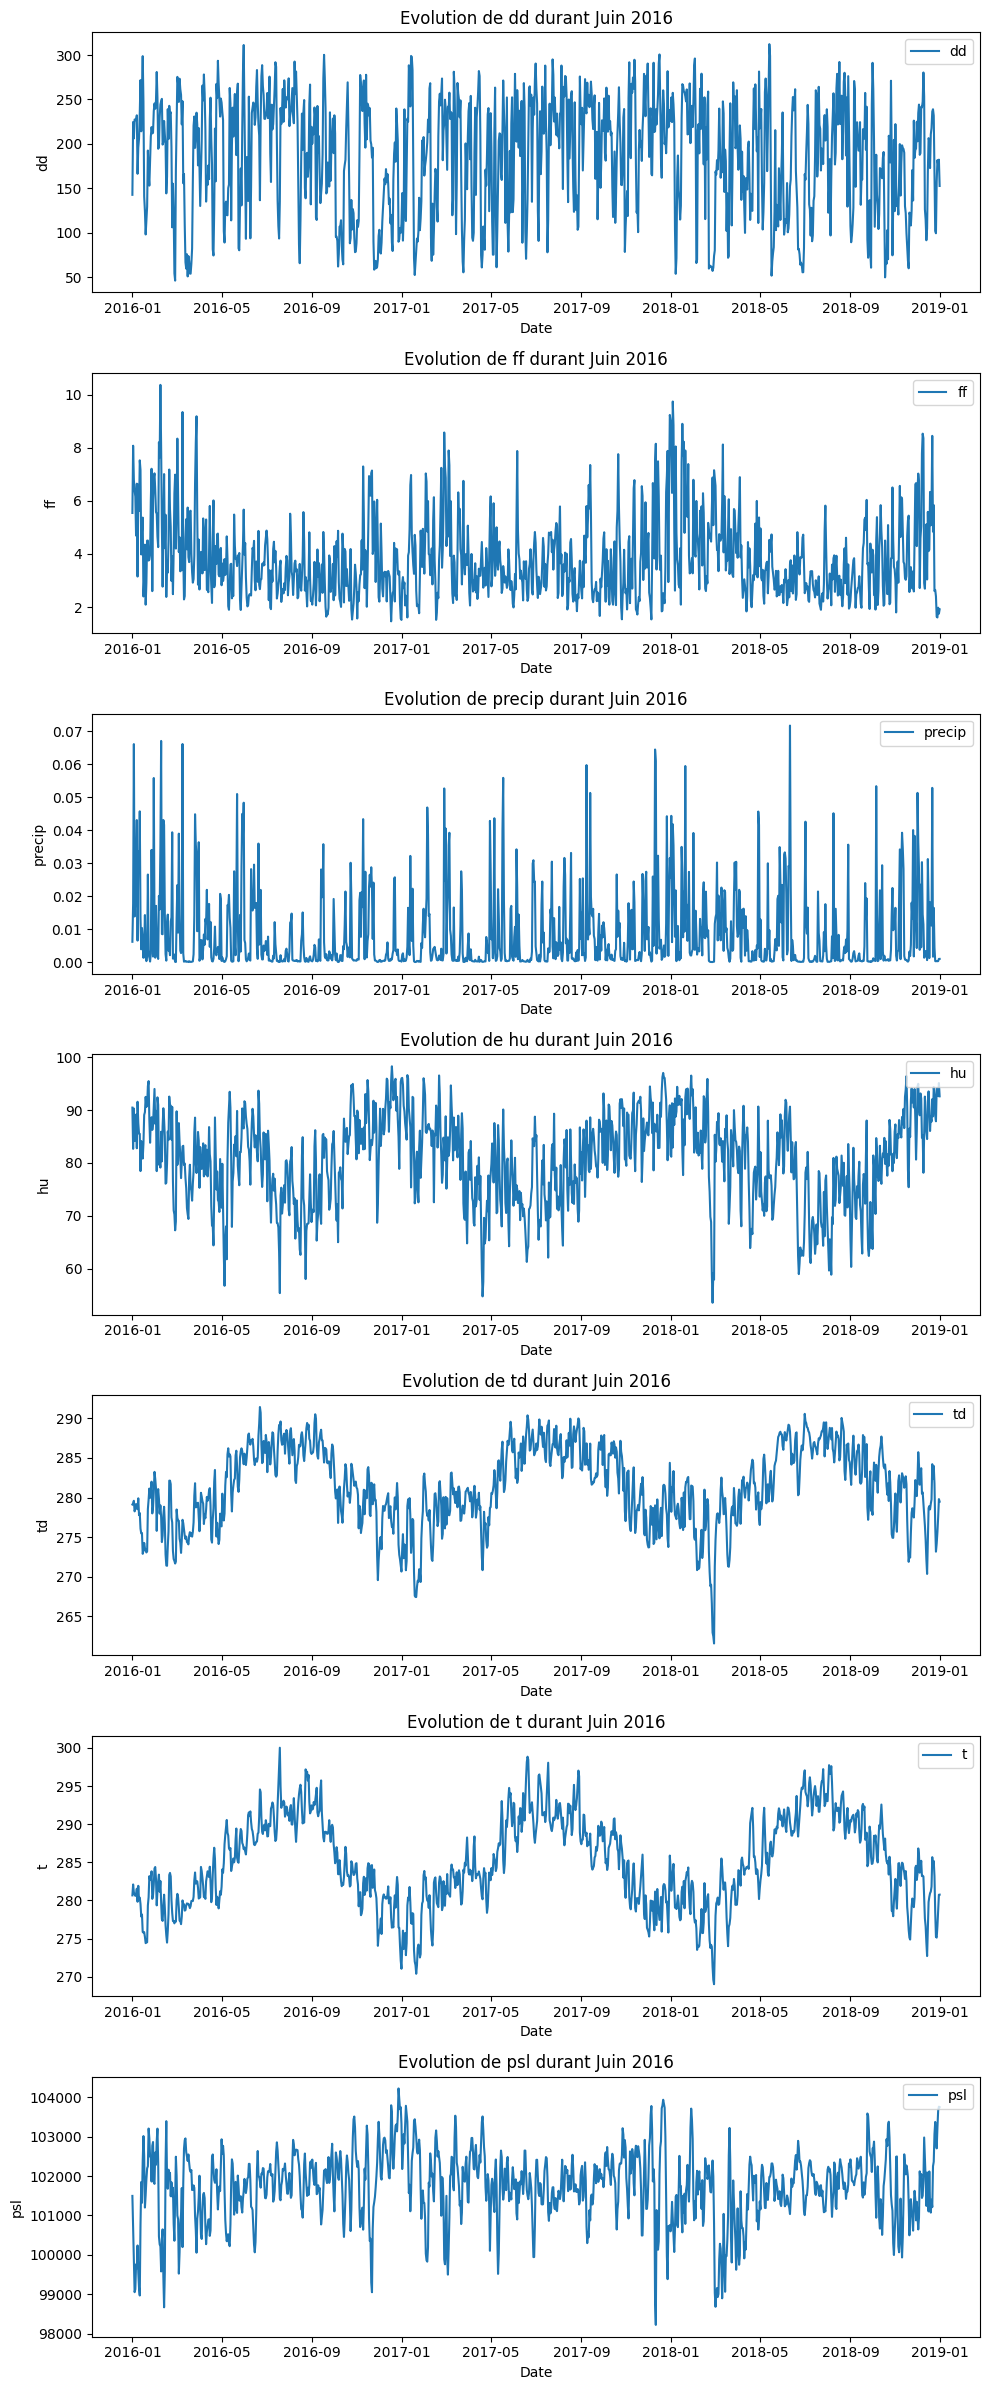

In [35]:
# Affichage des séries temporelles pour tous les paramètres afin 
# d'apprécier la tendance des courbes

# Graphique pour chaque paramètre
plt.figure(figsize=(10,24))

for i, param in enumerate(weather_params, 1):
    plt.subplot(len(weather_params), 1, i)
    plt.plot(GOd_all.index, GOd_all[param], label=param)
    plt.title(f"Evolution de {param} durant Juin 2016")
    plt.xlabel("Date")
    plt.ylabel(param)
    plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

<span style="color:magenta"> Malheuresement, et comme on pouvait s'y attendre, cette méthode visuelle ne donne pas assez d'indices sur le type de variations. Dans la suite on utilisera des méthodes plus robustes pour apprécier la tendance.

#### II. A. 3. d. Détermination de la tendance

<span style="color:magenta"> Dans cette partie, dû à des ambiguités sur les résultats de chaque méthode, on présente 3 méthodes pour vérifier la tendance de la série temporelles : décomposition et analyse de la tendance (i), justesse de l'ajustement un modèle de regression linéaire à la tendance (ii), et dérivée des résidus (iii).

##### II. A. 3. d. i) Analyse de la tendance par décomposition de la série temporelle

<Figure size 1000x800 with 0 Axes>

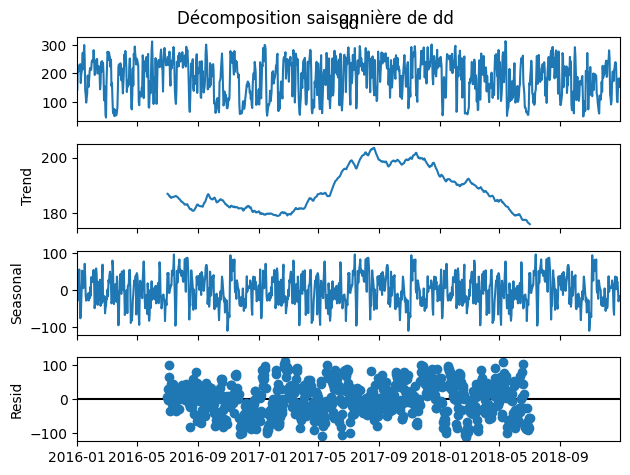

<Figure size 1000x800 with 0 Axes>

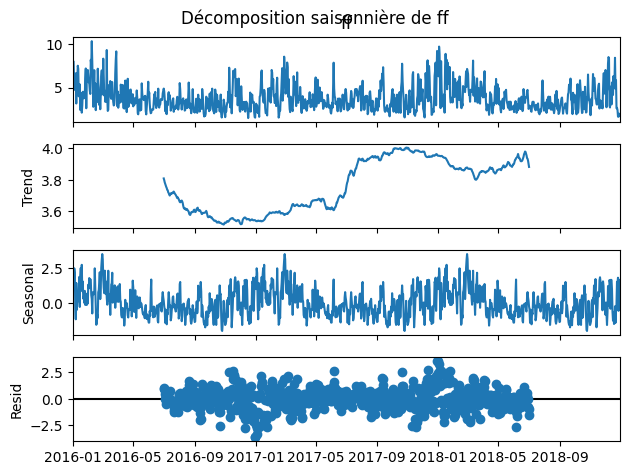

<Figure size 1000x800 with 0 Axes>

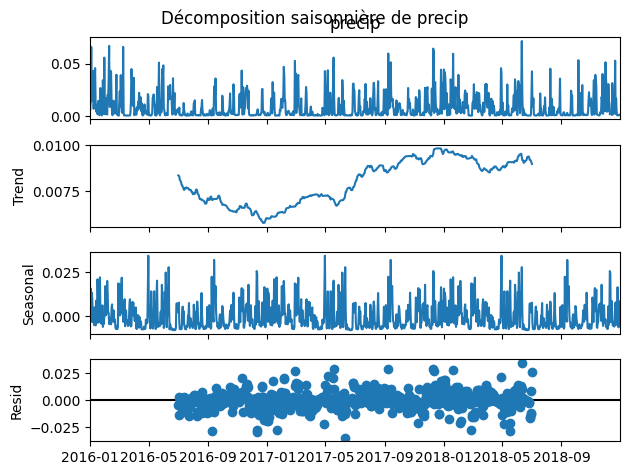

<Figure size 1000x800 with 0 Axes>

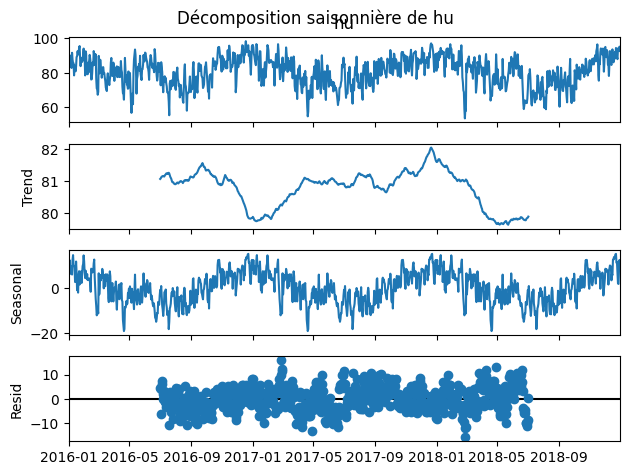

<Figure size 1000x800 with 0 Axes>

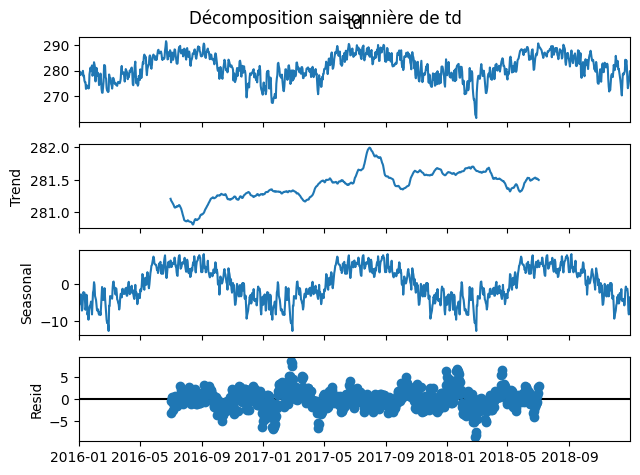

<Figure size 1000x800 with 0 Axes>

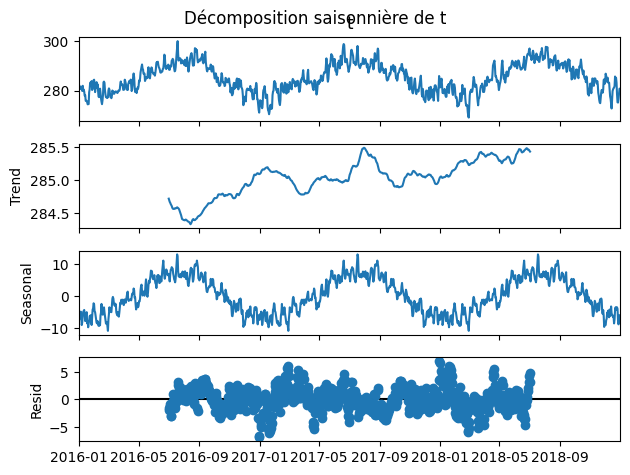

<Figure size 1000x800 with 0 Axes>

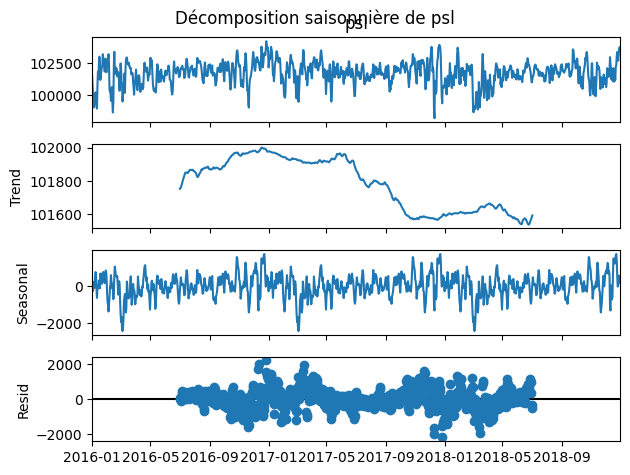

In [36]:
# Décomposition des séries temporelles en composante de tendance,
# saisonnalité et résidus pour les paramètres ne contenant pas de
# valeurs manquantes

# Décomposition de la série temporelle
for param in weather_params:
    try:
        tendance_GOd_all = seasonal_decompose(GOd_all[param], model='additive', period=365)
        plt.figure(figsize=(10, 8))
        tendance_GOd_all.plot()
        plt.suptitle(f'Décomposition saisonnière de {param}')
        plt.show()
    except Exception as e:
        print(f"Erreur lors de la décomposition de {param}: {e}")

<span style="color:magenta"> De façon similaire, l'analyse visuelle reste peu concluante, même une fois les séries temporelles décomposées. On regardera dans la suite des méthode quantitatives plus robustes.

##### II. A. 3. d. ii) Ajustement d'un modèle linéaire à la tendance

<span style="color:magenta"> On propose ici de quantifier la justesse de d'un modèle linéaire qu'on ajuste à la tendance. Le résultat du coefficient de détermination R2 est observé pour quantifier la justesse de l'ajustement.

  Paramètre        R²
0        dd  0.112210
1        ff  0.635181
2    precip  0.669828
3        hu  0.047583
4        td  0.505935
5         t  0.659674
6       psl  0.703999


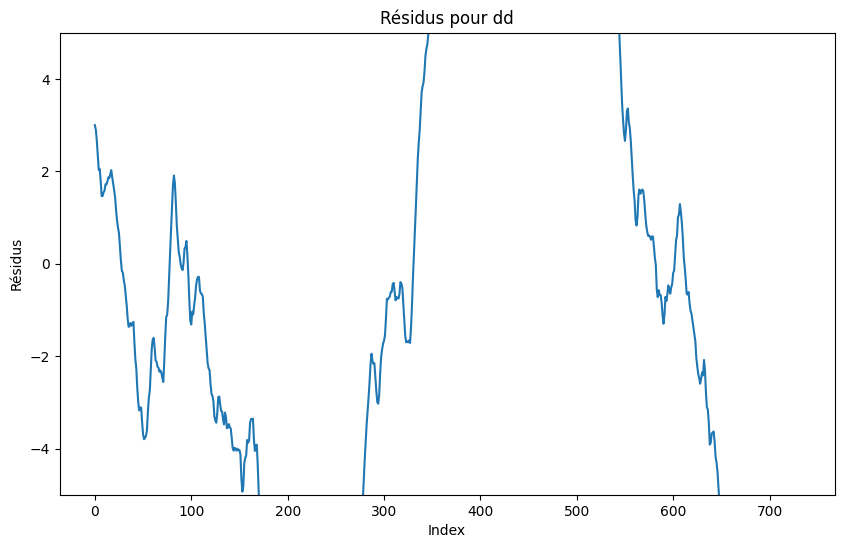

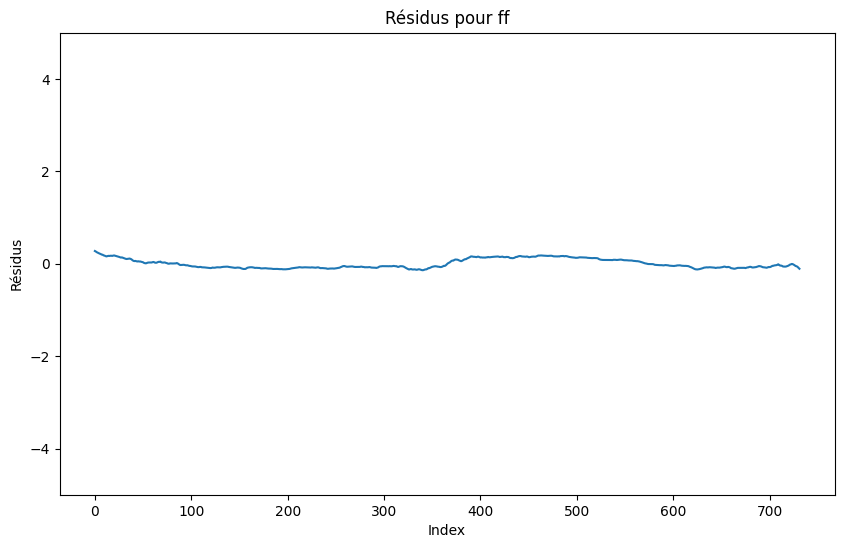

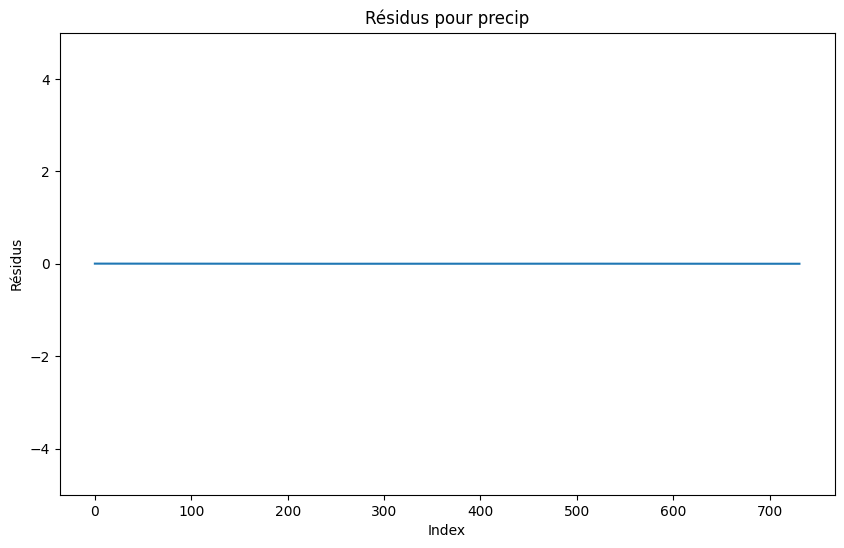

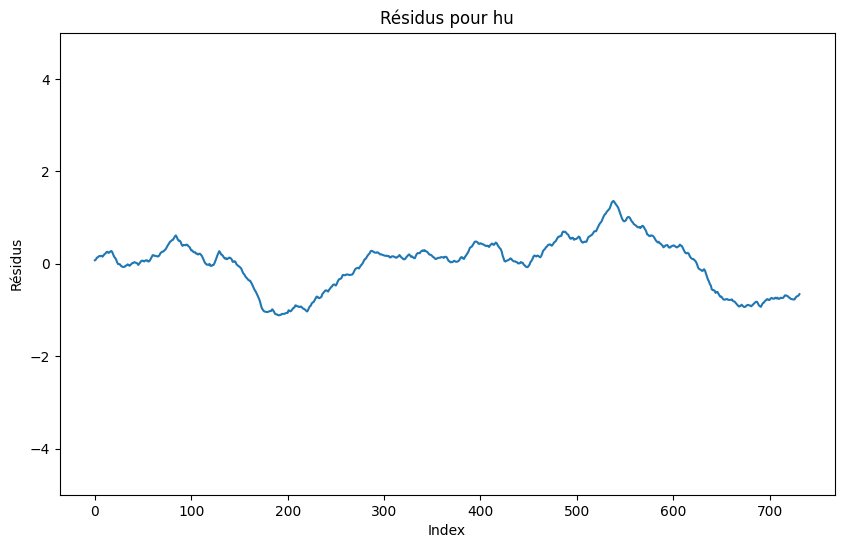

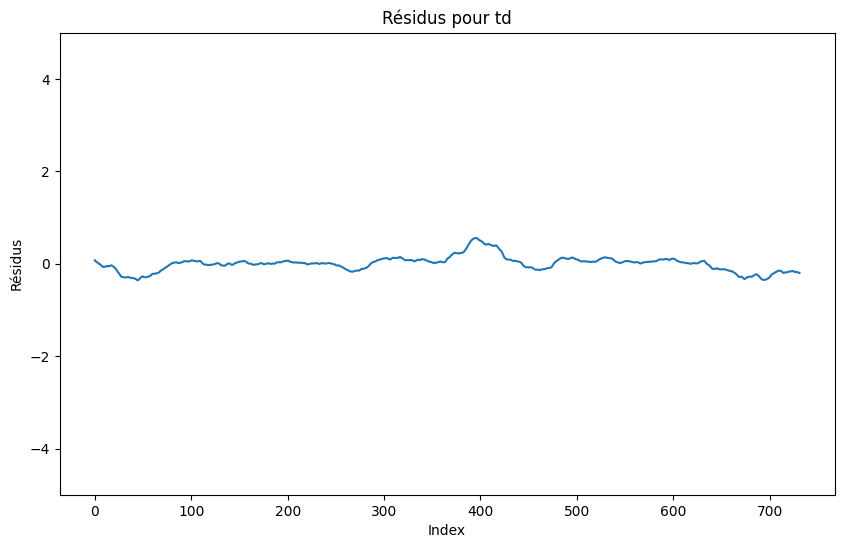

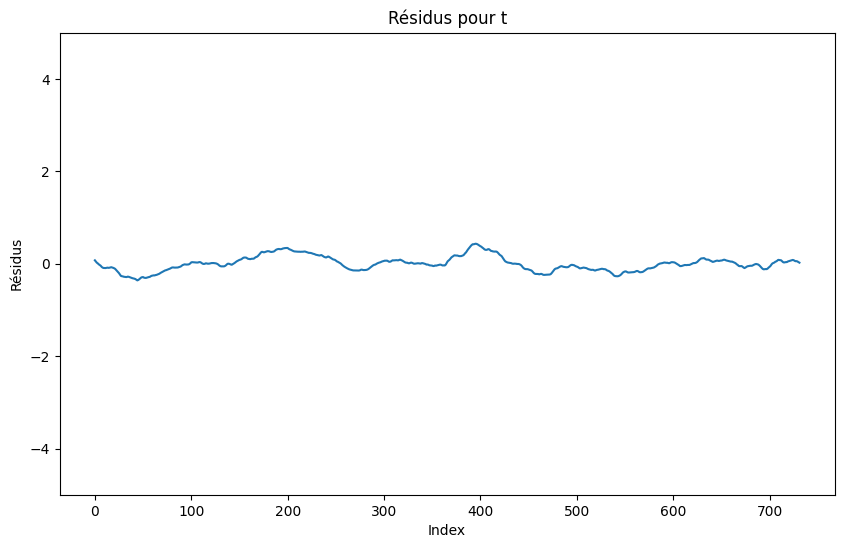

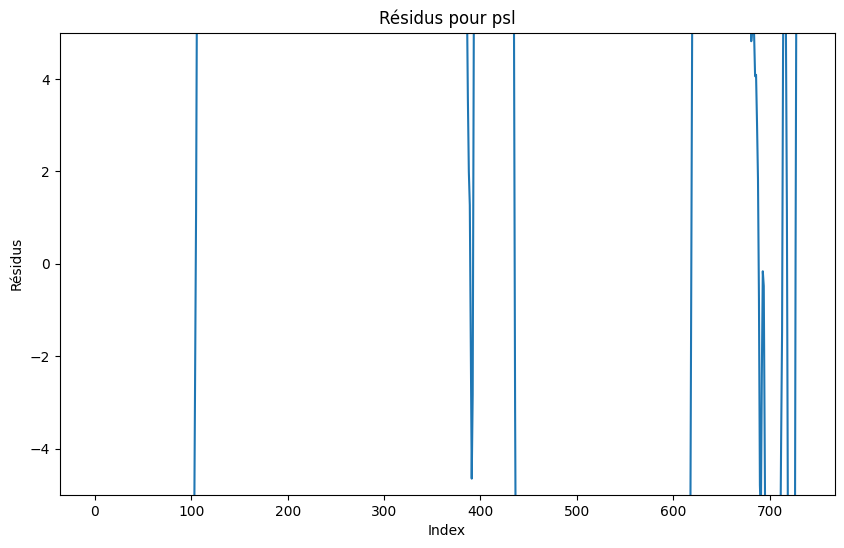

In [37]:
R2 = []
residus = []

for param in weather_params:
    try:
        tendance_GOd_all = seasonal_decompose(GOd_all[param], model='additive', period=365)
        
        trend_clean = tendance_GOd_all.trend.dropna()
        
        # très peu probable au vu du nombre de données :
        if len(trend_clean) == 0:  # Si la tendance est vide après suppression des NaN
            print(f"Pas assez de données pour {param} après suppression des NaN.")
            R2.append(None)  # Ajout de None pour signaler l'absence de R² valide
            continue
        
        X_ndai = np.array(range(len(trend_clean))).reshape(-1, 1) # X_ndai est un nom au hasard temporaire
        Y_ndai = trend_clean.values
        
        model = LinearRegression()
        model.fit(X_ndai, Y_ndai)

        R2.append(model.score(X_ndai, Y_ndai))
        
        residus_param = Y_ndai - model.predict(X_ndai)
        residus.append(residus_param)
        
    except Exception as e:
        print(f"Erreur lors de la décomposition de {param}: {e}")
        R2.append(None)
        residus.append(None)

# Création d'un DataFrame avec les paramètres et leurs scores R²
results_R2 = pd.DataFrame({
    'Paramètre': weather_params,
    'R²': R2
})

# Affichage du tableau
print(results_R2)

# Affichage des résidus
for i, param in enumerate(weather_params):
    if residus[i] is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(residus[i])
        plt.title(f"Résidus pour {param}")
        plt.xlabel("Index")
        plt.gca().set_ylim(-5, 5)
        plt.ylabel("Résidus")
        plt.show()

<span style="color:magenta"> D'après les résultats d'ajustement au modèle de régression linéaires, les paramètres hu et dd semblent ne pas suivrent des variations linéaires (resp. R2 = 0.047583 et R2 = 0.112210). <br>
De plus, d'après l'analyse  graphiques des résidus, bien que psl ait un bon ajustement à un modèle de régression linéaire par R2, les résidus varient fortement, laissant penser à des variations plus complexes ed manière étonnante.

<span style="color:magenta"> Les autres paramètres peuvent être considérés comme linéaire d'après cette méthode.

##### II. A. 3. d. iii) Calcul de la dérivée de la tendance

<span style="color:magenta"> Enfin, afin de mettre en perspective plusieurs techniques, et à cause des ambiguités générées par les techniques précédentes, on observe enfin la dérivée de la tendance, qui est constante si le modèle est linéaire, et varient si la variation est plus complexe. On trace le graphique pour chaque paramètres du modèle.

<span style="color:magenta"> I.e. : si la tendance est linéaire, la dérivée est donc constante, sinon elle varie plus finement.

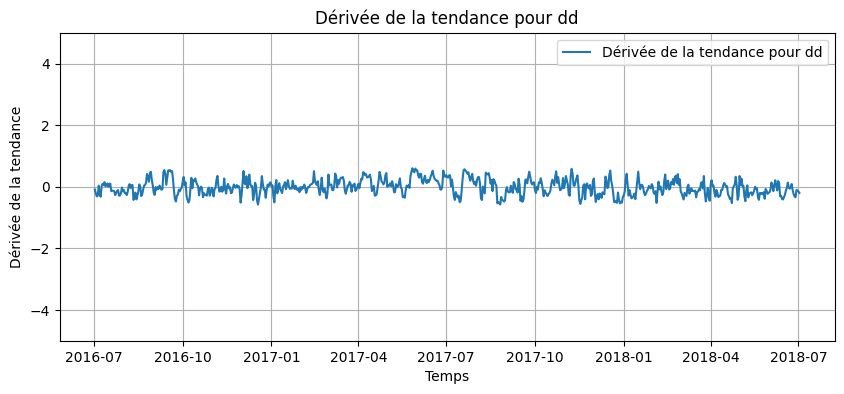

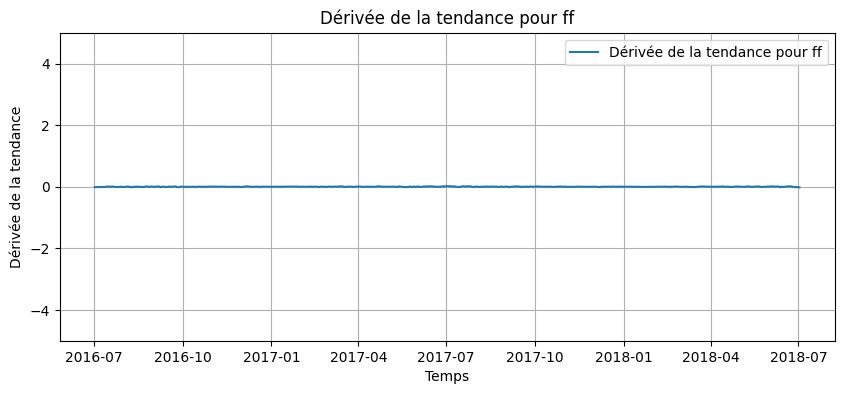

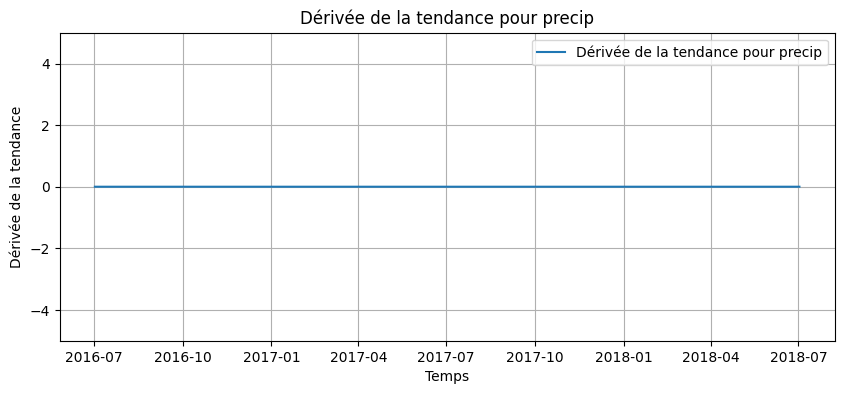

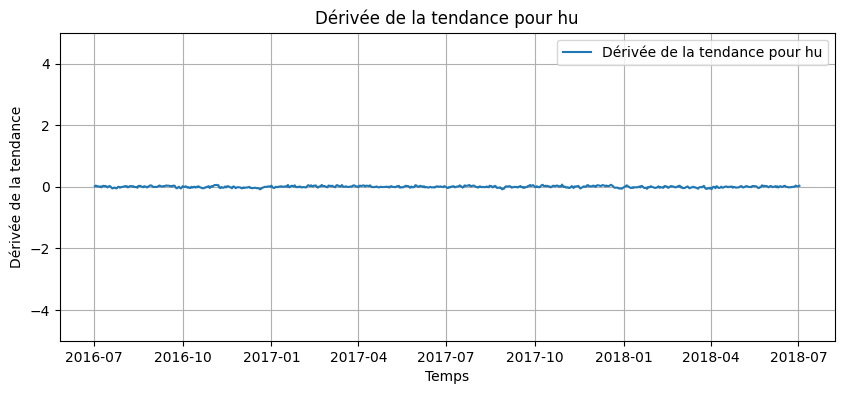

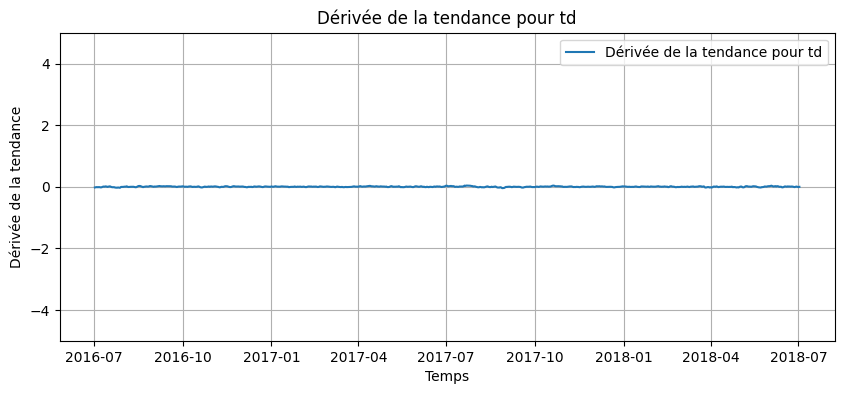

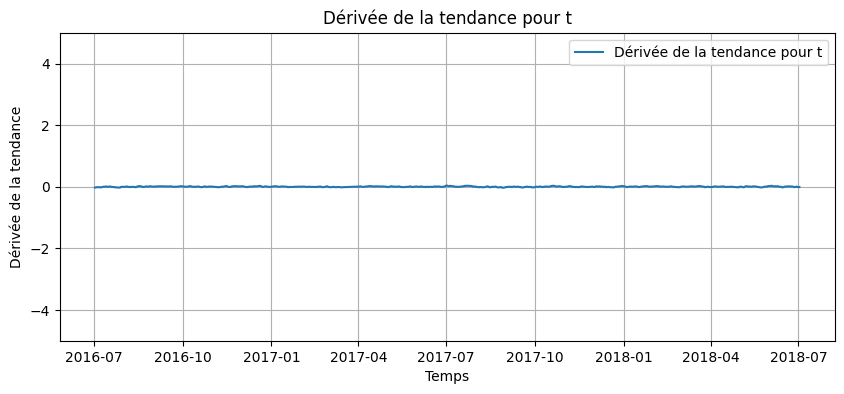

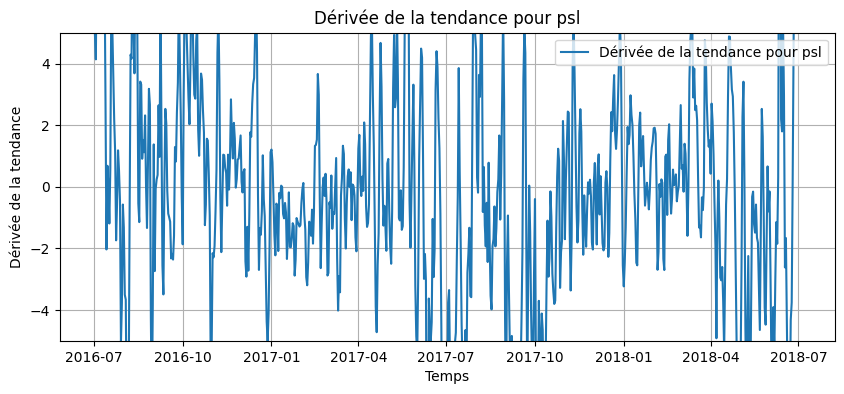

In [38]:
trend_derivative = []

for param in weather_params:
    try:
        # Décomposition de la série temporelle
        tendance_GOd_all = seasonal_decompose(GOd_all[param], model='additive', period=365)
        
        # Suppression des valeurs manquantes dans la tendance
        trend_clean = tendance_GOd_all.trend.dropna()

        if len(trend_clean) == 0:  # Si la tendance est vide après suppression des NaN
            print(f"Pas assez de données pour {param} après suppression des NaN.")
            trend_derivative.append(None)  # Ajouter None pour signaler l'absence de dérivée valide
            continue
        
        # Calcul de la dérivée de la tendance
        trend_deriv = trend_clean.diff().dropna()
        trend_derivative.append(trend_deriv)
        
    # On s'assure qu'il n'y a pas de problème lors de la décomposition
    except Exception as e:
        print(f"Erreur lors de la décomposition de {param}: {e}")
        trend_derivative.append(None)

# Création d'un DataFrame avec les paramètres et leurs dérivées de tendance
results_trend_derivative = pd.DataFrame({
    'Paramètre': weather_params,
    'Dérivée de Tendance': trend_derivative
})

# Visualisation des dérivées de tendance
for i, param in enumerate(weather_params):
    trend_data = trend_derivative[i]
    
    if trend_data is not None:
        plt.figure(figsize=(10, 4))
        plt.plot(trend_data, label=f"Dérivée de la tendance pour {param}")
        plt.xlabel("Temps")
        plt.ylabel("Dérivée de la tendance")
        plt.gca().set_ylim(-5, 5)
        plt.title(f"Dérivée de la tendance pour {param}")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"Aucune donnée de dérivée de tendance valide pour le paramètre : {param}")

<span style="color:magenta"> Il est clair que dd et psl ne semblent pas suivrent des variations linéaires. Au contraire l'analyse de hu est ambigüe. <br>
Pour l'interpolation, on considera que dd, hu psl ne suivent pas des tendances linéaires et on tentera une interpolation d'un ordre > 1. On considère en effet que dans le cas de relations complexes, elles pourront être captées par des méthodes d'interpolation non linéaires, ce qui n'est pas le cas inverse. On privilégie donc ce cas dans cette étude.

### II. A. 3. e. Interpolation des valeurs manquantes par méthode linéaire et non linéaires

<span style="color:magenta"> Dans cette partie, on tentera de réaliser un remplacement des valeurs manquantes, qui comme on l'a vu précédemment, sont nombreuses pour certaines variables.

<span style="color:magenta"> On tentera ce remlpacement par interpolation. Cette dernière sera réalisée afin d'être adapté au mieux au type de variation identifié précédemment.

#### II. A. 3. e. i) Définition des variables linéaires et non linéaires

In [39]:
# Définition des variables linéaires et non linéaires
weather_params_lineair = ["ff", "precip", "td", "t"]
weather_params_nonlinear = ["dd", "hu", "psl"]

#### II. A. 3. e. ii) Interpolation non linéaire et linéaire manuellement

In [40]:
# Importation du datasets converti et indexé
GO_2016_pt12 = pipeline_12.fit_transform(GO_2016) # Datetime + indexation
# GO_2016_pt2 = pipeline_2.fit_transform(GO_2016) # Datetime + indexation + resample sur heures

# Définir l'interpolation polynomiale d'ordre 2
class PolynomialInterpolation:
    def __init__(self, degree=2):
        self.degree = degree
        self.poly = PolynomialFeatures(degree=self.degree)
        self.model = LinearRegression()

    def fit(self, X, y=None):
        # Applique la transformation polynomiale
        self.model.fit(self.poly.fit_transform(np.arange(len(X)).reshape(-1, 1)), X)
        return self

    def transform(self, X):
        return self.model.predict(self.poly.transform(np.arange(len(X)).reshape(-1, 1)))

# Appliquer l'interpolation linéaire sur les colonnes linéaires
def linear_interpolation(df, columns):
    return df[columns].interpolate(method='linear', axis=0)

# Appliquer l'interpolation polynomiale d'ordre 2 uniquement sur les valeurs manquantes
def polynomial_interpolation_missing_values(df, columns):
    for col in columns:
        # Identifier les valeurs manquantes
        missing_mask = df[col].isna()
        
        if missing_mask.sum() > 0:  # Si des valeurs sont manquantes
            # Extraire les valeurs existantes pour ajuster l'interpolation
            non_missing_data = df[col].dropna()
            
            # Appliquer l'interpolation polynomiale sur les données non manquantes
            poly_interpolator = PolynomialInterpolation(degree=2)
            poly_interpolator.fit(non_missing_data)  # Fit sur les données non manquantes
            
            # Remplacer les valeurs manquantes par les valeurs interpolées
            df[col][missing_mask] = poly_interpolator.transform(df[col][missing_mask])
    
    return df


# Appliquer les interpolations à GO_2016_pt12 tout en conservant l'indexation et les autres colonnes
GO_2016_pt3 = GO_2016_pt12.copy()  # Pour éviter de modifier directement GO_2016_pt12

# Appliquer l'interpolation linéaire pour les paramètres linéaires
GO_2016_pt3[weather_params_lineair] = linear_interpolation(GO_2016_pt3, weather_params_lineair)

# Appliquer l'interpolation polynomiale d'ordre 2 pour les paramètres non linéaires
GO_2016_pt3 = polynomial_interpolation_missing_values(GO_2016_pt3, weather_params_nonlinear)

# Vérifier les résultats
GO_2016_pt3.head(10)

C:\Users\rapha\AppData\Local\Temp\ipykernel_49772\3708725022.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[col][missing_mask] = poly_interpolator.transform(df[col][missing_mask])
C:\Users\rapha\AppData\Local\Temp\ipykernel_49772\37

number_sta     lat    lon  height_sta          dd    ff  precip  \
date                                                                          
2016-01-01    14066001  49.330 -0.430         2.0  210.000000  4.40     0.0   
2016-01-01    14126001  49.150  0.040       125.0  180.043728  2.50     0.0   
2016-01-01    14137001  49.180 -0.460        67.0  220.000000  0.60     0.0   
2016-01-01    14216001  48.930 -0.150       155.0  220.000000  1.90     0.0   
2016-01-01    14296001  48.800 -1.030       339.0  180.043738  2.45     0.0   
2016-01-01    14357002  48.930 -0.690       223.0  180.043749  3.00     0.0   
2016-01-01    14366002  49.170  0.230        62.0  180.043759  3.55     0.0   
2016-01-01    14372001  49.102 -0.765       184.0  230.000000  4.10     0.0   
2016-01-01    14501002  48.890 -0.390       185.0  180.043770  4.60     0.0   
2016-01-01    14515001  49.350 -0.770        68.0  220.000000  5.10     0.0   

                   hu          td       t            psl  
date                                                      
2016-01-01  91.000000  278.450000  279.85  101293.677327  
2016-01-01  99.000000  278.350000  278.45  101293.677432  
2016-01-01  92.000000  276.450000  277.65  102360.000000  
2016-01-01  95.000000  278.250000  278.95  101293.677536  
2016-01-01  89.680304  278.200000  278.35  101293.677641  
2016-01-01  89.680300  278.150000  277.65  101293.677745  
2016-01-01  89.680295  278.100000  279.55  101293.677849  
2016-01-01  92.000000  278.050000  279.25  101293.677954  
2016-01-01  89.680291  278.583333  278.35  101293.678058  
2016-01-01  89.680287  279.116667  279.05  101293.678163

In [41]:
# Vérification de la présence de valeurs manquantes résultantes par calcul des proportions dans chaque colonne
vm2 = GO_2016_pt3.isnull().sum() # Nombre de valeurs manquantes par colonne
vm2_propor = vm2 /len(GO_2016_pt3) * 100

# Intégration dans le df original avec récupération des colonnes
vm_info2 = pd.DataFrame({
    "Valeurs manquantes" : vm2,
    "Pourcentage (%)" : vm2_propor
})

# Affichage du tableau
print(vm_info2)

            Valeurs manquantes  Pourcentage (%)
number_sta                   0              0.0
lat                          0              0.0
lon                          0              0.0
height_sta                   0              0.0
dd                           0              0.0
ff                           0              0.0
precip                       0              0.0
hu                           0              0.0
td                           0              0.0
t                            0              0.0
psl                          0              0.0


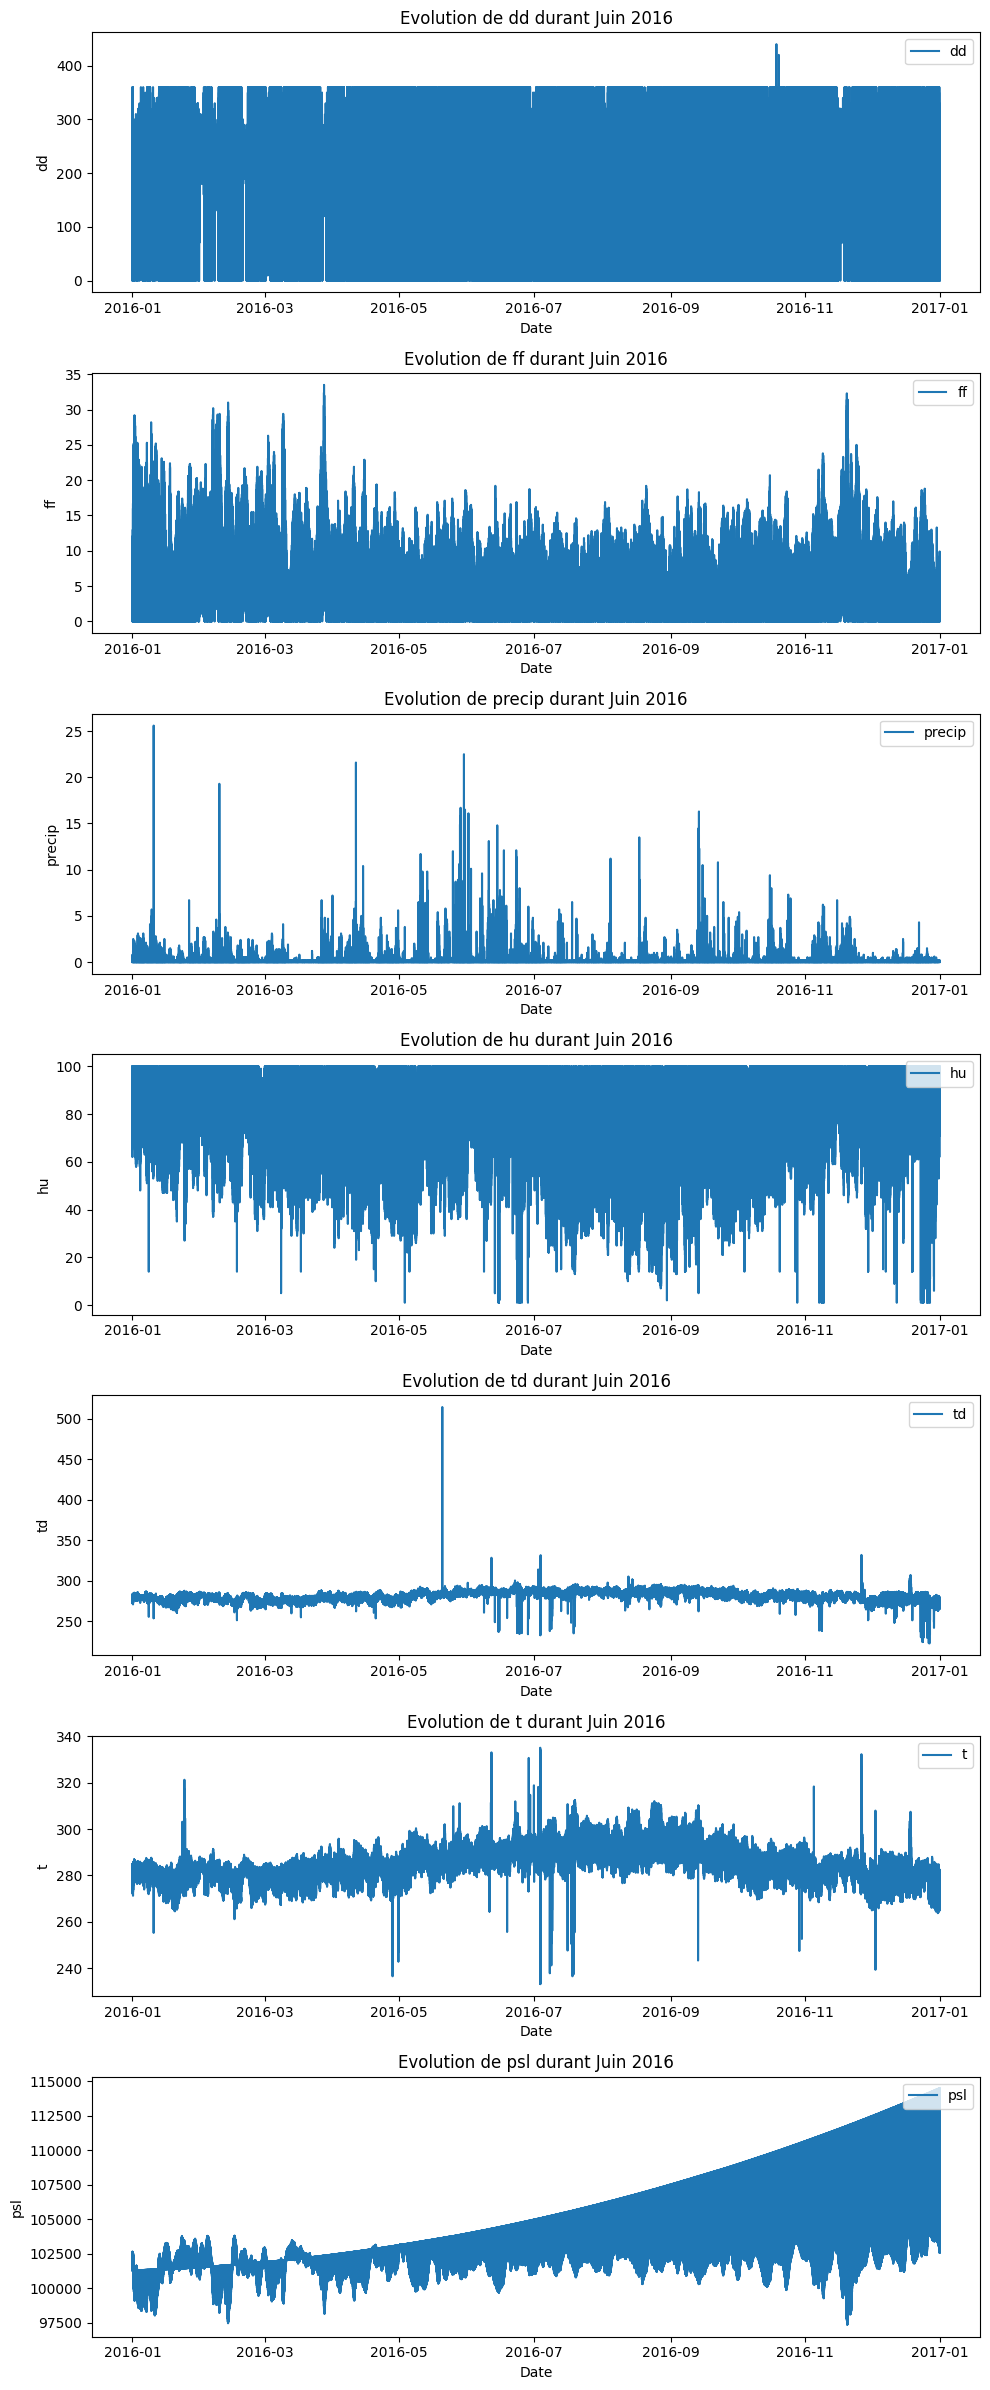

In [42]:
# Graphique pour chaque paramètre
plt.figure(figsize=(10,24))

for i, param in enumerate(weather_params, 1):
    plt.subplot(len(weather_params), 1, i)
    plt.plot(GO_2016_pt3.index, GO_2016_pt3[param], label=param)
    plt.title(f"Evolution de {param} durant Juin 2016")
    plt.xlabel("Date")
    plt.ylabel(param)
    plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

<span style="color:blue"> On a donc appliqué dans cette partie une interpolation linéaire et non linéaire en fonction des tendances qu'on avait pu observer pour chaque paramètres. Les autres colonnes ont été laissées intactes.

<span style="color:magenta"> Néanmoins, le résultat de l'observation est peu satisfaisant (ou l'expérience pas suffisante ...) pour se rendre compte de la pertinence de l'interpolation réalisée sur les séries temporelles.

<span style="color:magenta"> Ainsi, dans la suite de l'étude, on privilégiera donc une méthode par binning qui aura deux avantages et répondra à deux exigences pour les séries temporelles : supprimmer les valeurs manquantes et diminuer le volume de données à traiter. Le binning permettra également de conserver la tendance des séries temporelles : limite la présence de valeurs extrêmes et lisse les erreurs d'échantillonage.

#### II. A. 3. e. iii) Application à GO_2017 et GO_2018 :

<span style="color:magenta"> On a tout de même réalise l'interpolation sur les 3 jeux de données.

In [45]:
# Application de la fonction à GO_2017, et GO_2018

# Datatime et indexation
GO_2017_pt12 = pipeline_12.fit_transform(GO_2017)
GO_2018_pt12 = pipeline_12.fit_transform(GO_2018)


In [46]:
# Interpolation non linéaire et linéaire sur 2017 et 2018

GO_2017_pt3 = GO_2017_pt12.copy()
GO_2018_pt3 = GO_2018_pt12.copy()

GO_2017_pt3[weather_params_lineair] = linear_interpolation(GO_2017_pt3, weather_params_lineair)
GO_2018_pt3[weather_params_lineair] = linear_interpolation(GO_2018_pt3, weather_params_lineair)

GO_2017_pt3 = polynomial_interpolation_missing_values(GO_2017_pt3, weather_params_nonlinear)
GO_2018_pt3 = polynomial_interpolation_missing_values(GO_2018_pt3, weather_params_nonlinear)

C:\Users\rapha\AppData\Local\Temp\ipykernel_49772\3708725022.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[col][missing_mask] = poly_interpolator.transform(df[col][missing_mask])
C:\Users\rapha\AppData\Local\Temp\ipykernel_49772\37

In [47]:
print(GO_2017_pt3.head(3))

            number_sta    lat   lon  height_sta          dd    ff  precip  \
date                                                                        
2017-01-01    14066001  49.33 -0.43         2.0  180.000000  1.70     0.0   
2017-01-01    14126001  49.15  0.04       125.0  170.852569  0.85     0.0   
2017-01-01    14137001  49.18 -0.46        67.0    0.000000  0.00     0.0   

              hu      td       t            psl  
date                                             
2017-01-01  95.0  269.55  270.25  102217.392181  
2017-01-01  96.0  267.75  268.25  102217.391770  
2017-01-01  98.0  267.85  268.15  102750.000000  


In [48]:
GO_2018_pt3.head(3)

number_sta    lat   lon  height_sta          dd     ff  precip  \
date                                                                         
2018-01-01    14066001  49.33 -0.43         2.0  240.000000   8.20     0.0   
2018-01-01    14126001  49.15  0.04       125.0  194.368337   9.45     0.0   
2018-01-01    14137001  49.18 -0.46        67.0  250.000000  10.70     0.0   

              hu      td       t            psl  
date                                             
2018-01-01  84.0  276.75  279.25  101069.065667  
2018-01-01  98.0  278.75  279.05  101069.065990  
2018-01-01  85.0  278.15  280.55  100690.000000

<span style="color:magenta"> Les données interpollées sont conservées au format "dataset_pt3" (ie. pt = pre-transformed).

## II. B. Binning de la série temporelles sur les heures

<span style="color:magenta"> Le binning est une méthode de lissage des séries temporelles. Ici il permet à la fois de réduire le volume des données traitées pour plus de simplicité, mais il permet également de supprimer les valeurs manquantes par la méthode d'aggrégation, et d'amoindrir l'effet des valeurs extrêmes. <br>
Ici, on choisit de réaliser un binning sur les jours, avec moyenne. Ce binning génère un nombre de données suffisantes pour le traitement par des modèles de machines learning, et reste robuste aux outliers.

### II. B. 1. Récupération du dataset sur lequel on a appliqué un binning de la série temporelles sur la période jours.

In [49]:
# Vérification du dataset
GOd_all

number_sta        lat       lon  height_sta          dd  \
date                                                                    
2016-01-01  4.863150e+07  48.029404 -0.557978  105.742683  142.565140   
2016-01-02  4.883583e+07  48.021167 -0.597521  104.755942  224.575650   
2016-01-03  4.884368e+07  48.021820 -0.598103  104.689495  206.030980   
2016-01-04  4.860577e+07  48.034724 -0.616295  104.622844  227.410325   
2016-01-05  4.857767e+07  48.041833 -0.616962  104.721234  226.697747   
...                  ...        ...       ...         ...         ...   
2018-12-27  4.839480e+07  48.051527 -0.560203  108.109755  157.526755   
2018-12-28  4.831586e+07  48.046682 -0.562280  107.831725  181.583986   
2018-12-29  4.830725e+07  48.046967 -0.562294  107.828169  176.532043   
2018-12-30  4.830685e+07  48.046946 -0.562274  107.827488  182.152689   
2018-12-31  4.836235e+07  48.054115 -0.574117  107.344779  152.540840   

                  ff    precip         hu          td           t  \
date                                                                
2016-01-01  5.544330  0.006140  90.459589  279.114726  280.664479   
2016-01-02  8.076853  0.017763  82.659115  279.275153  282.096027   
2016-01-03  6.786727  0.066035  90.287195  279.588540  281.067948   
2016-01-04  6.392213  0.013804  84.132986  278.250949  280.771227   
2016-01-05  6.162108  0.018896  87.353842  278.651130  280.598605   
...              ...       ...        ...         ...         ...   
2018-12-27  1.630601  0.000336  94.126134  274.172423  275.126575   
2018-12-28  1.607861  0.000244  94.086290  275.642263  276.622484   
2018-12-29  1.975741  0.000287  92.634498  277.518793  278.684639   
2018-12-30  1.751787  0.000951  95.104431  279.798459  280.749739   
2018-12-31  1.914839  0.000957  92.594274  279.473891  280.760008   

                      psl  
date                       
2016-01-01  101495.439693  
2016-01-02  100668.146321  
2016-01-03   99753.926952  
2016-01-04   99051.748592  
2016-01-05   99128.681328  
...                   ...  
2018-12-27  102701.961844  
2018-12-28  103225.636974  
2018-12-29  103660.688256  
2018-12-30  103759.553795  
2018-12-31  103748.615487  

[1096 rows x 11 columns]

In [50]:
# Vérification des valeurs manquantes calcul des proportions dans chaque colonne
vm3 = GOd_all.isnull().sum() # Nombre de valeurs manquantes par colonne
vm3_propor = vm3 /len(GOd_all) * 100

# Intégration dans le df original avec récupération des colonnes
vm_info3 = pd.DataFrame({
    "Valeurs manquantes" : vm3,
    "Pourcentage (%)" : vm3_propor
})

# Affichage du tableau
print(vm_info3)

            Valeurs manquantes  Pourcentage (%)
number_sta                   0              0.0
lat                          0              0.0
lon                          0              0.0
height_sta                   0              0.0
dd                           0              0.0
ff                           0              0.0
precip                       0              0.0
hu                           0              0.0
td                           0              0.0
t                            0              0.0
psl                          0              0.0


### II. B. 2. Observation des séries temporelles

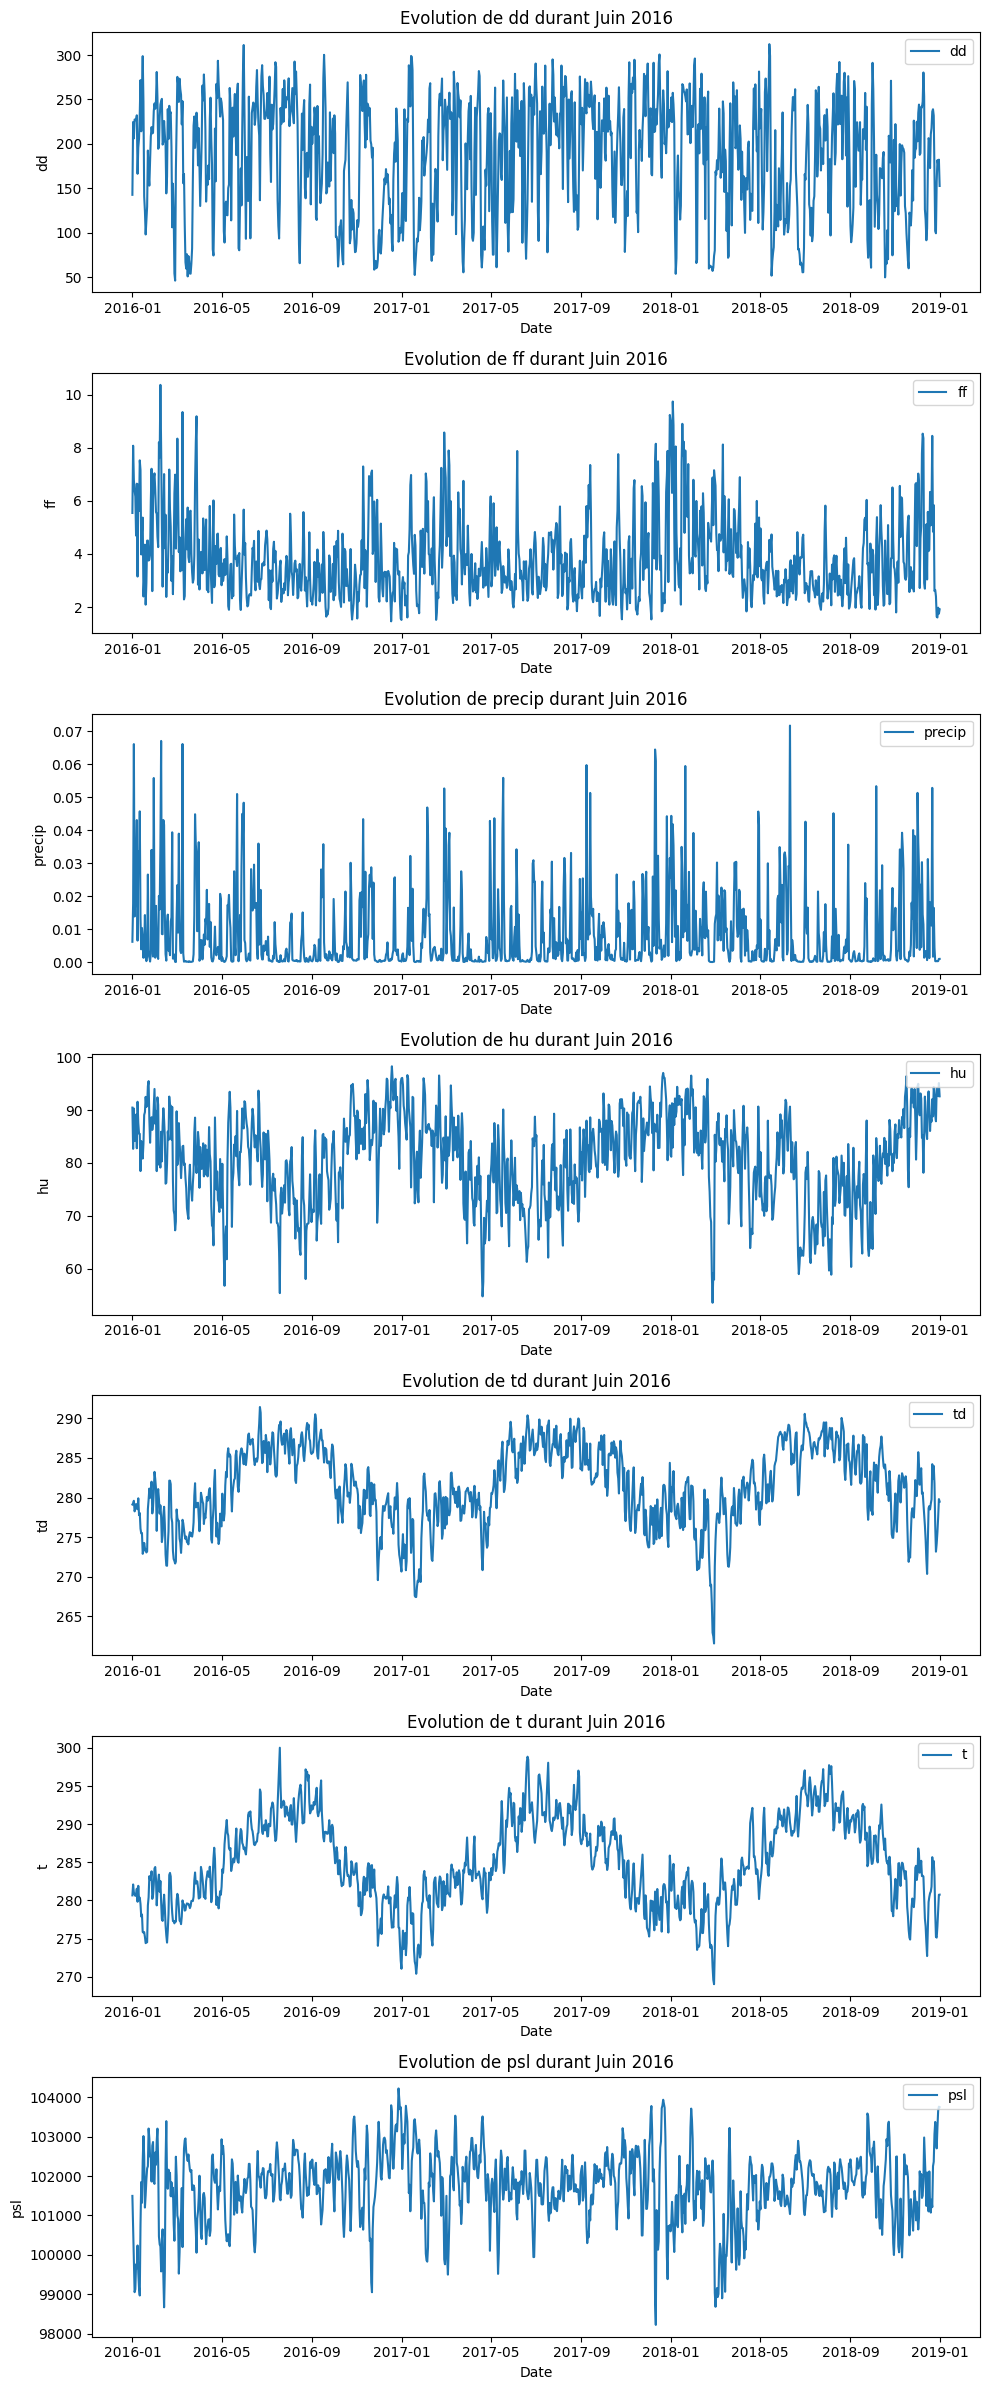

In [51]:
# Graphique pour chaque paramètre
plt.figure(figsize=(10,24))

for i, param in enumerate(weather_params, 1):
    plt.subplot(len(weather_params), 1, i)
    plt.plot(GOd_all.index, GOd_all[param], label=param)
    plt.title(f"Evolution de {param} durant Juin 2016")
    plt.xlabel("Date")
    plt.ylabel(param)
    plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

<span style="color:magenta"> A l'issue du traitement des valeurs manquantes, on a choisit de travailler avec un binning sur les jours et la moyenne. Ce binning est réalisé sur les 3 ans. Le jeu de données résultant est nommé : **GOd_all**.

## II. C. Observation des valeurs extrêmes

<span style="color:magenta"> On s'assure dans cette partie que GOd_all ne contient pas de valeurs extrêmes. Pour cela on utilise plusieurs méthodes pour plus de robustesse : on analysera la distribution des résidus, et on réalisera une analyse par moyenne glissante.

### II. C. 1. Récupération du dataset d'intérêt : GOd_all

In [52]:
# Concaténation sur l'index temporel
GOd_all

number_sta        lat       lon  height_sta          dd  \
date                                                                    
2016-01-01  4.863150e+07  48.029404 -0.557978  105.742683  142.565140   
2016-01-02  4.883583e+07  48.021167 -0.597521  104.755942  224.575650   
2016-01-03  4.884368e+07  48.021820 -0.598103  104.689495  206.030980   
2016-01-04  4.860577e+07  48.034724 -0.616295  104.622844  227.410325   
2016-01-05  4.857767e+07  48.041833 -0.616962  104.721234  226.697747   
...                  ...        ...       ...         ...         ...   
2018-12-27  4.839480e+07  48.051527 -0.560203  108.109755  157.526755   
2018-12-28  4.831586e+07  48.046682 -0.562280  107.831725  181.583986   
2018-12-29  4.830725e+07  48.046967 -0.562294  107.828169  176.532043   
2018-12-30  4.830685e+07  48.046946 -0.562274  107.827488  182.152689   
2018-12-31  4.836235e+07  48.054115 -0.574117  107.344779  152.540840   

                  ff    precip         hu          td           t  \
date                                                                
2016-01-01  5.544330  0.006140  90.459589  279.114726  280.664479   
2016-01-02  8.076853  0.017763  82.659115  279.275153  282.096027   
2016-01-03  6.786727  0.066035  90.287195  279.588540  281.067948   
2016-01-04  6.392213  0.013804  84.132986  278.250949  280.771227   
2016-01-05  6.162108  0.018896  87.353842  278.651130  280.598605   
...              ...       ...        ...         ...         ...   
2018-12-27  1.630601  0.000336  94.126134  274.172423  275.126575   
2018-12-28  1.607861  0.000244  94.086290  275.642263  276.622484   
2018-12-29  1.975741  0.000287  92.634498  277.518793  278.684639   
2018-12-30  1.751787  0.000951  95.104431  279.798459  280.749739   
2018-12-31  1.914839  0.000957  92.594274  279.473891  280.760008   

                      psl  
date                       
2016-01-01  101495.439693  
2016-01-02  100668.146321  
2016-01-03   99753.926952  
2016-01-04   99051.748592  
2016-01-05   99128.681328  
...                   ...  
2018-12-27  102701.961844  
2018-12-28  103225.636974  
2018-12-29  103660.688256  
2018-12-30  103759.553795  
2018-12-31  103748.615487  

[1096 rows x 11 columns]

In [53]:
# Vérification de la bonne concaténation
print(GOd_all.head(5),
      GOd_all.shape)

              number_sta        lat       lon  height_sta          dd  \
date                                                                    
2016-01-01  4.863150e+07  48.029404 -0.557978  105.742683  142.565140   
2016-01-02  4.883583e+07  48.021167 -0.597521  104.755942  224.575650   
2016-01-03  4.884368e+07  48.021820 -0.598103  104.689495  206.030980   
2016-01-04  4.860577e+07  48.034724 -0.616295  104.622844  227.410325   
2016-01-05  4.857767e+07  48.041833 -0.616962  104.721234  226.697747   

                  ff    precip         hu          td           t  \
date                                                                
2016-01-01  5.544330  0.006140  90.459589  279.114726  280.664479   
2016-01-02  8.076853  0.017763  82.659115  279.275153  282.096027   
2016-01-03  6.786727  0.066035  90.287195  279.588540  281.067948   
2016-01-04  6.392213  0.013804  84.132986  278.250949  280.771227   
2016-01-05  6.162108  0.018896  87.353842  278.651130  280.598605   

    

### II. C. 2. Analyse des valeurs extrêmes

### II. C. 2. a. Analyse de la distribution des résidus

<span style="color:magenta"> L'observation des résidus permet de détecter les valeurs extrêmes des écarts importants par rapport aux prédictions du modèle donneront des indices sur la présence de valeurs extrêmes.

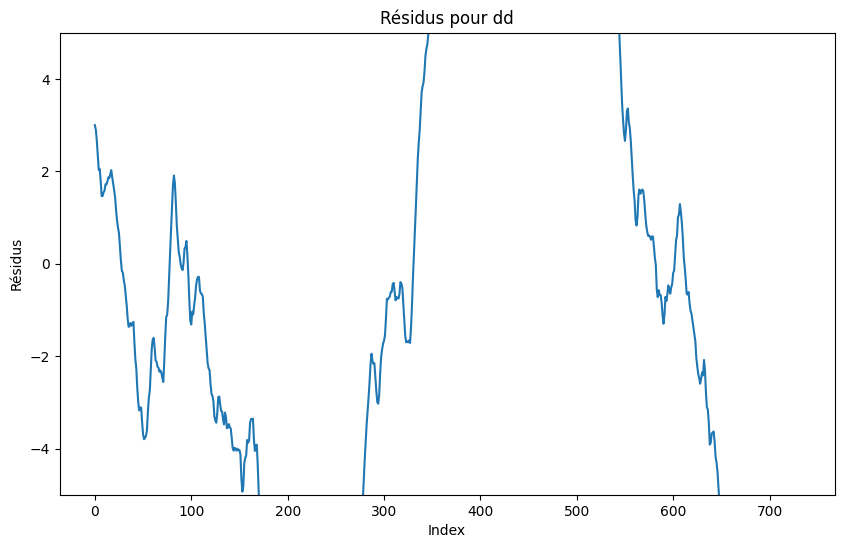

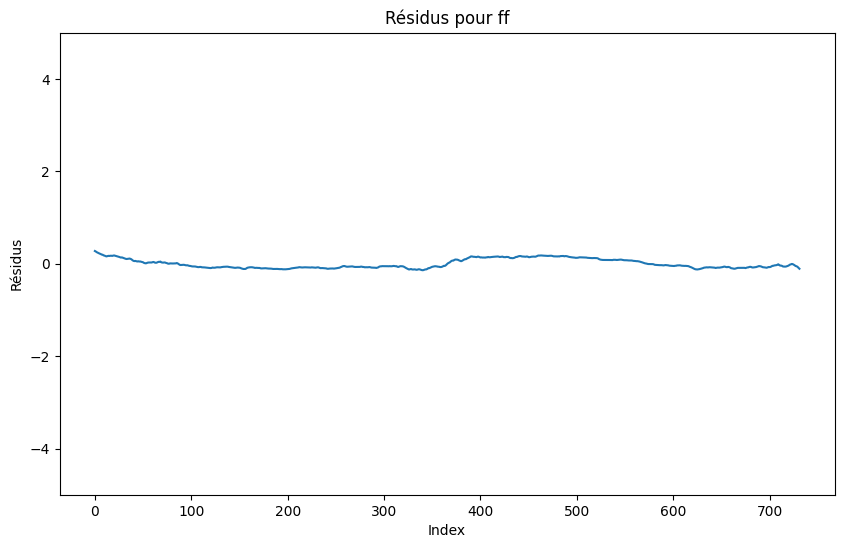

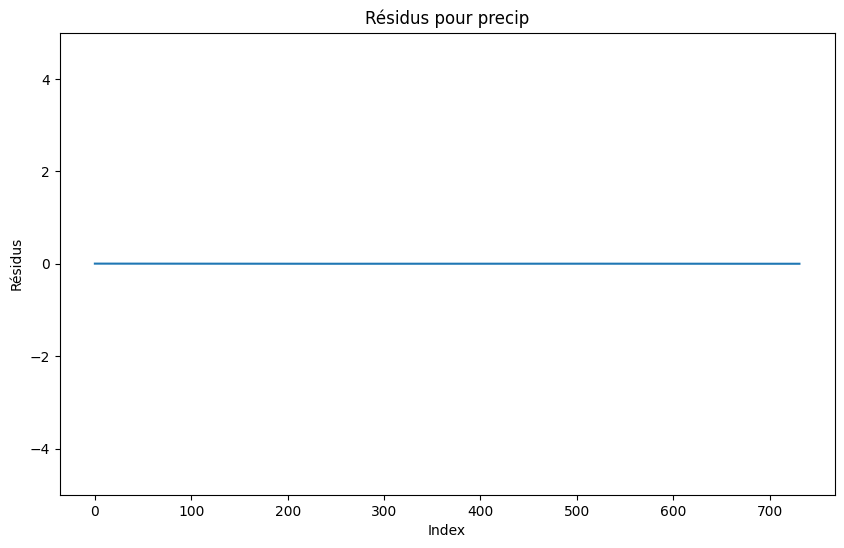

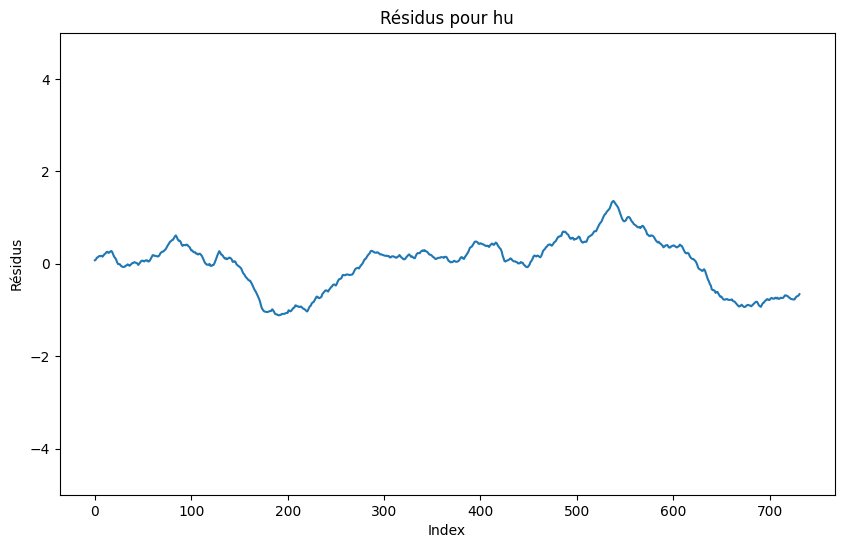

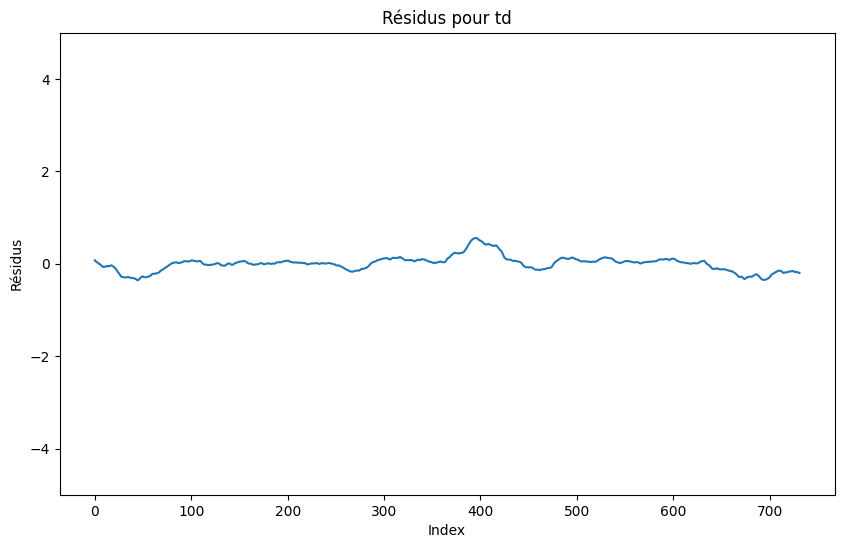

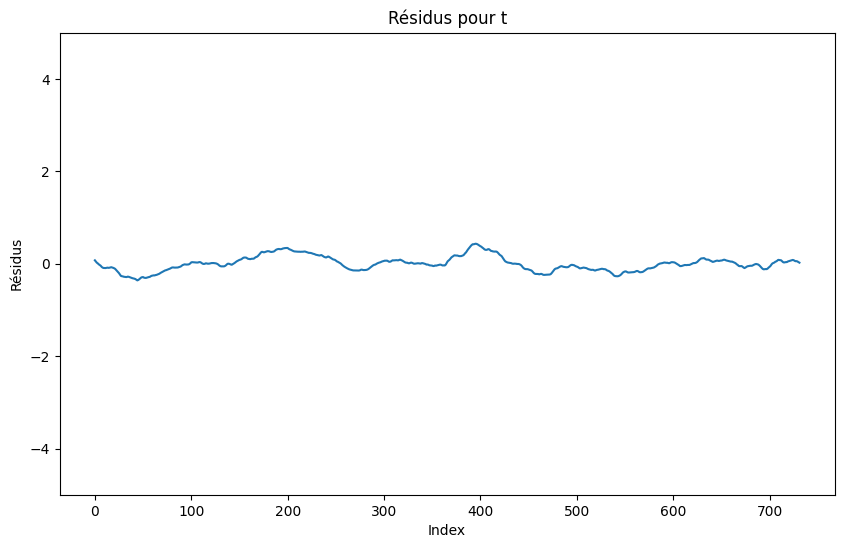

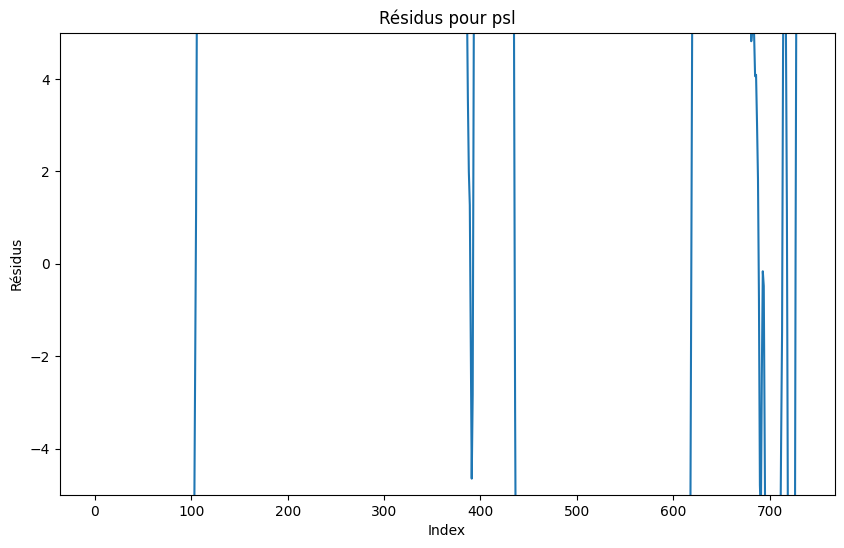

In [54]:
# Liste pour stocker les résidus pour chaque paramètre
residus = []

# Boucle sur chaque paramètre météorologique
for param in weather_params:
    try:
        # Décomposition saisonnière pour extraire la tendance
        tendance_GOd_all = seasonal_decompose(GOd_all[param], model='additive', period=365)
        trend_clean_2 = tendance_GOd_all.trend.dropna()

        # Vérification si la tendance nettoyée contient suffisamment de données
        if len(trend_clean_2) == 0:
            print(f"Pas assez de données pour {param} après suppression des NaN.")
            continue

        # Préparation des données pour la régression linéaire
        X_ndaiui = np.array(range(len(trend_clean_2))).reshape(-1, 1)
        Y_ndaiui = trend_clean_2.values
        
        # Régression linéaire sur la tendance
        model = LinearRegression()
        model.fit(X_ndaiui, Y_ndaiui)

        # Calcul des résidus
        residus_param = Y_ndaiui - model.predict(X_ndaiui)
        residus.append(residus_param)

    except Exception as e:
        print(f"Erreur lors de la décomposition de {param}: {e}")
        residus.append(None)

# Affichage des résidus pour chaque paramètre
for i, param in enumerate(weather_params):
    if residus[i] is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(residus[i])
        plt.title(f"Résidus pour {param}")
        plt.xlabel("Index")
        plt.gca().set_ylim(-5, 5)
        plt.ylabel("Résidus")
        plt.show()

<span style="color:magenta"> Une fois encore, les analyses visuelles, bien qu'elles donnent des indices, ne donnent pas à de manière certaines les valeurs extrèmes. Par exemple, pour psl, on observe de grande variations dans les résidus : on pouvait s'y attendre, car on a observé que psl, dd et hu ne variait probablement pas de manière linéaire. Le modèle linéaire choisit pour ajuster les résidus ne convient donc pas observer les valeurs extrêmes dans ce cas. <br>
De plus, les données n'étant pas normalisées et variant pour psl sur une très grande plage de valeurs, on aura du mal à déterminer certainement si l'écart relatif à zéro permet de déduire discrimer les valeurs extrèmes, ou si ce n'est pas le cas.

<span style="color:magenta"> On se concentre dans la suite sur une méthode plus robuste.

#### II. C. 2. A. Analyse par fenêtre glissante et écart à l'écart type

<span style="color:magenta"> Une seconde méthode pour identifier les points aberrants est proposé ici : on utilise ici une moyenne glissante sur 24 jours autour du point considérés. Pour chaque point, on calcul l'écart (quantifié en écart-type) à la moyenne observée pour les 24 jours autour du point pour chaque paramètre considérées. On discrimine comme valeur extrême les points ayant un écart à la moyenne supérieur à 5 écart-types. <br>
Les informations sont résumées dans un tableau ci-dessous.

In [55]:
def detect_outliers_rolling(df, columns, window=24, threshold=5):
    outliers = pd.DataFrame()
    for col in columns:
        rolling_mean = df[col].rolling(window=window).mean()
        rolling_std = df[col].rolling(window=window).std()
        outliers[col] = (df[col] > (rolling_mean + threshold * rolling_std)) | (df[col] < (rolling_mean - threshold * rolling_std))
    return outliers

# Détection des outliers pour les paramètres spécifiés
outliers_rolling = detect_outliers_rolling(GOd_all, weather_params)

# Création d'un tableau récapitulatif pour chaque paramètre
outlier_summary = []

for col in outliers_rolling.columns:
    num_outliers = outliers_rolling[col].sum()  # Nombre d'outliers
    total_data_points = len(outliers_rolling[col])  # Nombre total de points de données
    proportion_outliers = num_outliers / total_data_points  # Proportion des outliers
    
    outlier_summary.append({
        'Paramètre': col,
        'Nombre d\'outliers': num_outliers,
        'Proportion d\'outliers': proportion_outliers
    })

# Convertir en DataFrame pour une meilleure lisibilité
outlier_summary_df = pd.DataFrame(outlier_summary)
print(outlier_summary_df)

  Paramètre  Nombre d'outliers  Proportion d'outliers
0        dd                  0                    0.0
1        ff                  0                    0.0
2    precip                  0                    0.0
3        hu                  0                    0.0
4        td                  0                    0.0
5         t                  0                    0.0
6       psl                  0                    0.0


<span style="color:magenta"> On observe, avec le seuil fixé, aucune valeur extrême. Cette méthode est en effet discutable.

<span style="color:magenta"> En effet, comment fixer la distance à l'écart-type minimum pour identifer un point aberrant ? Ici on fixe cet écart à 5, on suppose en effet que les phénomènes météorologiques violents peuvent créer de grandes variations dans les données, tout en étant des éléments intrinsèques de la météorologie, et donc à considérer. <br>
En perspective, une analyse bibliographique pourrait nous aider à déterminer le bon seuil.

## II. D. Standardisation des données

<span style="color:magenta"> Dans cette partie, on se propose de standardiser les données, afin de faciliter leur intégration à des modèles météorologiques. <br>
Dans cet étude, la standardisation est préférée à la normalisation, afin de conserver les effets de corrélations inverses entre les paramètres.

In [56]:
GOd_all.head(5)

number_sta        lat       lon  height_sta          dd  \
date                                                                    
2016-01-01  4.863150e+07  48.029404 -0.557978  105.742683  142.565140   
2016-01-02  4.883583e+07  48.021167 -0.597521  104.755942  224.575650   
2016-01-03  4.884368e+07  48.021820 -0.598103  104.689495  206.030980   
2016-01-04  4.860577e+07  48.034724 -0.616295  104.622844  227.410325   
2016-01-05  4.857767e+07  48.041833 -0.616962  104.721234  226.697747   

                  ff    precip         hu          td           t  \
date                                                                
2016-01-01  5.544330  0.006140  90.459589  279.114726  280.664479   
2016-01-02  8.076853  0.017763  82.659115  279.275153  282.096027   
2016-01-03  6.786727  0.066035  90.287195  279.588540  281.067948   
2016-01-04  6.392213  0.013804  84.132986  278.250949  280.771227   
2016-01-05  6.162108  0.018896  87.353842  278.651130  280.598605   

                      psl  
date                       
2016-01-01  101495.439693  
2016-01-02  100668.146321  
2016-01-03   99753.926952  
2016-01-04   99051.748592  
2016-01-05   99128.681328

In [57]:
# Création d'une copie du DataFrame pour conserver les données originales si nécessaire
GOd_all_st = GOd_all.copy()

# Initialisation du scaler
scaler = StandardScaler()

# Appliquer la standardisation uniquement aux colonnes contenues dans weather_params
GOd_all_st[weather_params] = scaler.fit_transform(GOd_all[weather_params])

In [58]:
# Vérification de la standardisation
print(GOd_all_st.describe().loc[['mean', 'std']].round(2))

       number_sta    lat   lon  height_sta   dd   ff  precip   hu   td    t  \
mean  48496838.73  48.06 -0.56      107.14  0.0  0.0    -0.0 -0.0  0.0 -0.0   
std     184501.19   0.01  0.03        1.24  1.0  1.0     1.0  1.0  1.0  1.0   

      psl  
mean -0.0  
std   1.0  


<span style="color:magenta"> Les données météorologiques ont donc bien été standardisées.

## II. E. Tracé des séries temporelles obtenues

<span style = "color:magenta"> On trace les séries temporelles afin de s'assurer qu'aucun problème ne soit détecté et d'apprécier le pré-traitement réalisé.

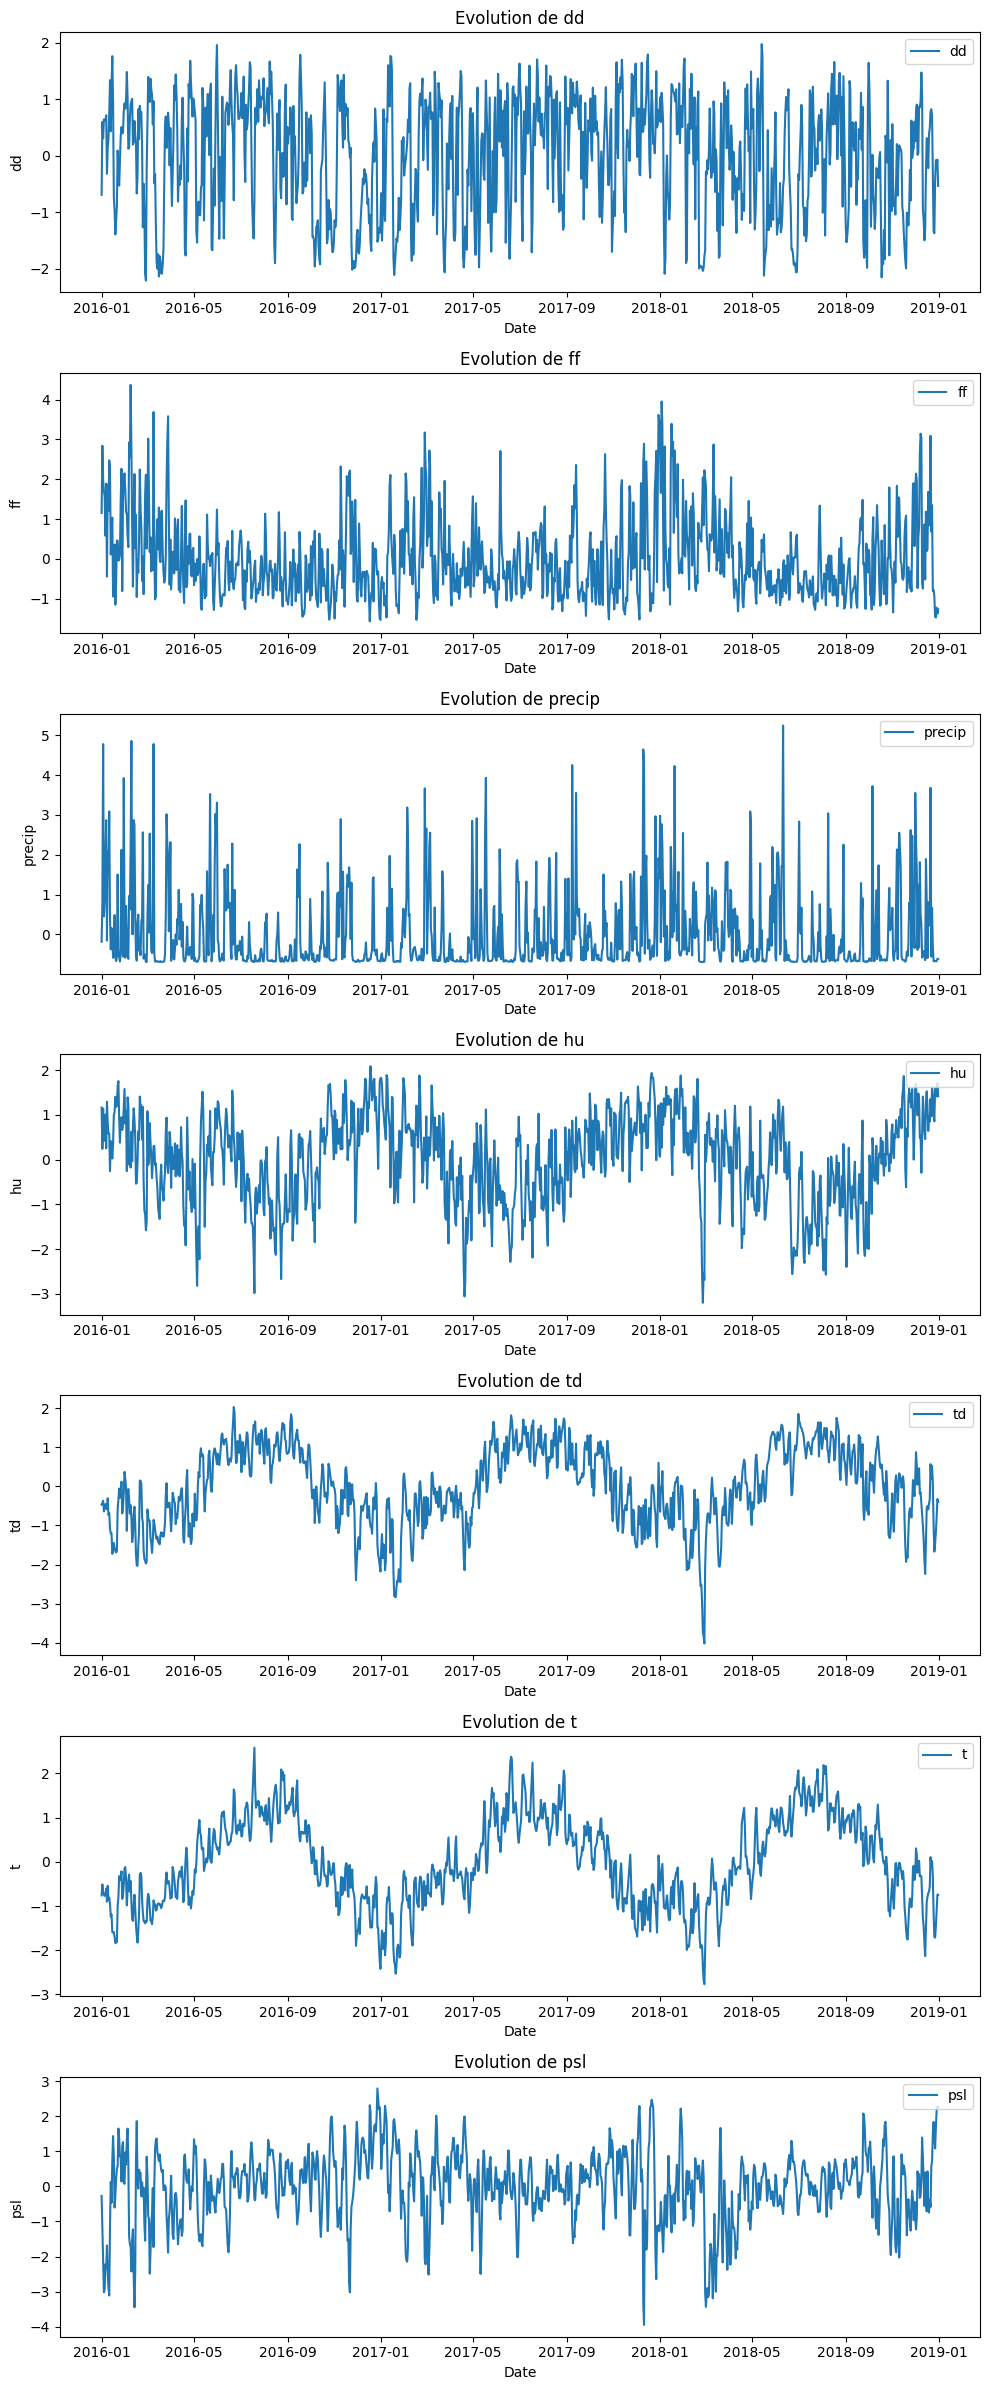

In [59]:
# Graphique pour chaque paramètre
plt.figure(figsize=(10,24))

for i, param in enumerate(weather_params, 1):
    plt.subplot(len(weather_params), 1, i)
    plt.plot(GOd_all_st.index, GOd_all_st[param], label=param)
    plt.title(f"Evolution de {param}")
    plt.xlabel("Date")
    plt.ylabel(param)
    plt.legend(loc="upper right")

# Ajuster la disposition des sous-graphiques
plt.tight_layout()
plt.show()

In [61]:
# Dans la suite, on définit GOf, 
# le dataframe final pré-traité prêt à être utilisé
GO_f = GOd_all_st.copy()

<span style = "color:blue"> **Conclusion de la partie II. :** ainsi, dan cette partie, on a réalisé un traitement des données sur les paramètres pertinents, à savoir ceux définis comme étant météorologiques. <br>
On a tenté de traiter les valeurs manquantes par deux méthodes : interpolation et binning. Le binning offrant plus de robustesse, il a été privilégié. On a également standardiser les données afin de facilieter leur utilisation. On a également définis des pipeline, utile pour l'analyse.

<span style = "color:blue"> Enfin, on définit un jeu de données pré-traité, qu'on utilise pour la modélisation, et qu'on appelle : **GO_f**.

# III. Sélection de variables et modèles

<span style = "color:magenta"> Dans cette partie, on souhaite identifier les variables pertinentes pour les modèles, ie. lesquelles apportent le plus d'information, afin de faciliter le traitement lors de l'apprentissage et diminuer les risques de sur-apprentissage.

In [62]:
# Vérification du jeu de données utilisé
GO_f.head()

number_sta        lat       lon  height_sta        dd        ff  \
date                                                                            
2016-01-01  4.863150e+07  48.029404 -0.557978  105.742683 -0.694240  1.151828   
2016-01-02  4.883583e+07  48.021167 -0.597521  104.755942  0.595471  2.840013   
2016-01-03  4.884368e+07  48.021820 -0.598103  104.689495  0.303834  1.980012   
2016-01-04  4.860577e+07  48.034724 -0.616295  104.622844  0.640049  1.717028   
2016-01-05  4.857767e+07  48.041833 -0.616962  104.721234  0.628843  1.563639   

              precip        hu        td         t       psl  
date                                                          
2016-01-01 -0.187848  1.160691 -0.463506 -0.758643 -0.272202  
2016-01-02  0.776104  0.239709 -0.430988 -0.511557 -1.201039  
2016-01-03  4.779391  1.140337 -0.367466 -0.689004 -2.227472  
2016-01-04  0.447764  0.413725 -0.638590 -0.740218 -3.015837  
2016-01-05  0.870018  0.794003 -0.557475 -0.770013 -2.929461

## III. A. Observations des corrélations : en fonction de la pluie.

<span style = "color:magenta">  Dans cette introduction, on comme par observer les correlations entre les variables.

<span style = "color:magenta">  D'abord on observe et on représente en fonction d'un paramètre qu'on peut considérer important : la pluie. Dans un second temps, on trace une matrice de covariance.

In [63]:
# Calcul des corrélations entre la variable 'precip' et les autres variables
correlations_precip = GO_f.corr()['precip'].sort_values(ascending=False)

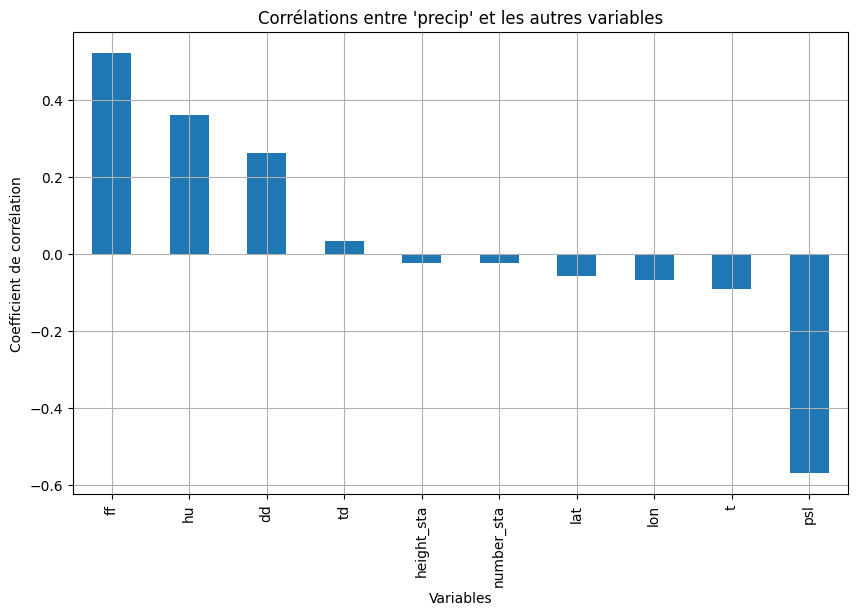

In [64]:
# Tracer les corrélations en barres
correlations_precip.drop('precip').plot(kind='bar', figsize=(10, 6))
plt.title("Corrélations entre 'precip' et les autres variables")
plt.xlabel("Variables")
plt.ylabel("Coefficient de corrélation")
plt.grid()
plt.show()

## III. A. 1. Observations des corrélations : matrice de covariance

<span style = "color:magenta">  Les résultats pour cette matrice de covariance sont peu concluants...

In [65]:
# Calcul de la matrice de convariance des paramètres de GO_f
covariance_matrix = GO_f.cov()

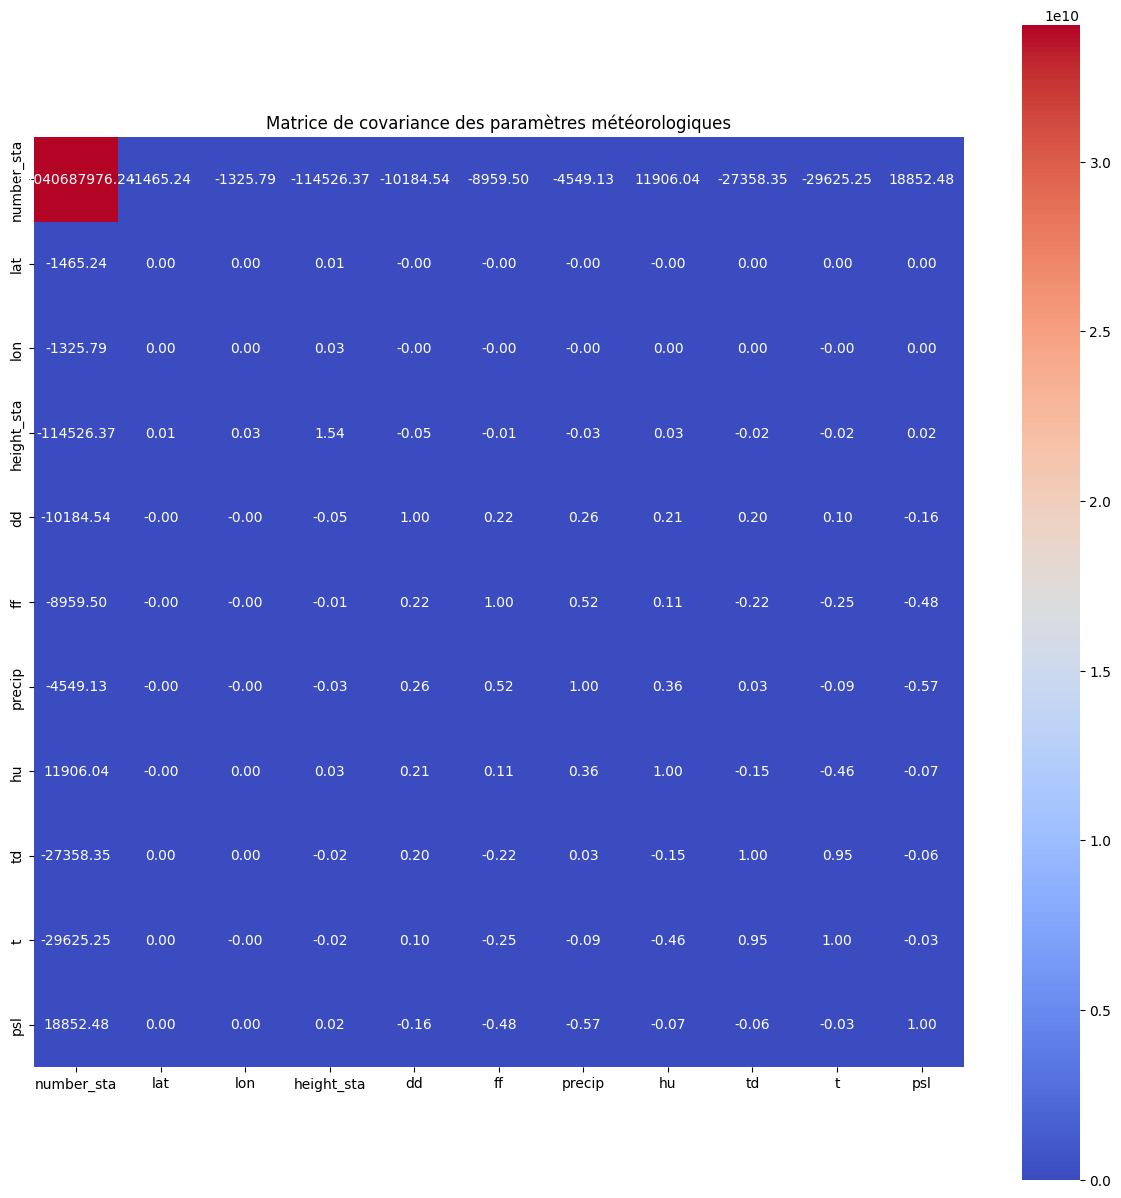

In [66]:
# Visualisation de la matrice de covariance
plt.figure(figsize = (15,15))
sns.heatmap(covariance_matrix, annot = True, fmt = ".2f", cmap = "coolwarm", square = True)
plt.title("Matrice de covariance des paramètres météorologiques")
plt.show()

## III. B Séparation en ensemble d'apprentissage et de test

<span style = "color:magenta"> Dans cette partie, on réalise la séparation du jeu de données d'entrainement et de test.

<span style = "color:magenta">  On propose la séparation suivante : les deux premières années, 2016 et 2017 permettront l'entrainement du modèle. L'année 2018 pourra servir à la prédiction et au test.

In [67]:
# Véricifation du jeu de données utilisé
GO_f.head(3)

number_sta        lat       lon  height_sta        dd        ff  \
date                                                                            
2016-01-01  4.863150e+07  48.029404 -0.557978  105.742683 -0.694240  1.151828   
2016-01-02  4.883583e+07  48.021167 -0.597521  104.755942  0.595471  2.840013   
2016-01-03  4.884368e+07  48.021820 -0.598103  104.689495  0.303834  1.980012   

              precip        hu        td         t       psl  
date                                                          
2016-01-01 -0.187848  1.160691 -0.463506 -0.758643 -0.272202  
2016-01-02  0.776104  0.239709 -0.430988 -0.511557 -1.201039  
2016-01-03  4.779391  1.140337 -0.367466 -0.689004 -2.227472

In [68]:
# Extraction de l'année à partir de l'index
GO_f['year'] = GO_f.index.year

# Séparation des données en fonction de l'année
GO12_f = GO_f[GO_f['year'].isin([2016, 2017])]  # Données des années 2016 et 2017
GO3_f = GO_f[GO_f['year'] == 2018]  # Données de l'année 2018

In [69]:
# Vérification de la séparation
print("Données 2016-2017 :")
print(GO12_f.head(3),
      GO12_f.shape)

Données 2016-2017 :
              number_sta        lat       lon  height_sta        dd        ff  \
date                                                                            
2016-01-01  4.863150e+07  48.029404 -0.557978  105.742683 -0.694240  1.151828   
2016-01-02  4.883583e+07  48.021167 -0.597521  104.755942  0.595471  2.840013   
2016-01-03  4.884368e+07  48.021820 -0.598103  104.689495  0.303834  1.980012   

              precip        hu        td         t       psl  year  
date                                                                
2016-01-01 -0.187848  1.160691 -0.463506 -0.758643 -0.272202  2016  
2016-01-02  0.776104  0.239709 -0.430988 -0.511557 -1.201039  2016  
2016-01-03  4.779391  1.140337 -0.367466 -0.689004 -2.227472  2016   (731, 12)


In [70]:
print("\nDonnées 2018 :")
print(GO3_f.head(3),
      GO3_f.shape)


Données 2018 :
              number_sta        lat       lon  height_sta        dd        ff  \
date                                                                            
2018-01-01  4.823914e+07  48.060530 -0.539453  108.242561  1.029510  2.947942   
2018-01-02  4.810700e+07  48.063123 -0.548482  107.350789  0.593883  1.655744   
2018-01-03  4.812367e+07  48.060367 -0.558279  107.266389  1.112108  3.950450   

              precip        hu        td         t       psl  year  
date                                                                
2018-01-01  2.976971  0.063574 -0.649938 -0.654774 -1.046572  2018  
2018-01-02 -0.196481  1.258565 -0.017727 -0.416228 -0.442929  2018  
2018-01-03  2.766340  0.268691 -0.126458 -0.237448 -0.926062  2018   (365, 12)


<span style = "color:magenta">  Un paramètre important à observer ici sont les dimensions, et plus précisemment le nombre d'exemple considérés dans chaque ensemble. <br>
Ici, on observe 731 données pour le jeu d'entrainement et 365 pour le jeu de test. La séparation contient suffisament d'exemples.

## III. C. Usage d'une méthode wrapper pour identifier les variables pertinentes avec un modèle simple non paramètrique (RandomForestRegressor) et prévisions

<span style = "color:magenta"> Dans cette partie, plusieurs traitement sont réalisés.

<span style = "color:magenta"> D'abord, on recherche par une méthode "wrapper" les paramètres importants permettant une prédiction optimal en minimisant les risques de sur-apprentissage. Ce type de méthode est privilégié à des méthodes type reduction de dimension non supervisée, comme une analyse en composantes principales. En effet, bien que les ACPs soient puissantes, elles ne conservent pas les variables d'origines. Or, ces variables d'origines seront utilisés à la fois pour la préductions, ainsi que pour l'interprétabilité des résultats. Ainsi, l'ACPs ou des méthodes non linéaires type t-sne, ne seront pas privilégiées ici. 

<span style = "color:magenta">  Une fois les paramètres identifées, on tentera d'utiliser plusieurs modèles pour la prédictions.

### III. C. 1. Usage de SequentialFeatureSelector et d'un modèle RFG pour identifier les variables importantes.

<span style = "color:magenta"> Ici, comme expliqué précédemment, on se situe dans une problématique de prévisions de séries temporelles multi-variées.

<span style = "color:magenta"> Afin de permettre aux outils que l'on possède de fonctionner, c'est à dire de prédire à un pas de temps t+n, on a besoin des données antérieurs des paramètres. Pour les observer, on introduit un lag, correspondant au pas de temps antérieur utiliser pour les prévisions. On prend dans un premier temps un lag de 7 (ici 7 jours, car les données sont séparées dans notre tableau d'origine pas des jours.) Ces lags sont concaténés dans un tableau. C'est sur ces lags (paramètres + pas de temps du lag) que la méthode wrapper opère.

In [71]:
# Définition du nombre de lags
n_lags = 7  # On prends 7 jours

In [72]:
# Définition du modèle de forêt aléatoire et d'une régression linéaire pour la séléction des lags
model_lr = LinearRegression()
model_rf = RandomForestRegressor(max_depth=5, n_estimators=10)

In [73]:
# Création de lags pour chaque variable de weather_parameters
lagged_GO12= GO12_f.copy()
for lag in range(1, n_lags + 1):
    for param in weather_params:
        lagged_GO12[f"{param}_lag_{lag}"] = GO12_f[param].shift(lag)

# Supprime les lignes avec des NaN générés par les décalages
lagged_GO12 = lagged_GO12.dropna()

# Définition des variables explicatives (colonnes avec les lags) et les cibles (valeurs actuelles)
X_sfs = lagged_GO12[[f"{param}_lag_{lag}" for param in weather_params for lag in range(1, n_lags + 1)]]
Y_sfs = lagged_GO12[weather_params]

In [74]:
# Division du dataset en ensembles d'entraînement et de test
Xsfs_train, Xsfs_test, Ysfs_train, Ysfs_test = train_test_split(
    X_sfs, Y_sfs, test_size = 0.3, random_state = 0)

In [75]:
# Utiliser le SequentialFeatureSelector pour sélectionner les lags les plus pertinents
sfs = SequentialFeatureSelector(
    model_rf, # Modèle de forêt aléatoire utilisé ici
    n_features_to_select="auto",
    direction="forward",
    scoring="neg_mean_squared_error",
    cv=5
)

# Exécuter la sélection de variables
sfs.fit(Xsfs_train, Ysfs_train)

SequentialFeatureSelector(estimator=RandomForestRegressor(max_depth=5,
                                                          n_estimators=10),
                          scoring='neg_mean_squared_error')

In [76]:
# Visualisation des lags sélectionnés
selected_lags = X_sfs.columns[sfs.get_support()]

print("Variables (lags) sélectionnées : ", list(selected_lags))

Variables (lags) sélectionnées :  ['dd_lag_1', 'dd_lag_2', 'dd_lag_3', 'dd_lag_7', 'ff_lag_1', 'ff_lag_2', 'ff_lag_5', 'precip_lag_1', 'precip_lag_3', 'precip_lag_5', 'hu_lag_1', 'hu_lag_7', 'td_lag_1', 'td_lag_2', 'td_lag_7', 't_lag_1', 't_lag_2', 't_lag_3', 't_lag_5', 't_lag_6', 'psl_lag_1', 'psl_lag_2', 'psl_lag_5', 'psl_lag_7']


### II. C. 2. Comparaison des performances du modèles avec l'ajout de dimension (ie. ajout du nombre de lags)

<span style = "color:magenta"> Dans cette sous-parties, on compare les perfomances d'un modèle sur l'ensemble des données, et sur les données séléctionné par SFS. On oobserve tout d'abord les premiers résultats d'un modèle de régression linéaire. En moyenne l'écart au valeurs réelles et donc d'environ un demi écart-type, ce que l'on peut considéré comme correct pour un premier modèle. De plus, on observe que les perfomances du modèles sont meilleurs pour les lags séléctionnées par SFS. Ces lags seront donc privilégiés dans la suite de l'étude.

In [77]:
# Validation croisée avec les lags sélectionnés par SFS
cv_score_sfs = cross_val_score(model, Xsfs_train[selected_lags], Ysfs_train, scoring="neg_mean_squared_error", cv=5)

# Validation croisée avec tous les lags**
cv_score_all_lags = cross_val_score(model, Xsfs_train, Ysfs_train, scoring="neg_mean_squared_error", cv=5)

# Afficher les résultats
print(f"Validation croisée - SFS (lags sélectionnés) : Moyenne = {cv_score_sfs.mean():.4f}, Écart-type = {cv_score_sfs.std():.4f}")
print(f"Validation croisée - Tous les lags : Moyenne = {cv_score_all_lags.mean():.4f}, Écart-type = {cv_score_all_lags.std():.4f}")


Validation croisée - SFS (lags sélectionnés) : Moyenne = -0.3891, Écart-type = 0.0470
Validation croisée - Tous les lags : Moyenne = -0.4122, Écart-type = 0.0556


### III. C. 3. Prévisions via XGBoost

<span style = "color:magenta"> Dans cette partie, on propose un premier modèle pour réaliser la prédiction des séries temporelles multivariées. <br>
On choisit une méthode ensembliste puissante type XGBoost adapté à la régression. On garde à l'esprit que ce type de modèle n'est pas initiallement adapté aux données indexées sur le temps.

### III. C. 3. a. Récupération du dataset complet des 3 ans

In [78]:
# Vérification des données utilisées.
GO_f.head(3)

number_sta        lat       lon  height_sta        dd        ff  \
date                                                                            
2016-01-01  4.863150e+07  48.029404 -0.557978  105.742683 -0.694240  1.151828   
2016-01-02  4.883583e+07  48.021167 -0.597521  104.755942  0.595471  2.840013   
2016-01-03  4.884368e+07  48.021820 -0.598103  104.689495  0.303834  1.980012   

              precip        hu        td         t       psl  year  
date                                                                
2016-01-01 -0.187848  1.160691 -0.463506 -0.758643 -0.272202  2016  
2016-01-02  0.776104  0.239709 -0.430988 -0.511557 -1.201039  2016  
2016-01-03  4.779391  1.140337 -0.367466 -0.689004 -2.227472  2016

In [79]:
GO_f.shape

(1096, 12)

### III. C. 3. b. Définition des ensembles d'apprentissage et de test

In [80]:
# Définition du nombre de lags
n_lags = 7  # On prend 7 jours

# Créer les lags pour chaque variable dans weather_parameters
lagged_GO12 = GO_f.copy()
for lag in range(1, n_lags + 1):
    for param in weather_params:
        lagged_GO12[f"{param}_lag_{lag}"] = GO_f[param].shift(lag)

# Supprimer les lignes avec des NaN générés par les décalages
lagged_GO12 = lagged_GO12.dropna()

# Créer une nouvelle colonne 'year' pour séparer les années 2016-2017 et 2018
lagged_GO12['year'] = lagged_GO12.index.year

# Séparer les données d'entraînement (2016-2017) et de test (2018)
train_data = lagged_GO12[lagged_GO12['year'].isin([2016, 2017])]
test_data = lagged_GO12[lagged_GO12['year'] == 2018]

# Variables explicatives (lags) et cibles (variables actuelles)
X_train = train_data[[f"{param}_lag_{lag}" for param in weather_params for lag in range(1, n_lags + 1)]]
Y_train = train_data[weather_params]
X_test = test_data[[f"{param}_lag_{lag}" for param in weather_params for lag in range(1, n_lags + 1)]]
Y_test = test_data[weather_params]

### III. C. 3. c. Premier modèle via XGBoost

In [81]:
# Définition du modèle
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=0) # Random state pour la reproductivilité du modèle

# Créer et entraîner le modèle avec les lags sélectionnés
model_xgb.fit(X_train[selected_lags], Y_train)

# Prédire sur l'ensemble de test avec les lags sélectionnés
Y_pred = model_xgb.predict(X_test[selected_lags])

# Calculer l'erreur moyenne (MSE) sur l'ensemble de test pour chaque variable
mse = mean_squared_error(Y_test, Y_pred)
print(f"MSE moyenne sur l'ensemble de test : {mse}")


MSE moyenne sur l'ensemble de test : 0.49419791286900683


In [82]:
# Calculer le MSE pour chaque variable cible
mse_per_variable = {}
for i, param in enumerate(weather_params):
    mse_per_variable[param] = mean_squared_error(Y_test[param], Y_pred[:, i])

# Afficher les résultats du MSE pour chaque variable
for param, mse_value in mse_per_variable.items():
    print(f"MSE pour {param} : {mse_value:.4f}")

MSE pour dd : 0.6098
MSE pour ff : 0.8286
MSE pour precip : 0.9543
MSE pour hu : 0.3930
MSE pour td : 0.1957
MSE pour t : 0.1382
MSE pour psl : 0.3398


<span style = "color:magenta"> Résultats de ce premier modèle ensembliste : <br>
- <span style = "color:magenta"> De manière générale, on observe que la moyenne d'erreur est d'environ, à nouveau, un demi écart type. Le modèle XGBoost de régression est donc aussi précis que les modèles utilisés précédemment. <br>
- <span style = "color:magenta"> De plus, on observe de manière plus précise sur les paramètres, des disparités dans la pertinence des prévisions des paramètres. Des paramètres semblent bien prédits : t, td, hu, psl, alors que d'autres montrent une tendance plus de difficile à capturer par le modèle : dd, ff, ou encore precip. 


### III. C. 3. d. Recherche des hyper-paramètres optimaux via GridSearch

<span style = "color:magenta">  On recherche les hyper-paramètres optimaux par Grid Search, et on les intégrent à un modèle pour la prévisions :

In [83]:
# Définir la grille de paramètres à tester
param_grid = {
    'n_estimators': [200, 500, 1000],  # Nombre d'arbres
    'max_depth': [3, 10, 20],           # Profondeur des arbres
    'learning_rate': [0.01, 0.1, 0.2] # Taux d'apprentissage
}

# Créer un GridSearchCV pour tester différentes combinaisons de paramètres
grid_search = GridSearchCV(estimator=model_xgb,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # Mesure de performance
                           cv=3,  # Validation croisée avec 5 folds
                           verbose=1,  # Afficher des informations pendant l'exécution
                           n_jobs=-1)  # Utiliser tous les cœurs du processeur

# Entraîner le GridSearchCV avec les données d'entraînement
grid_search.fit(X_train[selected_lags], Y_train)

# Afficher les meilleurs paramètres et le score de validation croisée
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score de validation (neg_mean_squared_error) : {grid_search.best_score_}")

# Récupérer le meilleur modèle trouvé
best_model = grid_search.best_estimator_

# Prédire sur l'ensemble de test
Y_pred = best_model.predict(X_test[selected_lags])

# Calculer l'erreur (MSE) sur l'ensemble de test
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)
print(f"MSE pour chaque variable sur l'ensemble de test : {mse}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Meilleurs paramètres : {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Meilleur score de validation (neg_mean_squared_error) : -0.4354628504698594
MSE pour chaque variable sur l'ensemble de test : 0.4275349951849825


### III. C. 3. e. Visualisation des prédicions pour des durée de temps différentes

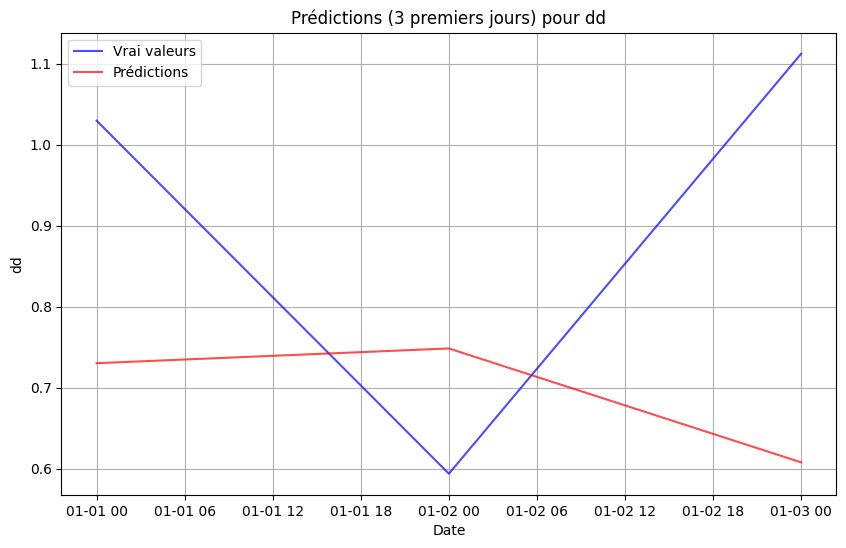

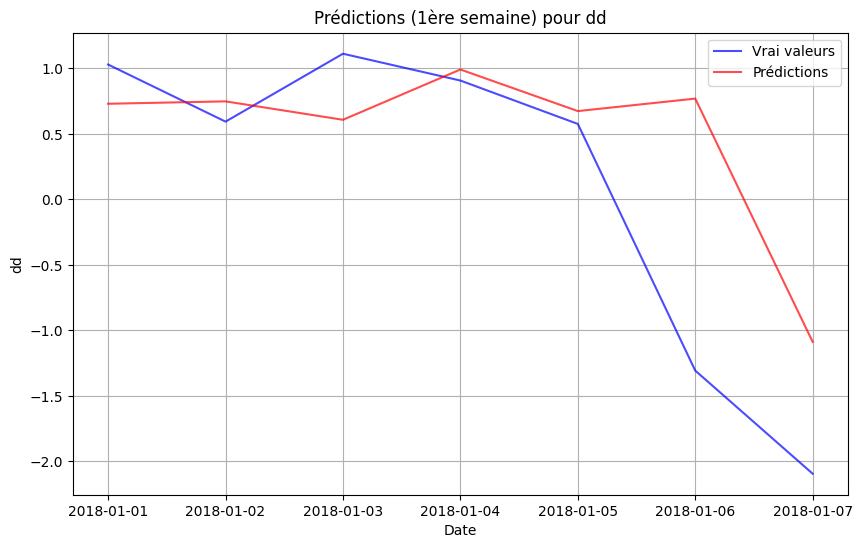

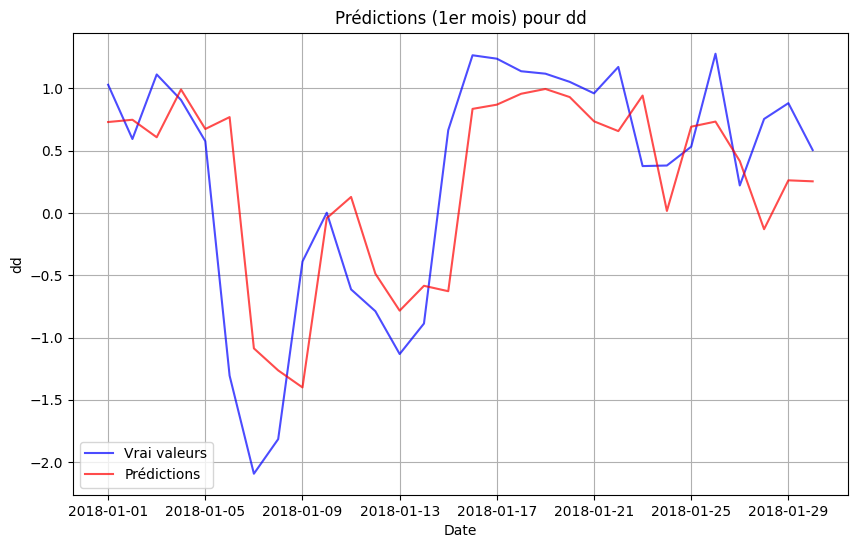

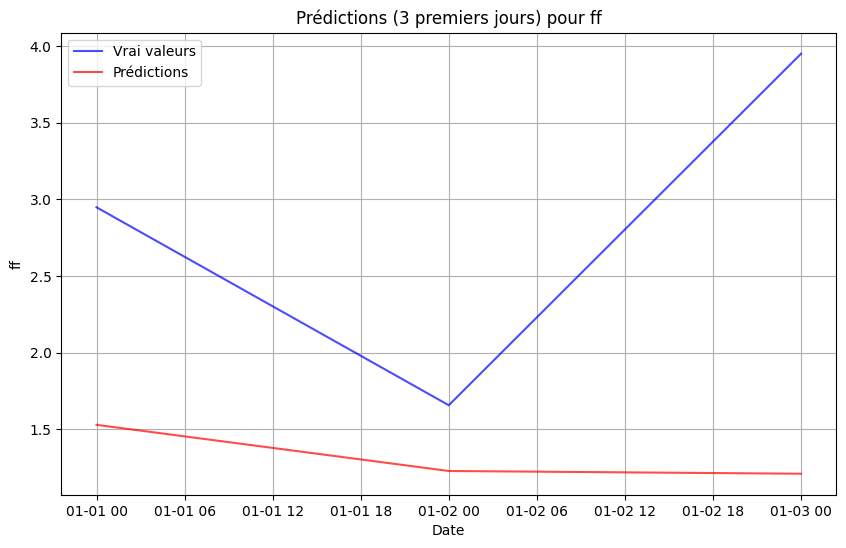

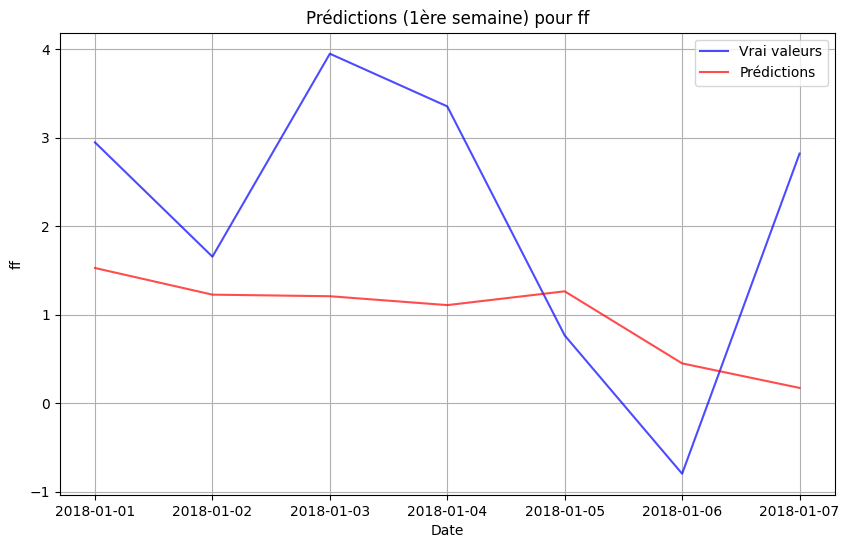

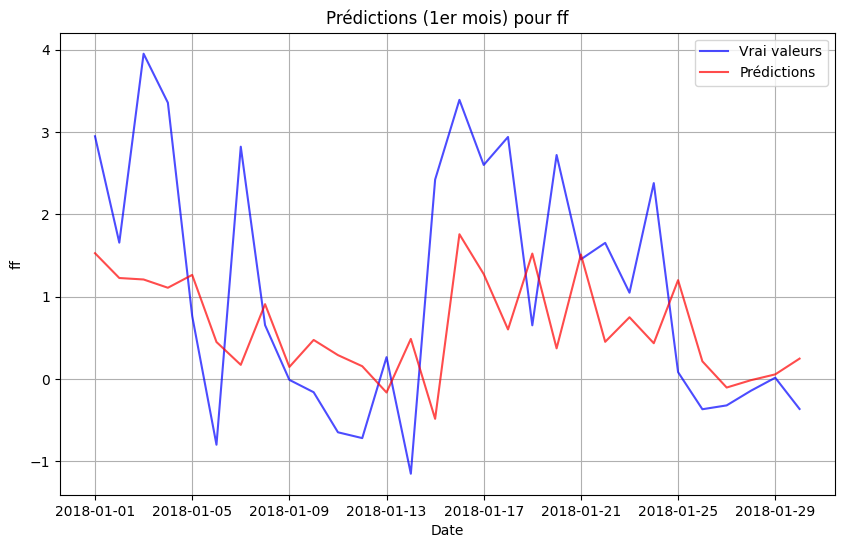

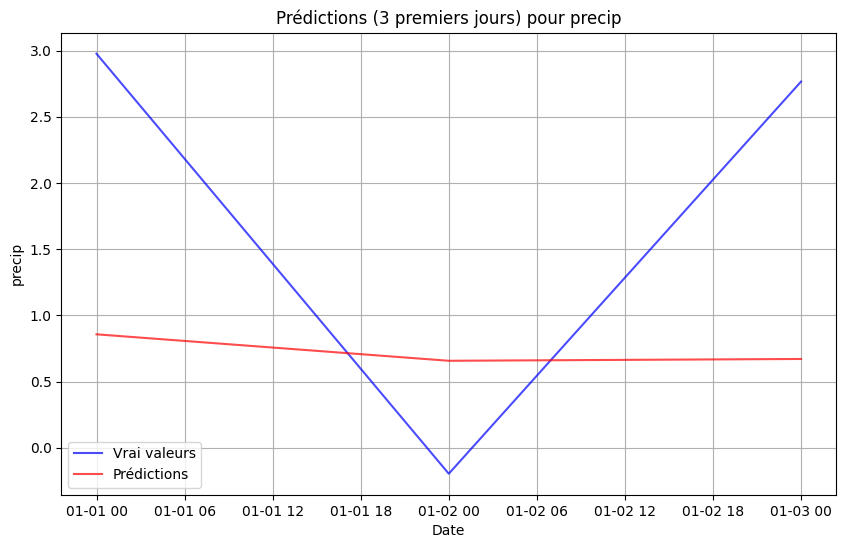

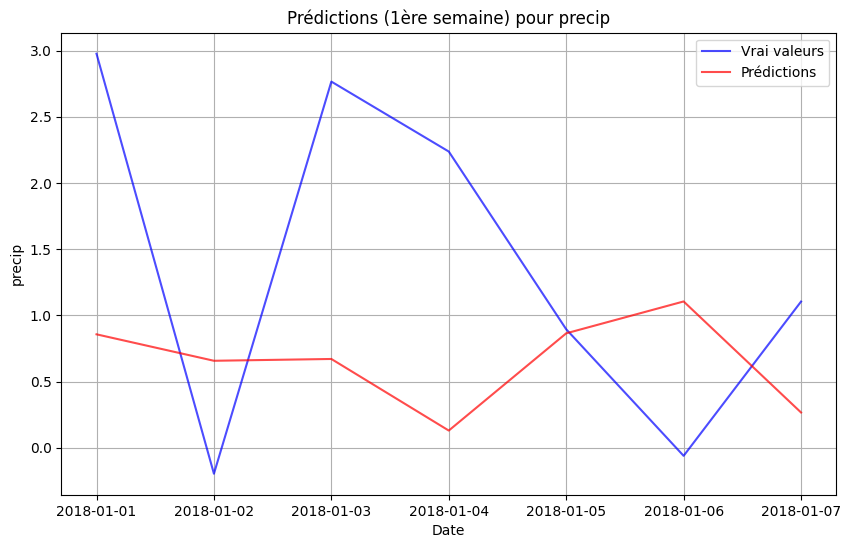

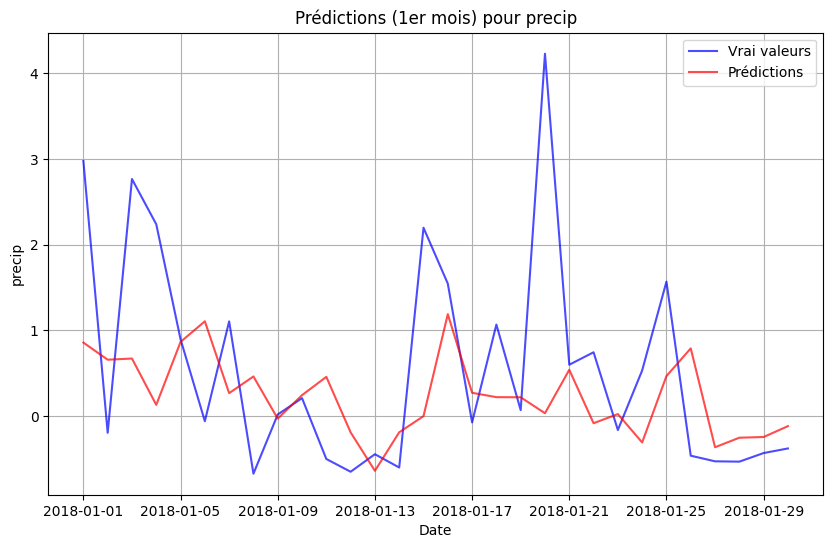

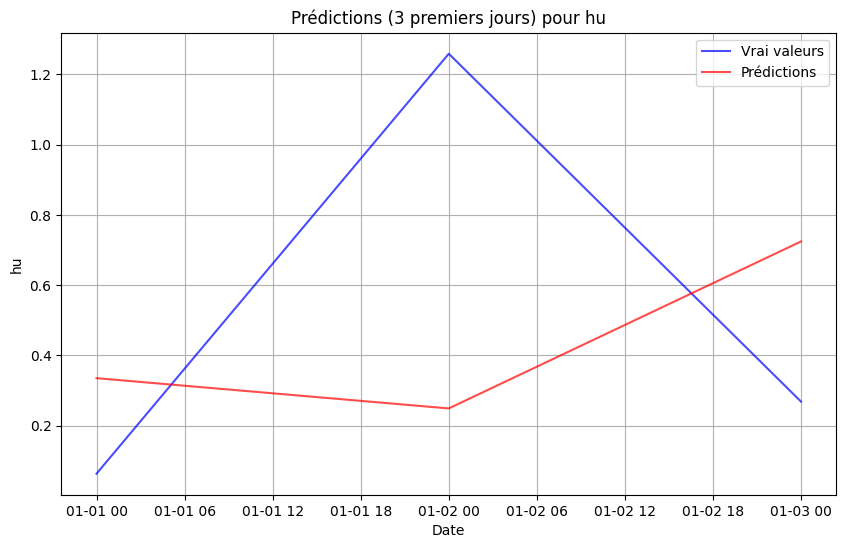

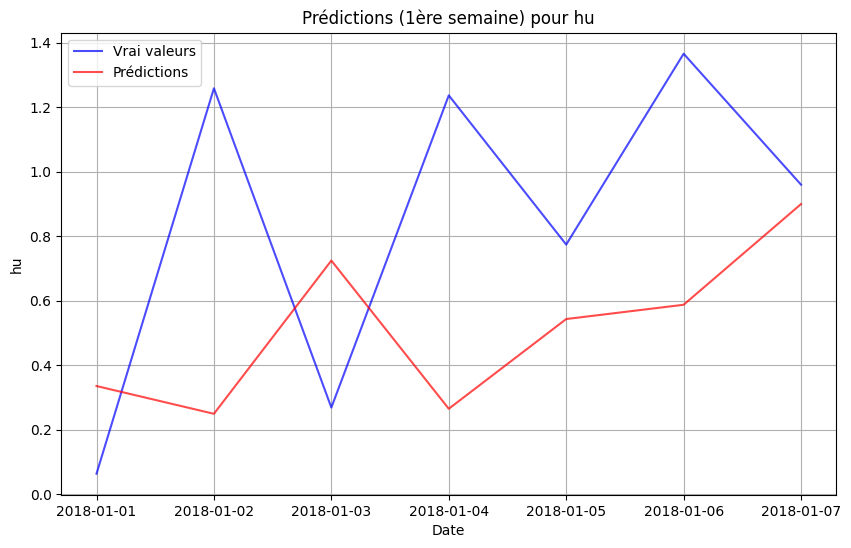

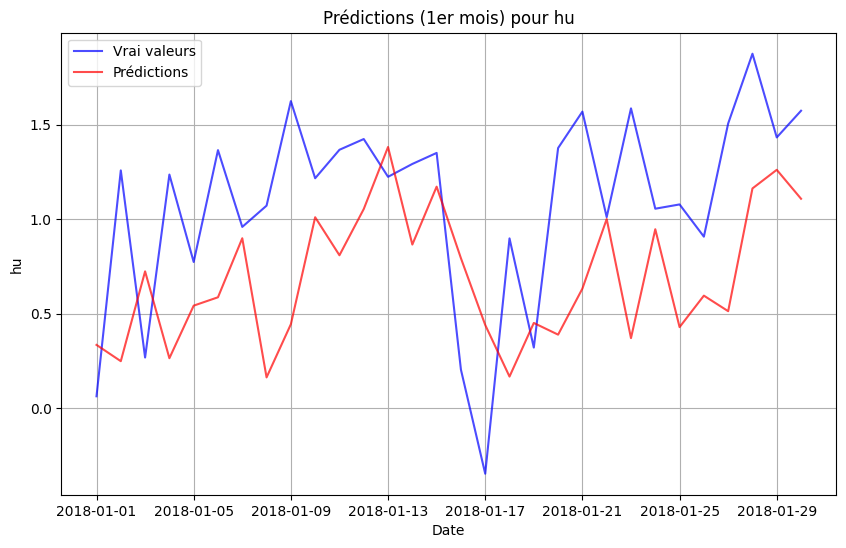

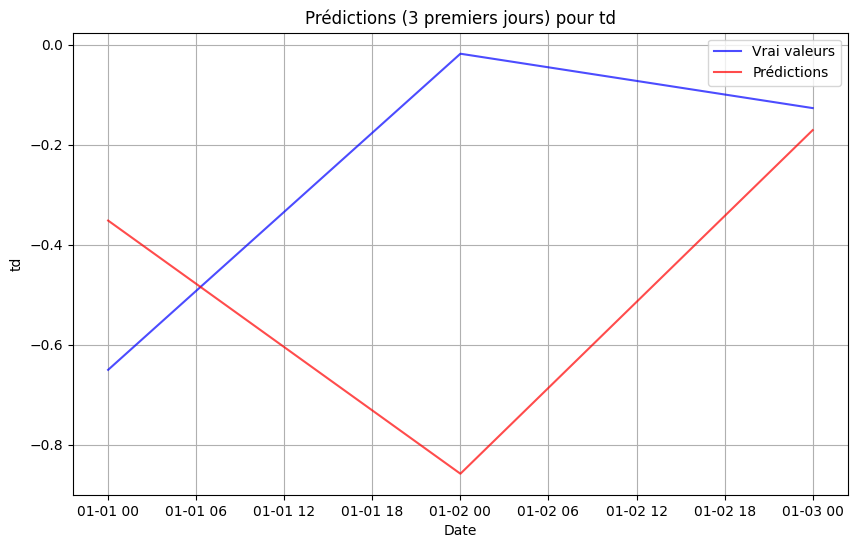

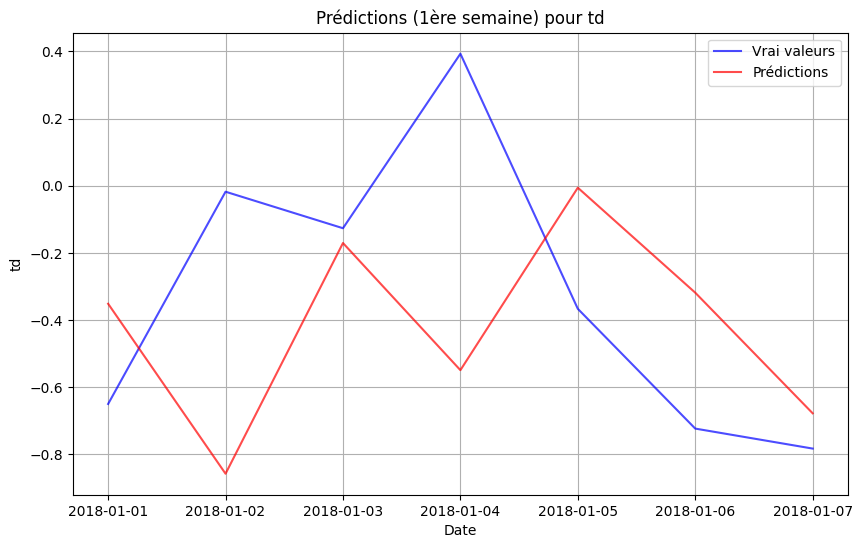

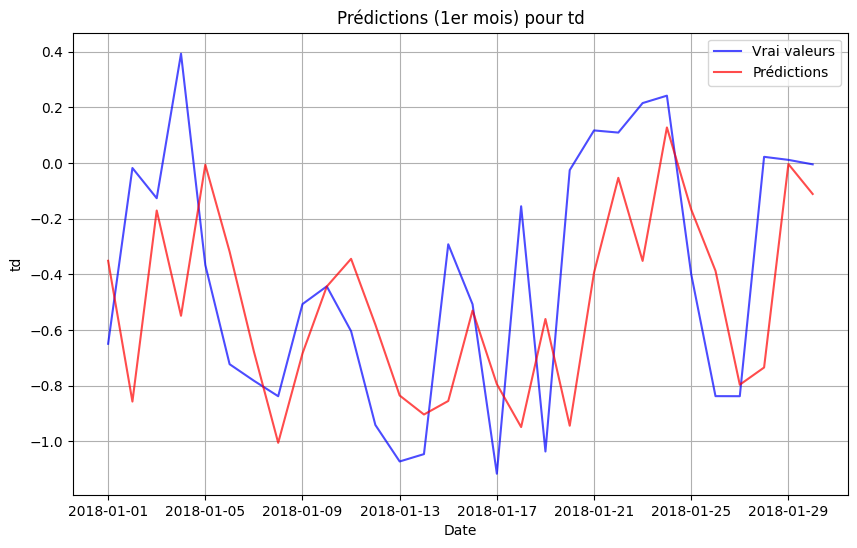

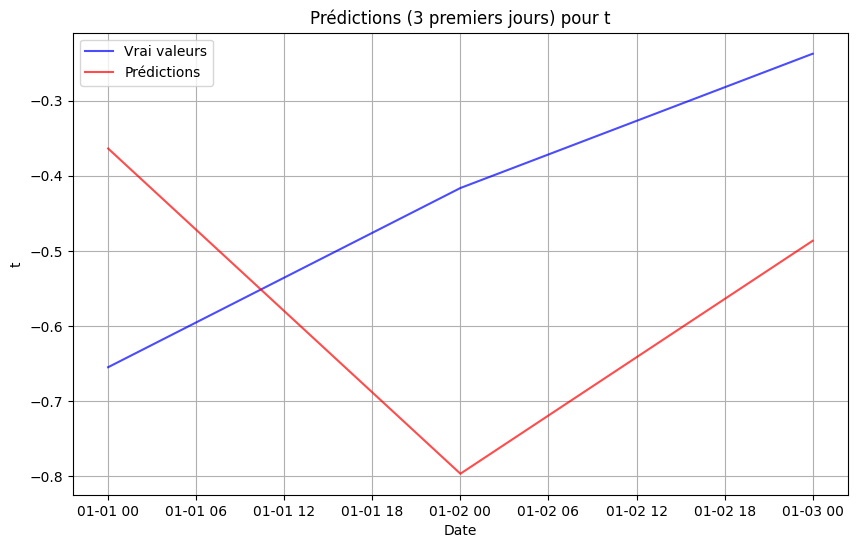

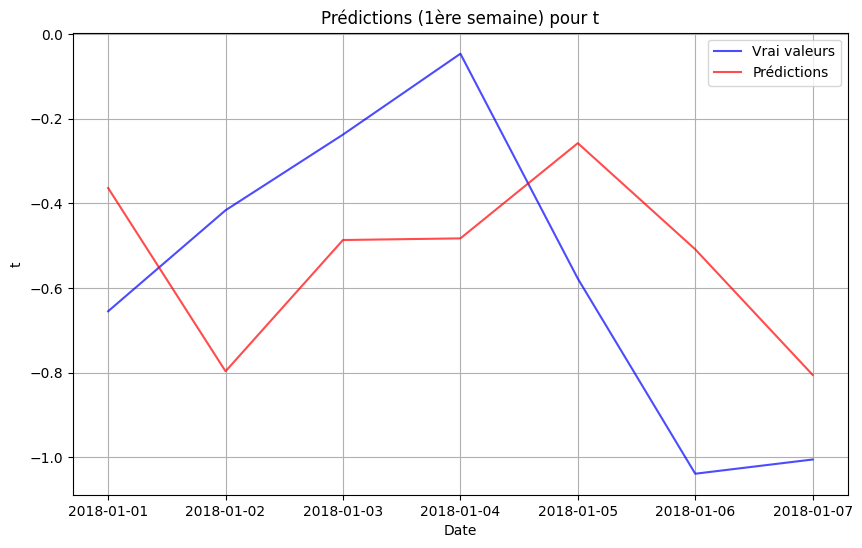

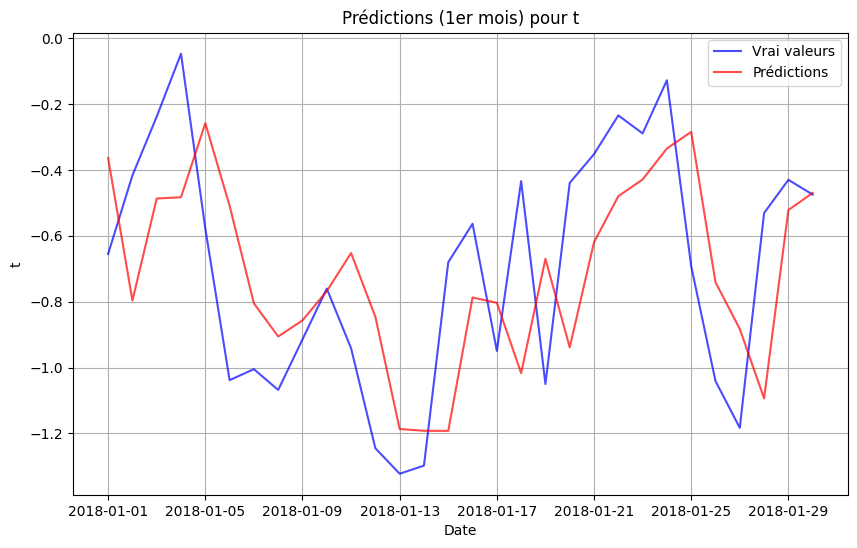

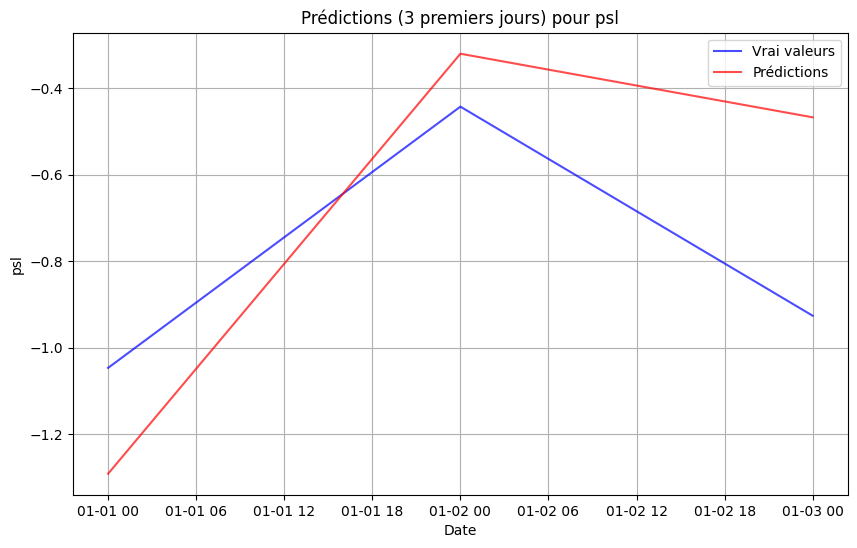

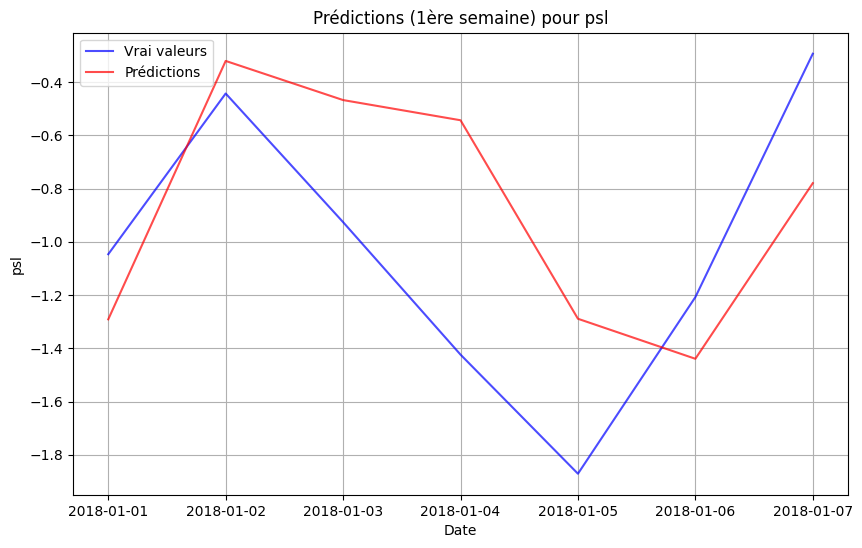

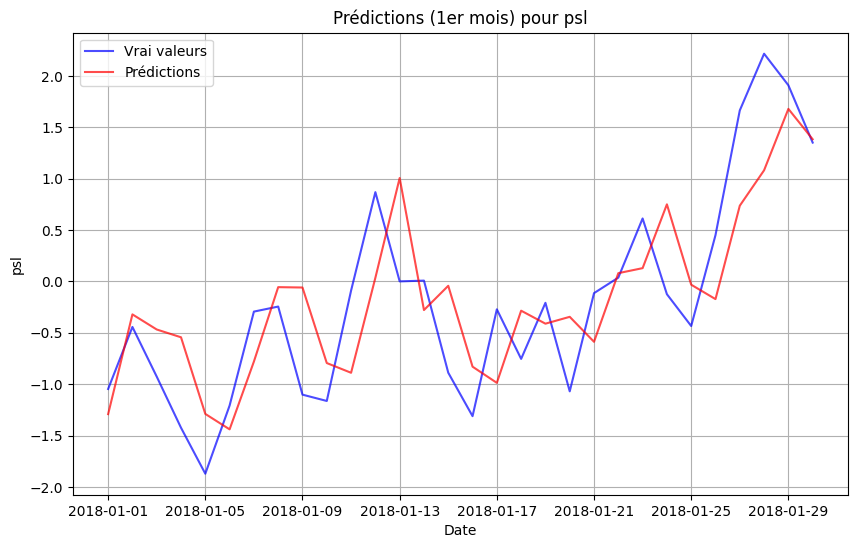

In [ ]:
# Meilleur modèle du GridSearch
best_model = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=500)
best_model.fit(X_train[selected_lags], Y_train)

# Prédictions du modèle sur l'ensemble de test
Y_pred = best_model.predict(X_test[selected_lags])

# Fonction pour extraire les périodes
def extract_periods(y_test, period='3_days'):
    if period == '3_days':
        return y_test[:3]
    elif period == '1_week':
        return y_test[:7]
    elif period == '1_month':
        return y_test[:30]  # Ajuste selon le nombre de jours dans un mois
    else:
        return y_test

# Extraire les périodes
Y_test_3_days = {param: extract_periods(Y_test[param], '3_days') for param in weather_params}
Y_test_1_week = {param: extract_periods(Y_test[param], '1_week') for param in weather_params}
Y_test_1_month = {param: extract_periods(Y_test[param], '1_month') for param in weather_params}

# Prédictions sur les différentes périodes
Y_pred_3_days = {param: Y_pred[:, i][:3] for i, param in enumerate(weather_params)}
Y_pred_1_week = {param: Y_pred[:, i][:7] for i, param in enumerate(weather_params)}
Y_pred_1_month = {param: Y_pred[:, i][:30] for i, param in enumerate(weather_params)}

# Fonction pour visualiser les prédictions sans intervalles de confiance pour chaque paramètre
def plot_predictions(param, Y_test, Y_pred, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test.index, Y_test, label='Vrai valeurs', color='blue', alpha=0.7)
    plt.plot(Y_test.index, Y_pred, label='Prédictions', color='red', alpha=0.7)
    plt.title(f'{title} pour {param}')
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    plt.show()

# Visualisation des résultats pour chaque période et chaque paramètre
for param in weather_params:
    plot_predictions(param, Y_test_3_days[param], Y_pred_3_days[param], 'Prédictions (3 premiers jours)', param)
    plot_predictions(param, Y_test_1_week[param], Y_pred_1_week[param], 'Prédictions (1ère semaine)', param)
    plot_predictions(param, Y_test_1_month[param], Y_pred_1_month[param], 'Prédictions (1er mois)', param)


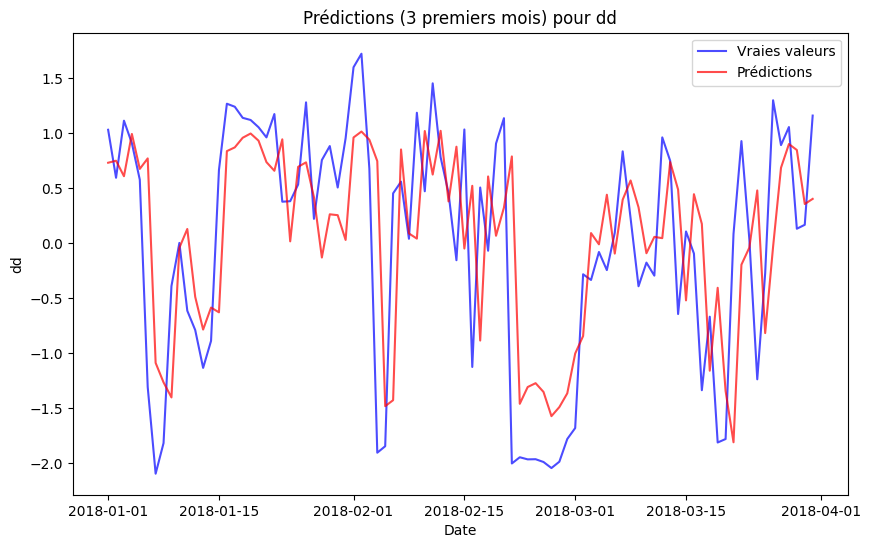

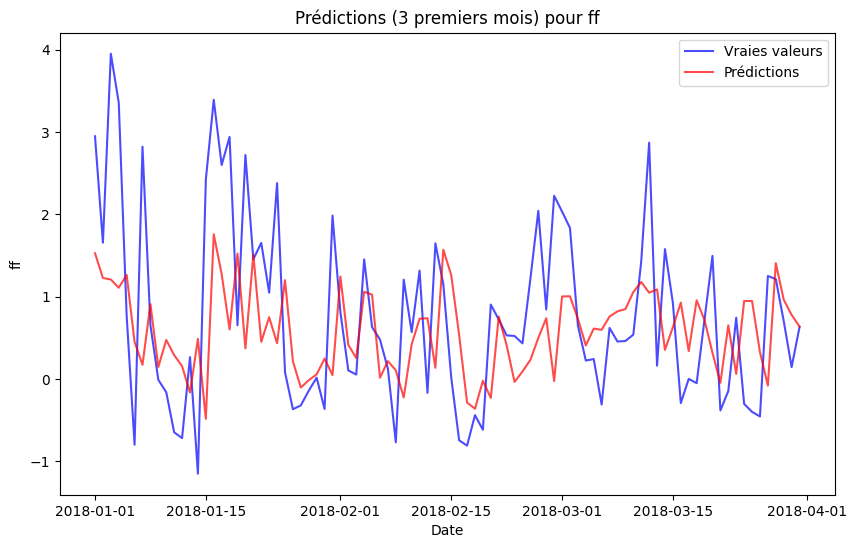

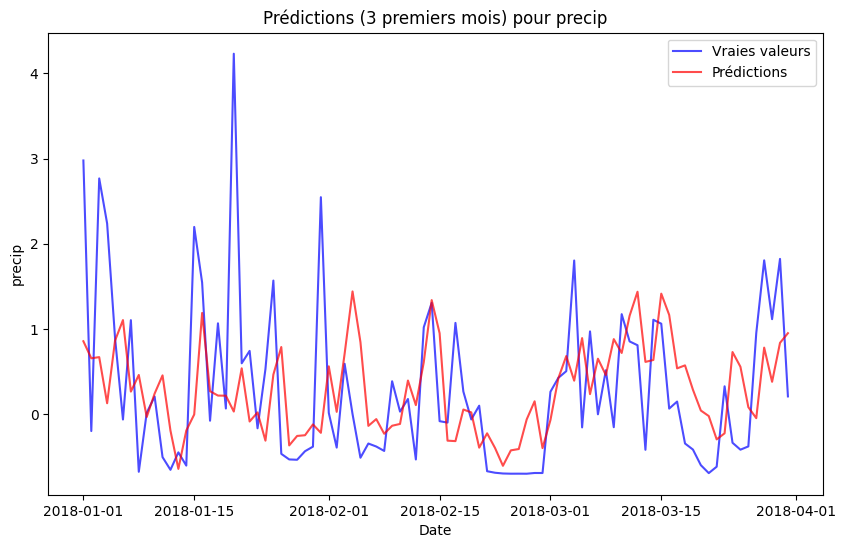

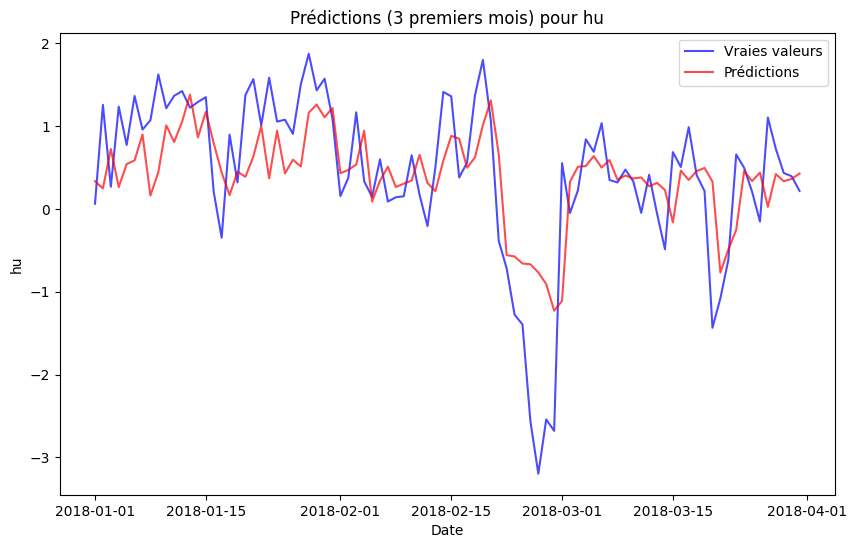

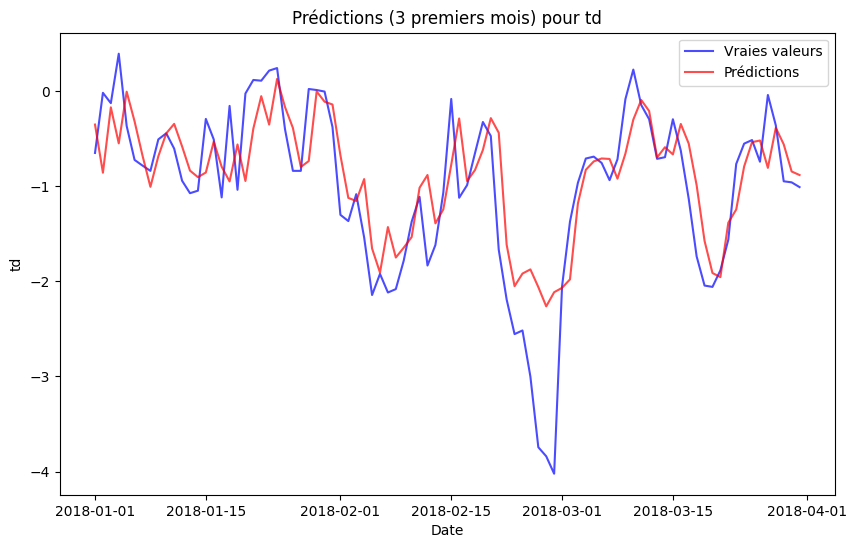

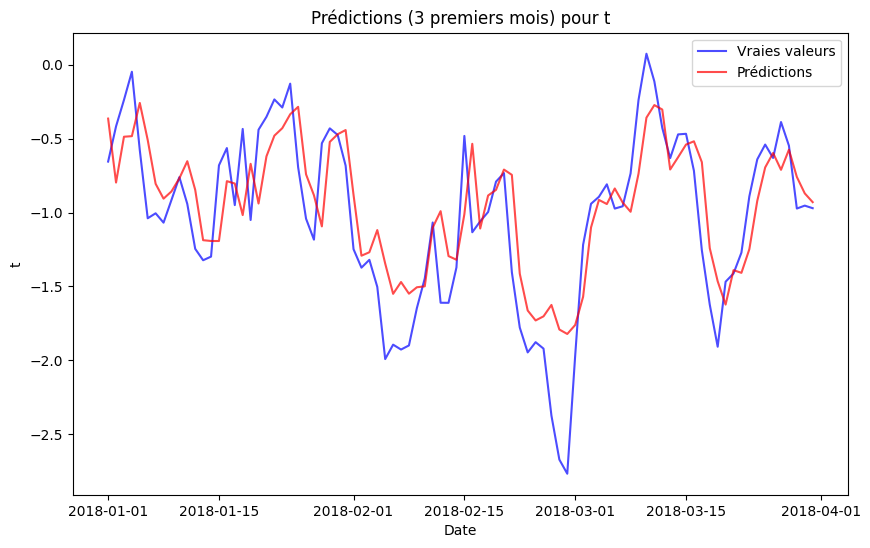

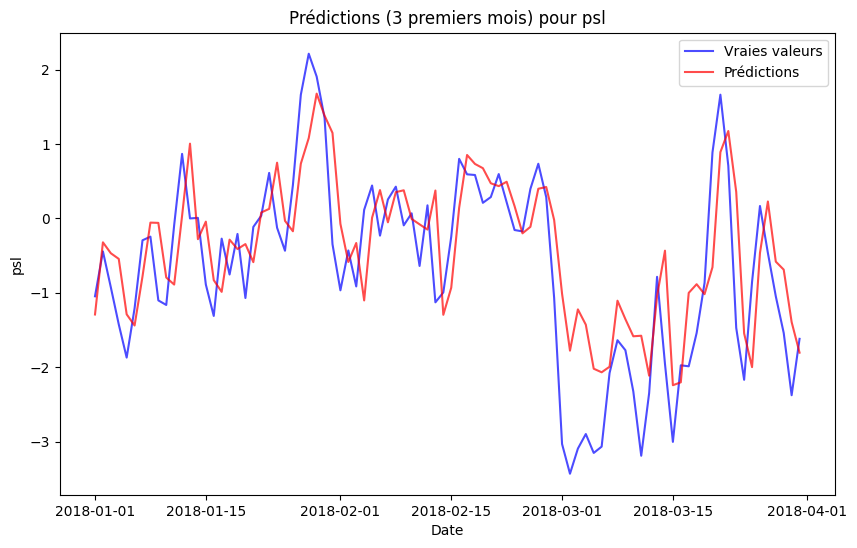

In [ ]:
# Meilleur modèle du GridSearch
best_model = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=500)
best_model.fit(X_train[selected_lags], Y_train)

# Prédictions du modèle sur l'ensemble de test
Y_pred = best_model.predict(X_test[selected_lags])

# Fonction pour extraire les 3 premiers mois
def extract_periods_3_months(y_test):
    return y_test[:90]  # Ajuste le nombre de jours pour correspondre à 3 mois (approximativement 90 jours)

# Extraire les vraies valeurs pour les 3 premiers mois
Y_test_3_months = {param: extract_periods_3_months(Y_test[param]) for param in weather_params}

# Prédictions pour les 3 premiers mois
Y_pred_3_months = {param: Y_pred[:, i][:90] for i, param in enumerate(weather_params)}

# Fonction pour visualiser les prédictions pour les 3 premiers mois pour chaque paramètre
def plot_predictions_3_months(param, Y_test, Y_pred, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test.index[:90], Y_test, label='Vraies valeurs', color='blue', alpha=0.7)
    plt.plot(Y_test.index[:90], Y_pred, label='Prédictions', color='red', alpha=0.7)
    plt.title(f'{title} pour {param}')
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Visualisation des résultats pour les 3 premiers mois pour chaque paramètre
for param in weather_params:
    plot_predictions_3_months(param, Y_test_3_months[param], Y_pred_3_months[param], 'Prédictions (3 premiers mois)', param)


<span style = "color:magenta">  **Conclusion de la pertinence pour un modèle de type XGBRegressor :** la visualisation des prédictions par rapport au valeurs prédites permet une première analyse du modèle.

<span style = "color:magenta"> D'abord, les modèle de type XGBoost ont l'aventage de faire de la séléction de variables, dite séléction embedded. Ainsi, bien qu'on est utilisé les lags séléctionnées par SFS, on rajoute une couche de séléction de variables pour les données, donnant de la robustesse au modèle.

<span style = "color:magenta"> De plus, bien que la MSE puissent être reconnu comme relativement élevé, la visualisation permet d'identifier que le modèle capture bien les tendance de variations. Cela ne suffit bien entendu pas pour un bon modèle météorogolique, mais on arrive quand même bien à décéler les variations à venir pour un pas de temps de +1.

<span style = "color:magenta">  Dans la suite, on utilisera des modèles différents, non vu en cours, car adaptés aux séries temporelles. On tentera de décrire ces modèles, plus difficiles à manipuler, mais à priori plus spéficiques des données indexés sur le temps. On présentera les LSTM et le modèle SARIMAX.

### III. C. 4. Modélisation par LSTM : réseau neuronnale

<span style = "color:magenta"> Les LSTM (Long Short-Term Memory) sont un type spécial de réseau de neurones récurrent qui permet de traiter efficament les séries temporelles. Ils utilisent un système de portes (appelée "gates") qui contrôlent le flux d'information à séléctionner :

- <span style = "color:magenta"> La porte d'oubli (forget gate) décide quelle information de l'état précédent doit être supprimée

- <span style = "color:magenta"> La porte d'entrée (input gate) détermine quelles nouvelles informations seront stockées dans l'état de la cellule

- <span style = "color:magenta"> L'état de la cellule (cell state) agit comme une bande transporteuse qui fait circuler l'information à travers le réseau, avec des modifications contrôlées par les portes

- <span style = "color:magenta"> La porte de sortie (output gate) décide quelle partie de l'état de la cellule sera transmise en sortie

- <span style = "color:magenta"> Ces portes, utilisant des fonctions sigmoïdes et tanh, permettent au réseau d'apprendre quelles informations sont importantes à retenir ou à oublier sur de longues séquences.

<span style = "color:magenta"> Ces informations sont donc particulièrement utile dans le contexte de réseau de neuronnes : elles permettent de séléctionner les bonnes variables (similaire au cas Embedded ?), pour chaque pas de temps. Ainsi, on essaye dans cette partie d'adapter un réseau de neuronnes de type LSTM et d'observer la pertinence des prédictions.

In [ ]:
# On reprend le code des lags, partie considérée sensible, afin de s'assurer qu'il n'y pas d'intéractions délétères entre les différentes parties

# Définir le nombre de lags
n_lags = 7  # On prend 7 jours

# Créer les lags pour chaque variable dans weather_parameters
lagged_GO12 = GO_f.copy()
for lag in range(1, n_lags + 1):
    for param in weather_params:
        lagged_GO12[f"{param}_lag_{lag}"] = GO_f[param].shift(lag)

# Supprimer les lignes avec des NaN générés par les décalages
lagged_GO12 = lagged_GO12.dropna()

# Créer une nouvelle colonne 'year' pour séparer les années 2016-2017 et 2018
lagged_GO12['year'] = lagged_GO12.index.year

# Séparer les données d'entraînement (2016-2017) et de test (2018)
train_data = lagged_GO12[lagged_GO12['year'].isin([2016, 2017])]
test_data = lagged_GO12[lagged_GO12['year'] == 2018]

# Variables explicatives (lags) et cibles (variables actuelles)
X_train = train_data[[f"{param}_lag_{lag}" for param in weather_params for lag in range(1, n_lags + 1)]]
Y_train = train_data[weather_params]
X_test = test_data[[f"{param}_lag_{lag}" for param in weather_params for lag in range(1, n_lags + 1)]]
Y_test = test_data[weather_params]

In [ ]:
# Préparation des données
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))  # reshape pour LSTM
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Sélection des variables
# Utilisation d'un modèle linéaire pour la sélection des variables
selector = SequentialFeatureSelector(
    LinearRegression(),  # Utilisation d'un modèle de régression pour la sélection des variables
    n_features_to_select="auto",  # Sélection automatique des meilleures variables
    direction="forward",  # Sélection progressive
    scoring="neg_mean_squared_error",
    cv=3  # Validation croisée à 3 plis
)

# Appliquer la sélection des variables sur les données d'entraînement
selector.fit(X_train, Y_train)

# Obtenir les variables sélectionnées
selected_columns = X_train.columns[selector.get_support()]

In [ ]:
# Filtrage des données d'entraînement et de test pour ne garder que les variables sélectionnées
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]

# Reshaping des données après sélection des variables pour l'adapter à la lecture par le LSTM
X_train_reshaped = X_train_selected.values.reshape((X_train_selected.shape[0], 1, X_train_selected.shape[1]))
X_test_reshaped = X_test_selected.values.reshape((X_test_selected.shape[0], 1, X_test_selected.shape[1]))

# Définition et entraînement du modèle de type LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(len(weather_params)))  # Prédire autant de variables que weather_params
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraîner le modèle avec les données sélectionnées
model.fit(X_train_reshaped, Y_train, epochs=50, batch_size=32, verbose=1) # On a prit 50 retro probagation de gradients pour ne pas trop augmenter le temps d'entrainement

Epoch 1/50


c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - loss: 0.9346 
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.8242
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.6243
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.5891
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.5656
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.5022
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.4987
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.4390
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.4387
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.4166
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.4459
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.4101
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.3830
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.3796
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.3738

In [50]:
# Prédictions sur l'ensemble de test
Y_pred = model.predict(X_test_reshaped)

# Calculer l'erreur quadratique moyenne (MSE) sur l'ensemble de test
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error (MSE) sur l'ensemble de test : {mse}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Squared Error (MSE) sur l'ensemble de test : 0.4626313325404266


In [52]:
# Calculer le MSE pour chaque paramètre
for i, param in enumerate(weather_params):  # 'weather_params' contient la liste des paramètres
    mse_param = mean_squared_error(Y_test.iloc[:, i], Y_pred[:, i])  # .iloc pour accéder aux colonnes
    print(f"MSE pour {param} : {mse_param}")

MSE pour dd : 0.6901491311756258
MSE pour ff : 0.7381968772466975
MSE pour precip : 0.8720777208519521
MSE pour hu : 0.3284000727591562
MSE pour td : 0.17906523430289184
MSE pour t : 0.10659657914503516
MSE pour psl : 0.32393371230162865


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


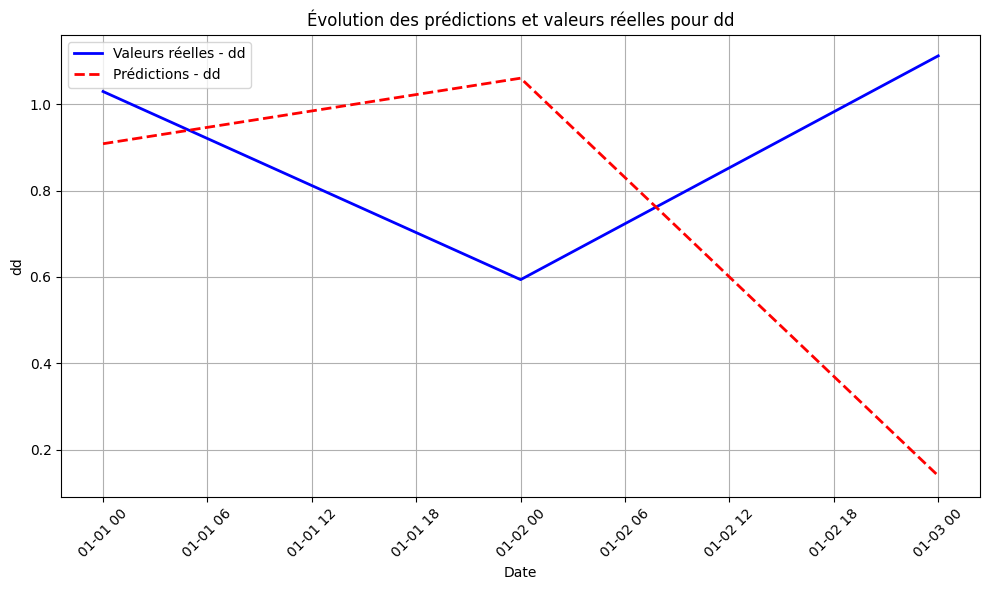

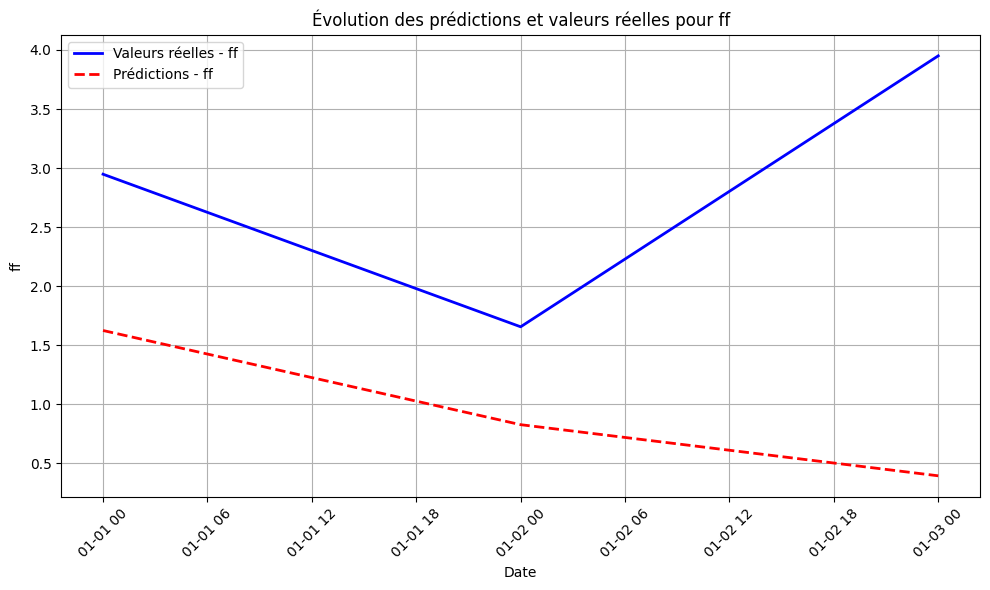

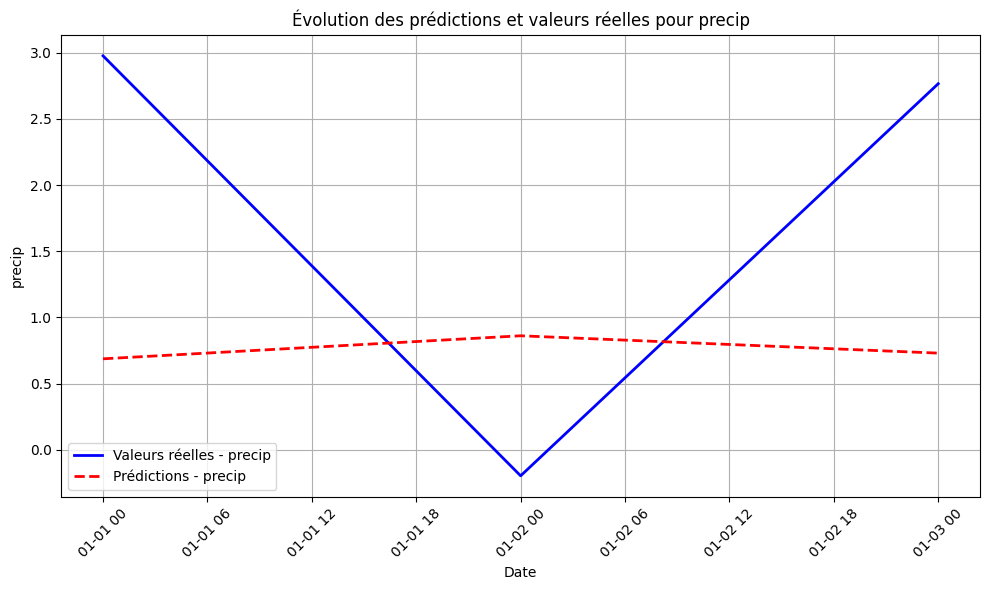

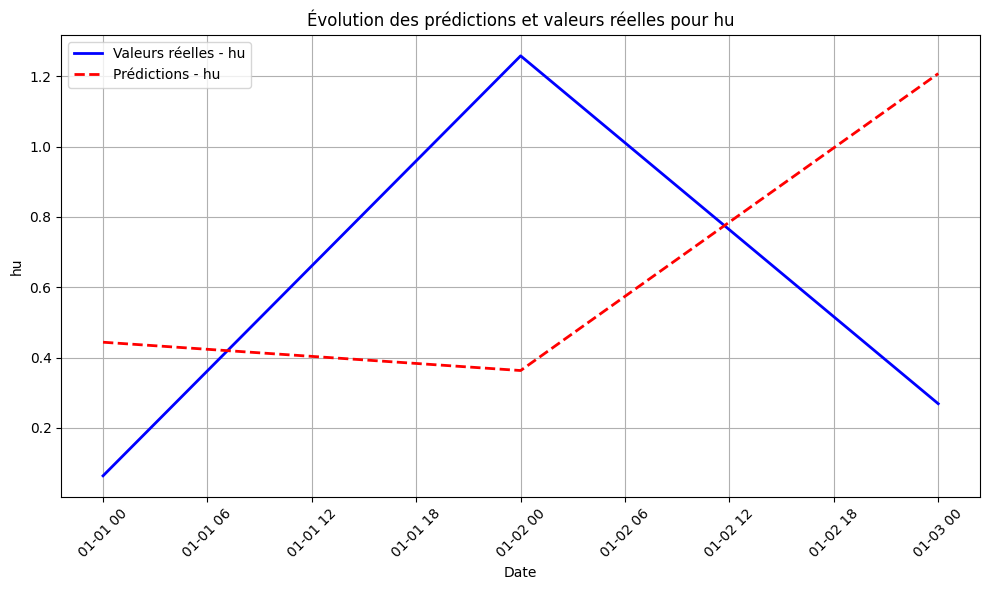

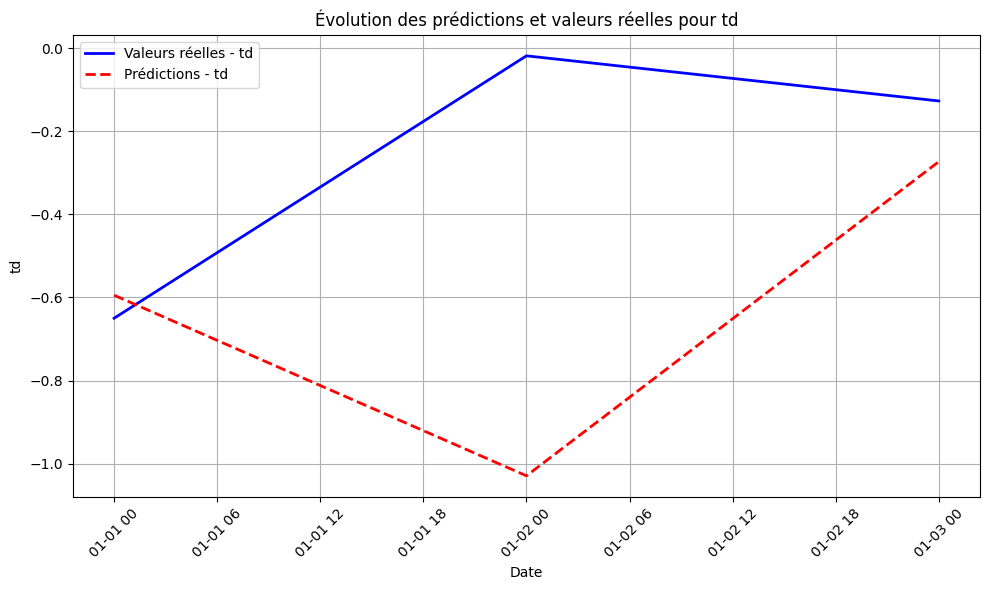

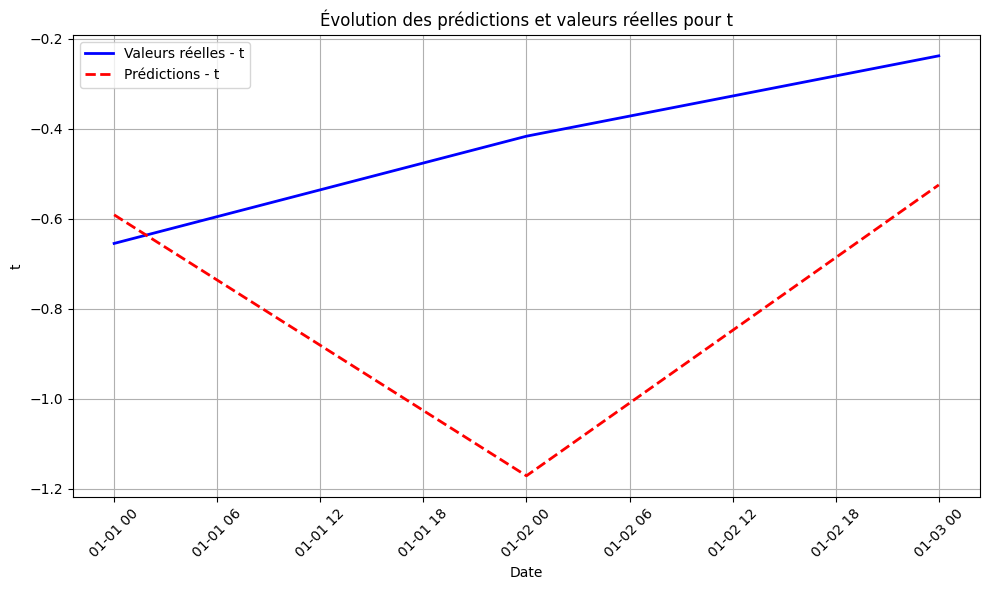

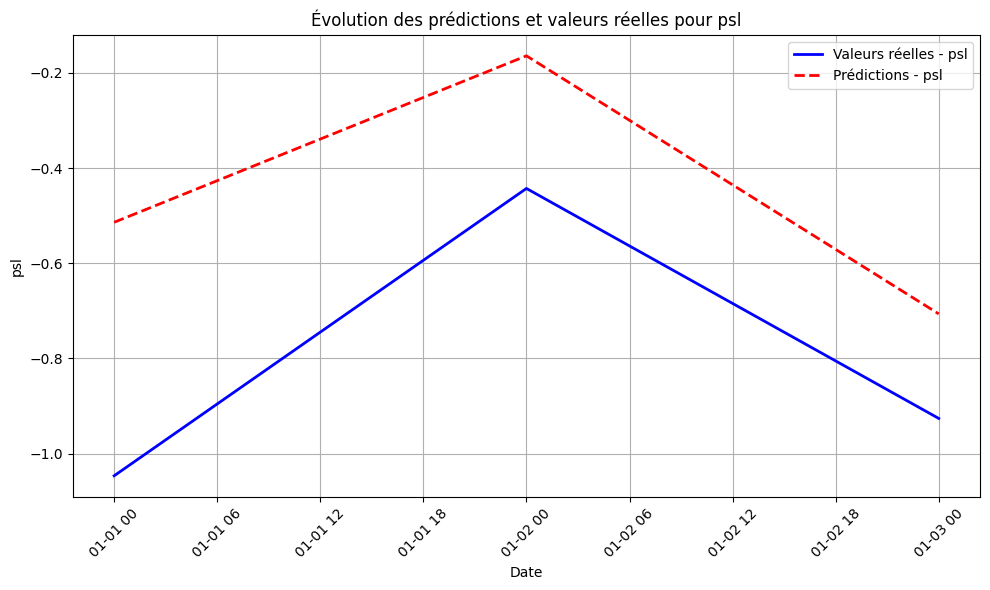

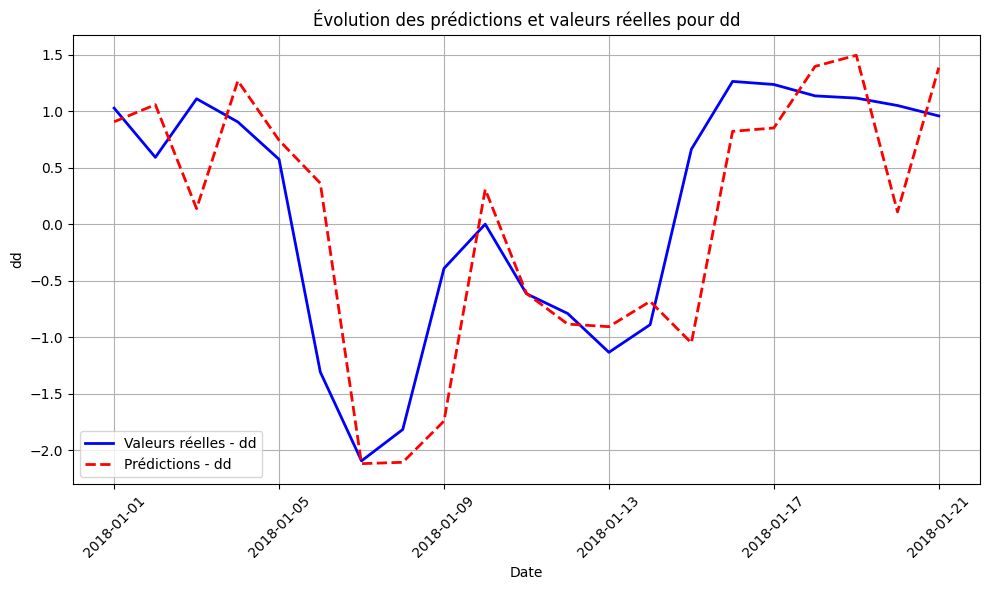

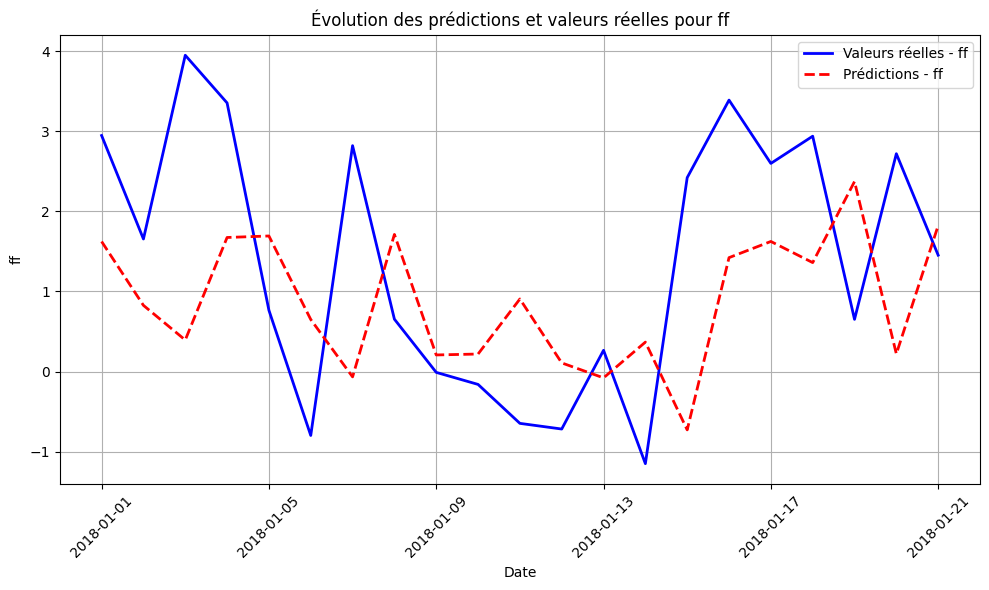

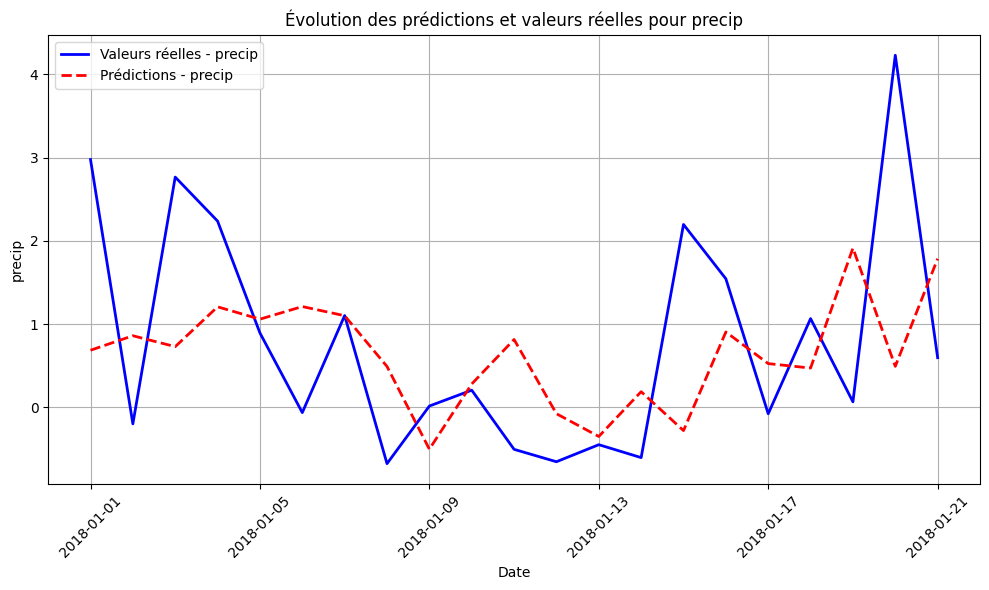

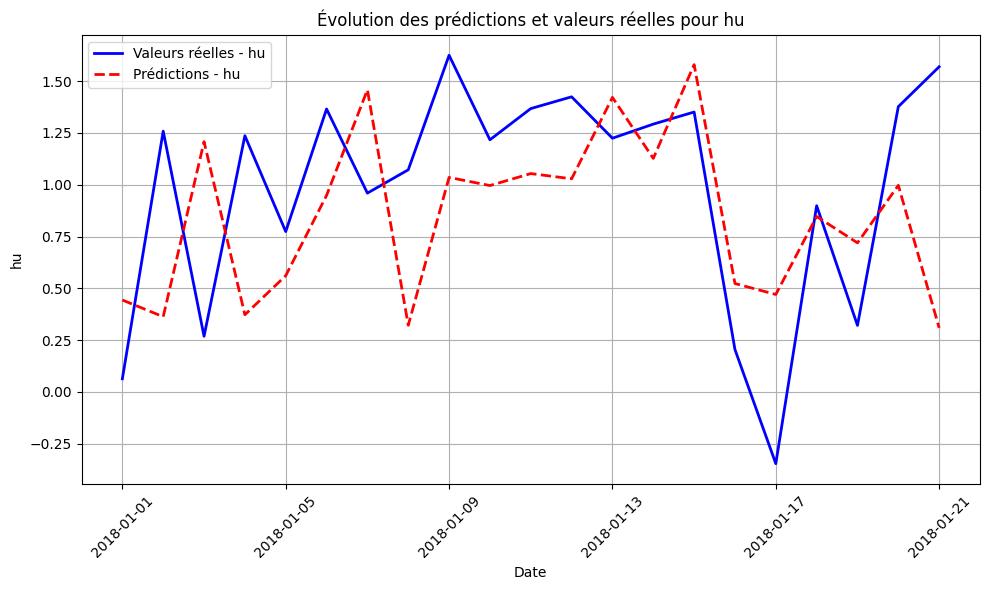

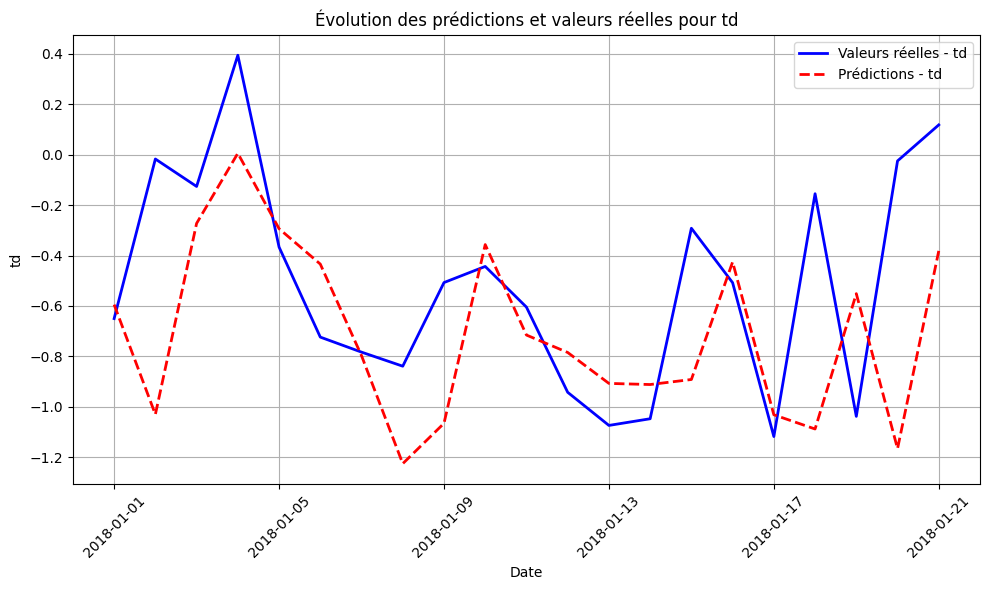

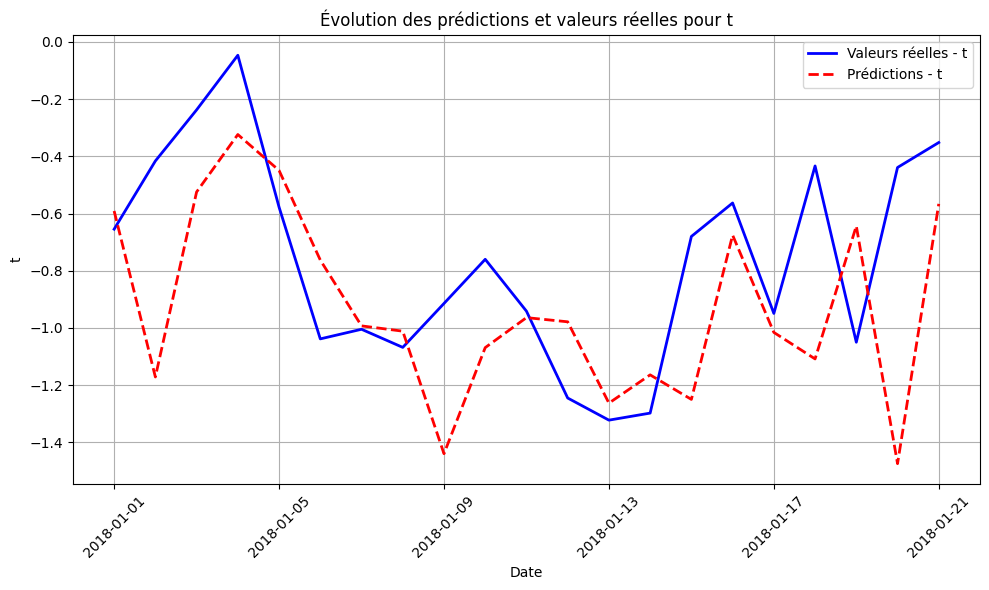

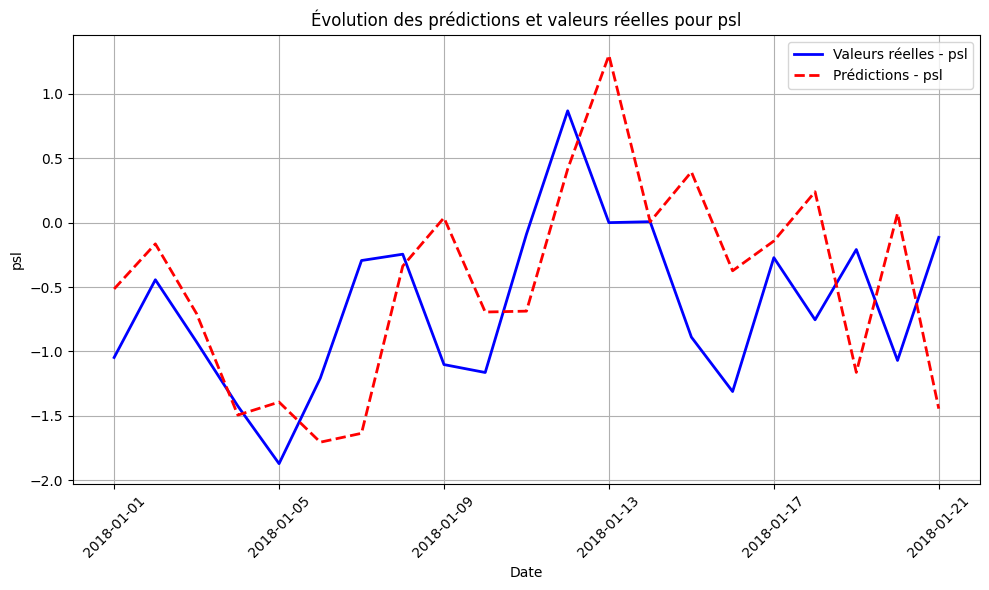

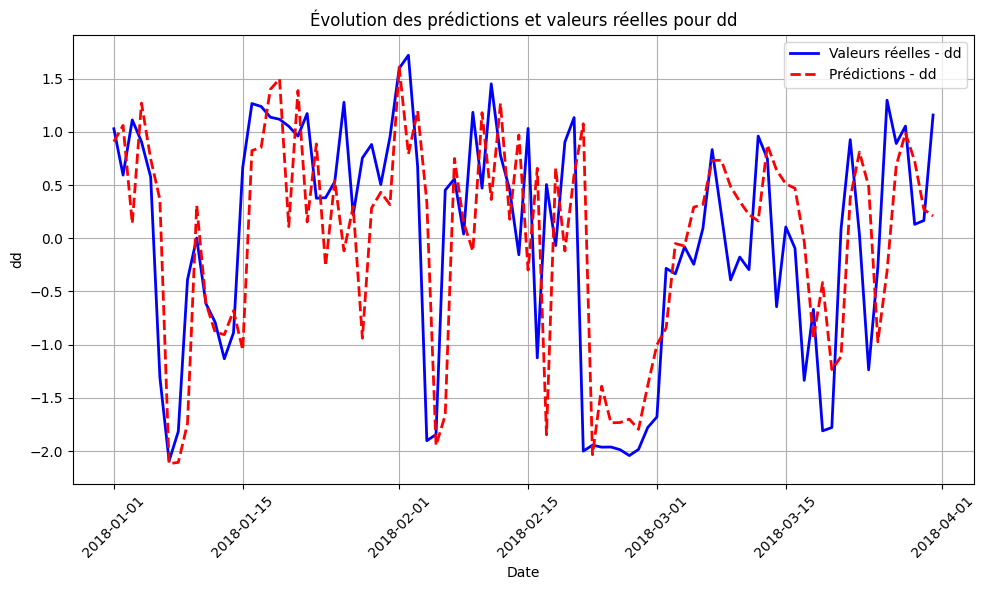

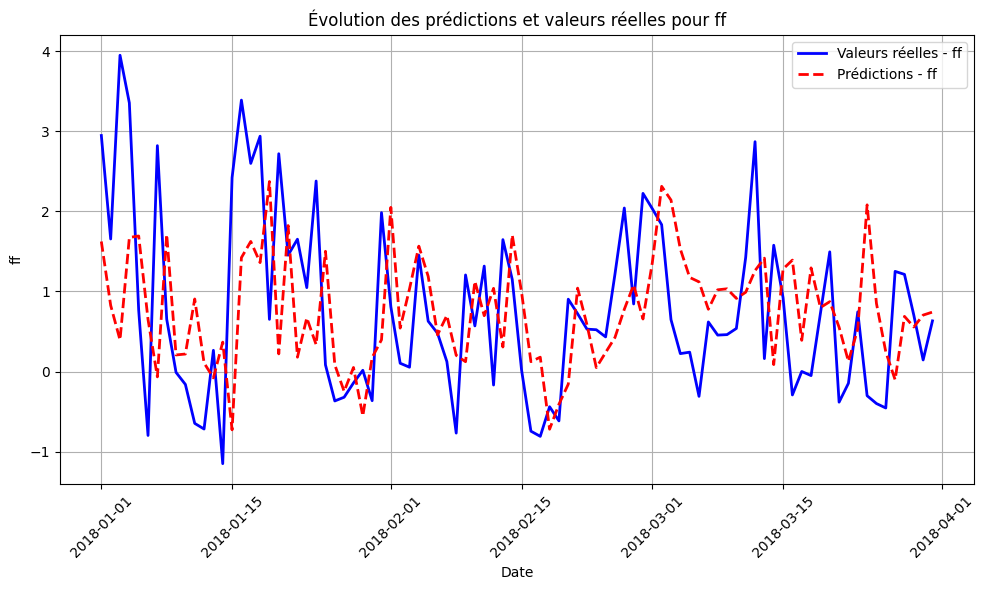

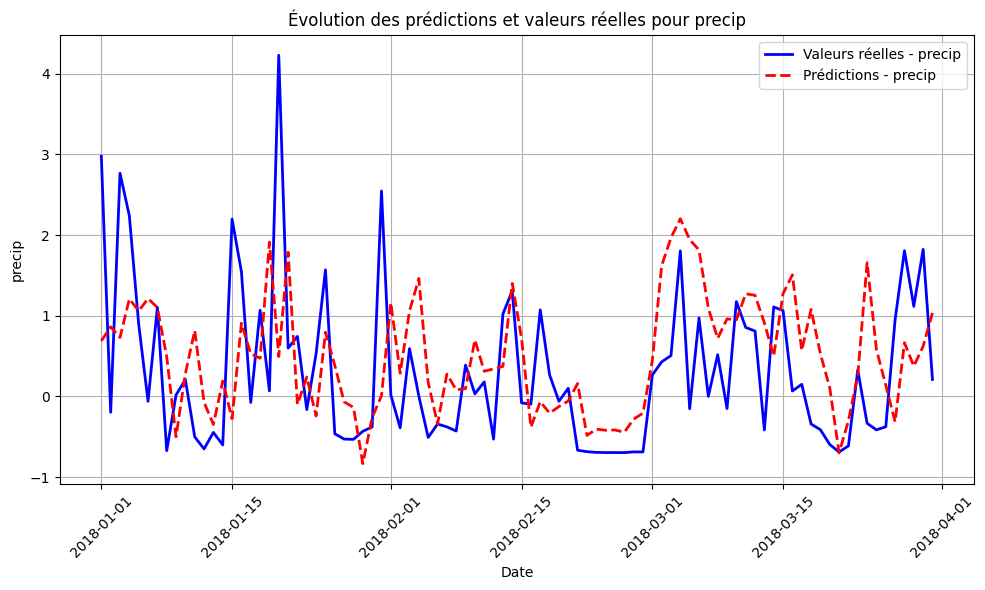

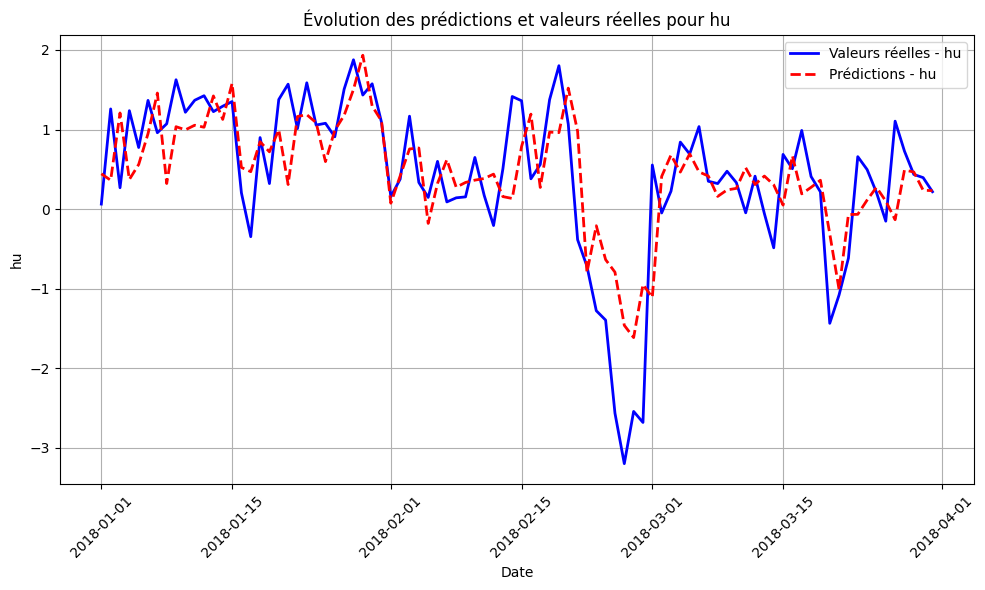

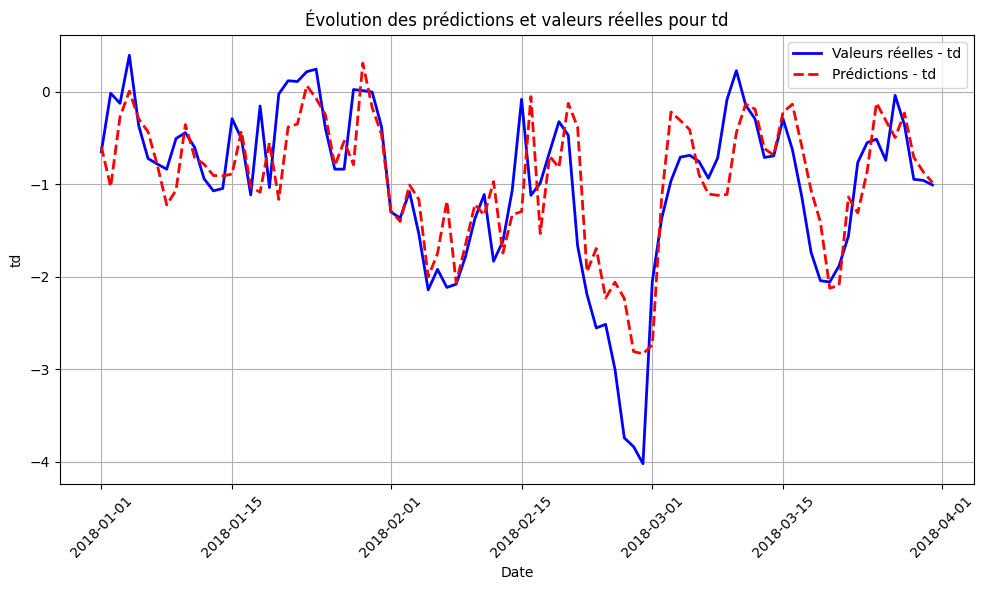

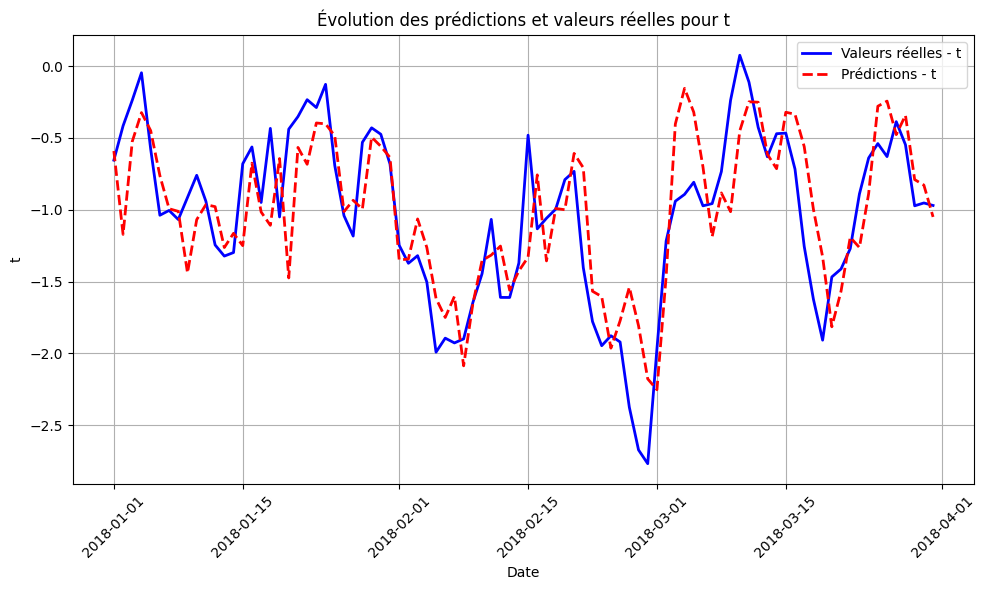

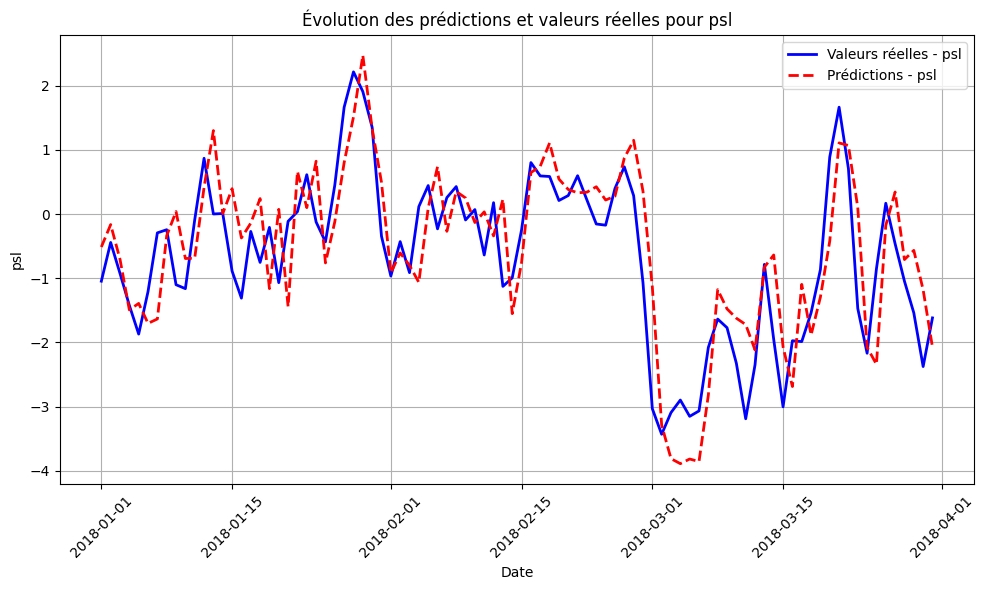

In [ ]:
# Prédictions sur l'ensemble de test
Y_pred = model.predict(X_test_reshaped)

# Convertir Y_test et Y_pred en DataFrame pour faciliter l'analyse
predictions_df = pd.DataFrame(Y_pred, columns=weather_params)
real_values_df = pd.DataFrame(Y_test, columns=weather_params)

# Fonction pour créer les graphiques sans intervalles de confiance
def plot_param_predictions(param, real_values_df, predictions_df, start_date='2018-01-01'):
    # Extraire les données spécifiques pour le paramètre
    real_values = real_values_df[param]
    predicted_values = predictions_df[param]
    
    # Créer une plage de dates (au lieu d'heures, on utilise des jours)
    dates = pd.date_range(start=start_date, periods=len(real_values), freq='D')
    
    # Tracer les prédictions et les valeurs réelles
    plt.figure(figsize=(10, 6))
    plt.plot(dates, real_values, label=f"Valeurs réelles - {param}", color='blue', linewidth=2)
    plt.plot(dates, predicted_values, label=f"Prédictions - {param}", color='red', linestyle='--', linewidth=2)

    # Ajouter des titres et des légendes
    plt.title(f'Évolution des prédictions et valeurs réelles pour {param}')
    plt.xlabel('Date')
    plt.ylabel(param)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Périodes à visualiser : 3 premiers jours, 3 premières semaines, 3 premiers mois
def plot_for_time_periods(real_values_df, predictions_df):
    # 3 premiers jours (3 jours)
    plot_param_predictions('dd', real_values_df[:3], predictions_df[:3], start_date='2018-01-01')
    plot_param_predictions('ff', real_values_df[:3], predictions_df[:3], start_date='2018-01-01')
    plot_param_predictions('precip', real_values_df[:3], predictions_df[:3], start_date='2018-01-01')
    plot_param_predictions('hu', real_values_df[:3], predictions_df[:3], start_date='2018-01-01')
    plot_param_predictions('td', real_values_df[:3], predictions_df[:3], start_date='2018-01-01')
    plot_param_predictions('t', real_values_df[:3], predictions_df[:3], start_date='2018-01-01')
    plot_param_predictions('psl', real_values_df[:3], predictions_df[:3], start_date='2018-01-01')

    # 3 premières semaines (21 jours)
    plot_param_predictions('dd', real_values_df[:21], predictions_df[:21], start_date='2018-01-01')
    plot_param_predictions('ff', real_values_df[:21], predictions_df[:21], start_date='2018-01-01')
    plot_param_predictions('precip', real_values_df[:21], predictions_df[:21], start_date='2018-01-01')
    plot_param_predictions('hu', real_values_df[:21], predictions_df[:21], start_date='2018-01-01')
    plot_param_predictions('td', real_values_df[:21], predictions_df[:21], start_date='2018-01-01')
    plot_param_predictions('t', real_values_df[:21], predictions_df[:21], start_date='2018-01-01')
    plot_param_predictions('psl', real_values_df[:21], predictions_df[:21], start_date='2018-01-01')

    # 3 premiers mois (90 jours)
    plot_param_predictions('dd', real_values_df[:90], predictions_df[:90], start_date='2018-01-01')
    plot_param_predictions('ff', real_values_df[:90], predictions_df[:90], start_date='2018-01-01')
    plot_param_predictions('precip', real_values_df[:90], predictions_df[:90], start_date='2018-01-01')
    plot_param_predictions('hu', real_values_df[:90], predictions_df[:90], start_date='2018-01-01')
    plot_param_predictions('td', real_values_df[:90], predictions_df[:90], start_date='2018-01-01')
    plot_param_predictions('t', real_values_df[:90], predictions_df[:90], start_date='2018-01-01')
    plot_param_predictions('psl', real_values_df[:90], predictions_df[:90], start_date='2018-01-01')

# Appel de la fonction pour tracer les périodes
plot_for_time_periods(real_values_df, predictions_df)

<span style = "color:magenta">  **Conclusion de la pertinence pour un modèle de type LSTM :** On analyse on la vu des données sur les MSE et de la visualisation des prédictions.

<span style = "color:magenta"> A nouveau, et en prenant la prédiction dans sa globalité, on observe une erreur à environ un peu mins de la moitié de l'écart type, soit environ égale au XGBRegressor. De la même manière, certaines variables comme la température t, la température de rosée td, ou enore la pression sont bien prédites tandis que d'autes tel que ff, precip, ou dd sont moins bien capturées par ce modèles (cf. données reprise ci-desous). <br>
Contrairement à l'attente d'une baisse dans l'erreur de la prédition, LSTM étant un modèle adaptés au séries linéaires contrairement à XGBoost, on ne remarque pas de diminution de l'erreur et d'amélioration de la performance. Celà est difficile à expliquer à ce stade. Une étude approndie de la bibliographie pourrait éclairer ce point.

<span style = "color:magenta"> Néanmoins, il est interessant de noter que les visualisation nous permettent à nouveau d'apprécier que le modèle, bien qu'imparfait, donne une estimation toujours relativement proches des données.

<span style = "color:magenta"> Résultats de MSE pour chaque paramètres : 

MSE pour dd : 0.6901491311756258
MSE pour ff : 0.7381968772466975
MSE pour precip : 0.8720777208519521
MSE pour hu : 0.3284000727591562
MSE pour td : 0.17906523430289184
MSE pour t : 0.10659657914503516
MSE pour psl : 0.32393371230162865

### III. C. 5. Modélisation par modèle SARIMA

<span style = "color:magenta"> Dans cette dernière partie, on propose enfin de comparer les résultats avec un modèle de type SARIMAX. <p> 


<span style = "color:magenta"> Tout d'abord, ARIMA (AutoRegressive Integrated Moving Average) est un modèle statistique pour analyser et prédire les séries temporelles. Le modèle combine trois composantes : l'Auto-Régression (AR) qui capture la dépendance d'une observation par rapport à ses valeurs passées, l'Intégration (I) qui rend la série stationnaire en calculant des différences successives, et la Moyenne Mobile (MA) qui intègre l'impact des erreurs de prévision passées.

<span style = "color:magenta"> Un ARIMA(p,d,q) est caractérisé par trois paramètres : p (ordre AR) détermine le nombre de valeurs passées à utiliser, d (ordre d'intégration) indique le nombre de différenciations nécessaires pour rendre la série stationnaire, et q (ordre MA) spécifie le nombre de termes d'erreur passés à considérer.

<span style = "color:magenta"> Le processus typique d'utilisation d'ARIMA implique : (1) tester la stationnarité et différencier si nécessaire, (2) identifier les ordres p et q via les fonctions d'autocorrélation, (3) estimer les paramètres du modèle, (4) vérifier la qualité de l'ajustement via les résidus. <p>


<span style = "color:magenta"> SARIMAX (Seasonal ARIMA with eXogenous variables) est une extension du modèle ARIMA qui combine plusieurs composantes pour la prévision de séries temporelles :

- <span style = "color:magenta"> Le "S" (Saisonnier) ajoute une modélisation des motifs cycliques qui se répètent à intervalles réguliers (par exemple, dans notre cas les variations liées aux saisons)

- <span style = "color:magenta"> Le "X" permet d'intégrer des variables exogènes qui peuvent influencer la série (dans notre cas les autres variables météorologiques)

- <span style = "color:magenta"> Le modèle s'écrit sous forme de paramètres (p,d,q)(P,D,Q)m où p/P=ordre AR, d/D=différenciation, q/Q=ordre MA, et m=période saisonnière

- <span style = "color:magenta"> L'estimation des paramètres se fait généralement par maximum de vraisemblance, et la sélection du meilleur modèle via des critères comme AIC ou BIC

#### III. C. 5. a. Vérification de la stationnarité de la série temporelles

<span style = "color:magenta"> Pour utiliser ce type de modèle, il faut d'abord s'assurer de la stationnarité de chacune des séries temporelles. On détail la méthode dans cette sous partie.

In [ ]:
# Liste pour stocker les résultats du test ADF
statio_verifier = []

# Appliquation de adfuller à chaque colonne de weather_params
for col in weather_params:
    result = adfuller(GO_f[col])
    # Ajouter les résultats sous forme de liste avec le p-value
    statio_verifier.append([col, result[1]])

# Création d'un DataFrame à partir des résultats
statio_verifier_df = pd.DataFrame(statio_verifier, columns=['Paramètre', 'p-value'])

# Transposition du DataFrame pour que les p-values apparaissent en colonne
statio_verifier_df_transposed = statio_verifier_df.T

# Affichage le DataFrame transposé
print(statio_verifier_df_transposed)

             0         1       2         3         4         5    6
Paramètre   dd        ff  precip        hu        td         t  psl
p-value    0.0  0.000696     0.0  0.012855  0.078317  0.251767  0.0


<span style = "color:magenta"> On observe ici que les p-values associées aux tests de stationnarités sont pour les variables td et hu supérieurs à 0.5. Ce test ADFuller semble donc indiquer que ces variables ne serait pas stationnaires. On les considéreras staionnaires pour plus de simplicité.

#### III. C. 5. b. Vérification de la saisonnalité

<span style = "color:magenta"> L'utilisation de SARIMAX nécessite que les données temporelles contiennent une composante saisonnières. A la vue de leur nature (données météorologiques) et de la visualisation des séries temporelles, on considère cette hypothèse vérifiée.

#### III. C. 5. c. Prévision à l'aide du modèle SARIMAX 

<span style = "color:magenta"> Dans cette sous parties, on utilise un modèle SARIMAX pour calculer, à différentes échelles de temps, les prévisions pour les différentes facteurs météorologiques.

<span style = "color:magenta"> Contrairement au modèles précédents, aucun lag n'est introduit. L'exploration commence à la prévisions à J+1, puis on ira à une prévisions jusqu'à J+14. On ajoutera des intervalles de confiances à 95%.

<span style = "color:magenta"> Dans un premier temps, on a considéré un problème de série temporelles univariées. On considérera dans un second temps, un problème univariée, en ajoutant la composante X, exogène de SARIMAX, afin de comparer ce modèle aux deux précédents.

##### III. C. 5. c. i) Prévision à l'aide du modèle SARIMAX : prévisions à J+1 

In [ ]:
# Définition du nouveau jeu de données pour prévisions SARIMA
GO_fS = GO_f.copy()

# Création une nouvelle colonne 'year' pour séparer les années 2016-2017 et 2018
GO_fS['year'] = GO_fS.index.year

# Séparation les données d'entraînement (2016-2017) et de test (2018)
train_data = GO_fS[GO_fS['year'].isin([2016, 2017])]
test_data = GO_fS[GO_fS['year'] == 2018]

# Variables explicatives
X_train = train_data[weather_params]
Y_train = train_data[weather_params]
X_test = test_data[weather_params]
Y_test = test_data[weather_params]

In [196]:
# Application de SARIMAX à tous les paramètres
sarima_results = {}  # Dictionnaire pour stocker les résultats

for params in weather_params:
    train_series = train_data[params]

    sarimax_model = SARIMAX(train_series,
                            order=(1, 1, 1),  # AR, I, MA
                            seasonal_order=(1, 1, 1, 12))  # Saisonnalité de 12 mois
    sarimax_result = sarimax_model.fit()

    # Prévision pour 1 jour supérieur sur les données de test (2018)
    forecast_1 = sarimax_result.get_forecast(steps=1)  
    forecast_mean = forecast_1.predicted_mean # prédiction moyenne
    forecast_ci = forecast_1.conf_int() # intervalle de confiance

    sarima_results[params] = {'forecast_mean': forecast_mean, 'forecast_ci': forecast_ci}
    
    actual_value = test_data[params].iloc[0]  # Valeur réelle pour le premier jour
    mse = mean_squared_error([actual_value], [forecast_mean.iloc[0]])  # Calcul de la MSE

    # Affichage les résultats de prévision pour 1 jour pour les données de test
    print(f"Prévisions pour {params} pour le jour suivant en 2018 :")
    print(f"Prévision (moyenne) : {forecast_mean}")
    print(f"Intervalle de confiance : {forecast_ci}")
    print(f"MSE : {mse:.3f}")
    print("\n" + "="*80 + "\n")

Prévisions pour td pour le jour suivant en 2018 :
Prévision (moyenne) : 2018-01-01   -0.281571
Freq: D, dtype: float64
Intervalle de confiance :             lower td  upper td
2018-01-01 -1.068468  0.505327
MSE : 0.136


Prévisions pour t pour le jour suivant en 2018 :
Prévision (moyenne) : 2018-01-01   -0.320875
Freq: D, dtype: float64
Intervalle de confiance :              lower t   upper t
2018-01-01 -0.900693  0.258943
MSE : 0.111


Prévisions pour dd pour le jour suivant en 2018 :
Prévision (moyenne) : 2018-01-01    0.701407
Freq: D, dtype: float64
Intervalle de confiance :             lower dd  upper dd
2018-01-01 -0.734089  2.136903
MSE : 0.108


Prévisions pour ff pour le jour suivant en 2018 :
Prévision (moyenne) : 2018-01-01    2.036672
Freq: D, dtype: float64
Intervalle de confiance :             lower ff  upper ff
2018-01-01  0.463315  3.610029
MSE : 0.830


Prévisions pour precip pour le jour suivant en 2018 :
Prévision (moyenne) : 2018-01-01    0.638225
Freq: D, dtype: fl

c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Prévisions pour hu pour le jour suivant en 2018 :
Prévision (moyenne) : 2018-01-01    0.440629
Freq: D, dtype: float64
Intervalle de confiance :             lower hu  upper hu
2018-01-01  -0.76276  1.644017
MSE : 0.142


Prévisions pour psl pour le jour suivant en 2018 :
Prévision (moyenne) : 2018-01-01   -1.580366
Freq: D, dtype: float64
Intervalle de confiance :             lower psl  upper psl
2018-01-01  -2.734615  -0.426117
MSE : 0.285




<span style = "color:magenta"> Les MSE sont très réduites, plus petites que les deux modèles précédentes. C'est un résultat auquel on pouvait s'attendre, car on est dans un contexte univariée, surement plus simple pour un pas de temps de prédiction court. Néanmoins, la variable td, que nous avons vu non linéaire est mal prédite. Son type de variation pourrait expliquer cette différence.

##### III. C. 5. c. ii) Prévision à l'aide du modèle SARIMAX : prévisions à J+3

Prévisions pour td pour les 3 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01   -0.281571
2018-01-02   -0.248701
2018-01-03   -0.205334
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower td  upper td
2018-01-01 -1.068468  0.505327
2018-01-02 -1.465482  0.968080
2018-01-03 -1.699114  1.288447
MSE : 0.0650882477271068




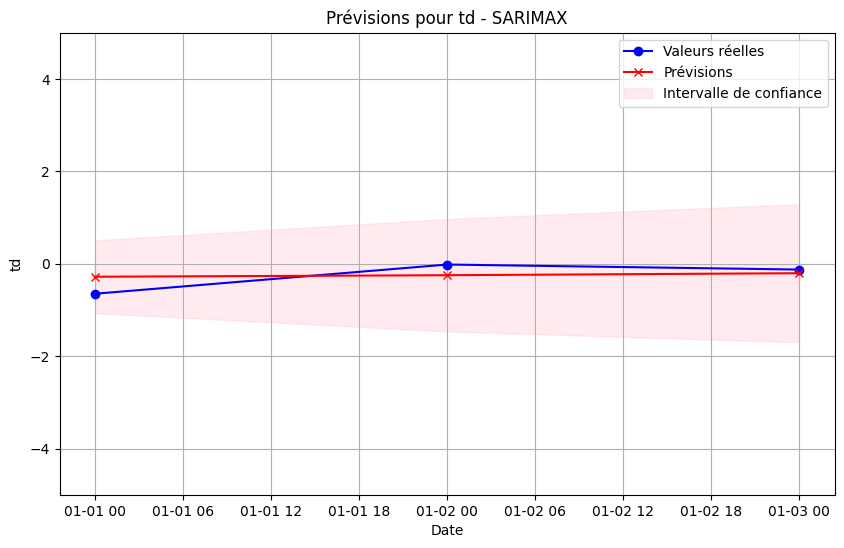

Prévisions pour t pour les 3 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01   -0.320875
2018-01-02   -0.309808
2018-01-03   -0.264828
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :              lower t   upper t
2018-01-01 -0.900693  0.258943
2018-01-02 -1.240931  0.621315
2018-01-03 -1.412248  0.882591
MSE : 0.041187615507635826




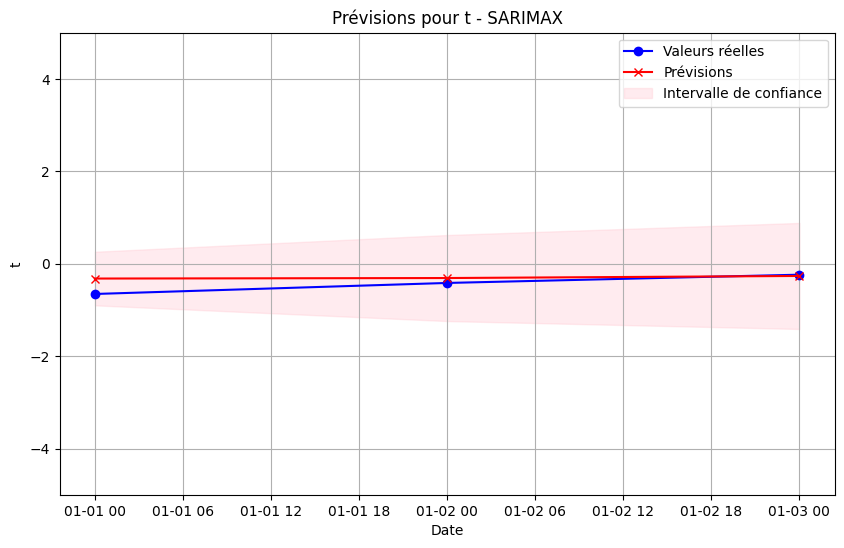

Prévisions pour dd pour les 3 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01    0.701407
2018-01-02    0.659551
2018-01-03    0.626083
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower dd  upper dd
2018-01-01 -0.734089  2.136903
2018-01-02 -1.081576  2.400679
2018-01-03 -1.244189  2.496355
MSE : 0.1160612656276573




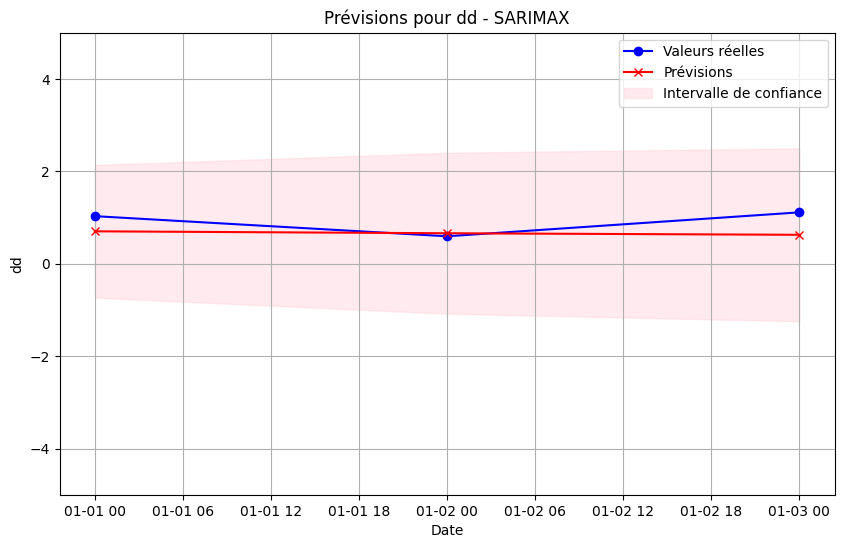

Prévisions pour ff pour les 3 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01    2.036672
2018-01-02    1.272536
2018-01-03    0.983123
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower ff  upper ff
2018-01-01  0.463315  3.610029
2018-01-02 -0.531357  3.076429
2018-01-03 -0.892328  2.858575
MSE : 3.2607635770668115




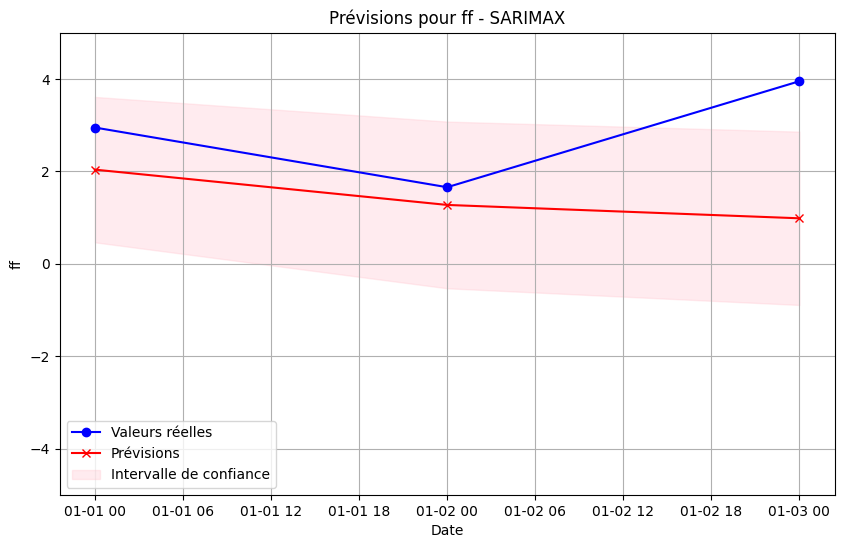

Prévisions pour precip pour les 3 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01    0.638225
2018-01-02    0.226024
2018-01-03    0.320468
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower precip  upper precip
2018-01-01     -1.115602      2.392052
2018-01-02     -1.680021      2.132070
2018-01-03     -1.614199      2.255135
MSE : 3.8768446377390853




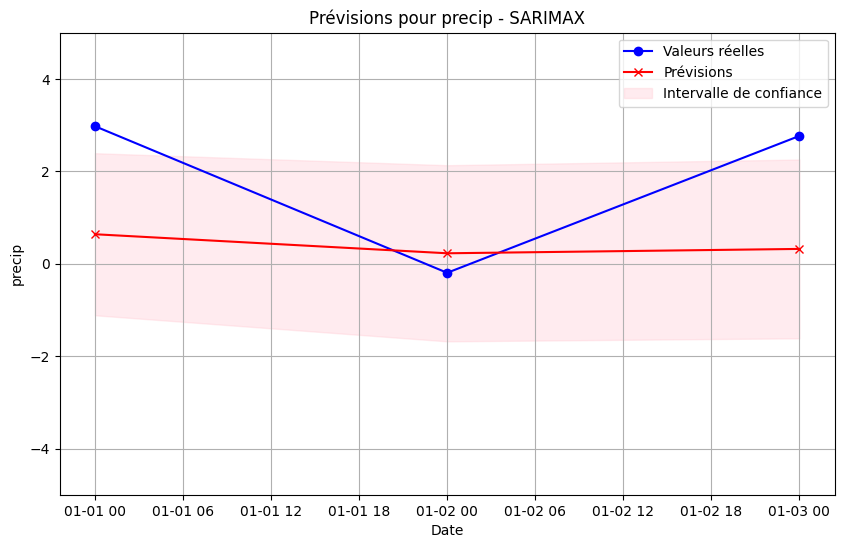

c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Prévisions pour hu pour les 3 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01    0.440629
2018-01-02    0.633850
2018-01-03    0.723166
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower hu  upper hu
2018-01-01 -0.762760  1.644017
2018-01-02 -0.801587  2.069286
2018-01-03 -0.810117  2.256450
MSE : 0.24632903981647838




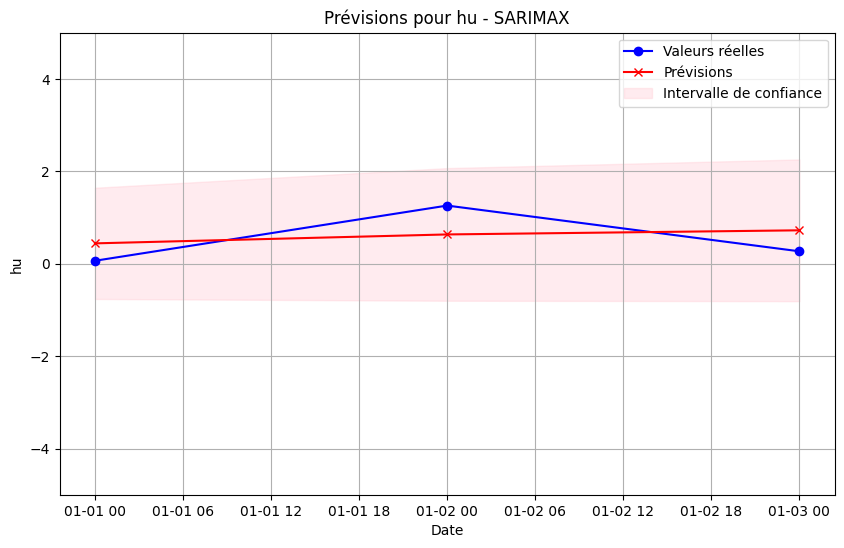

Prévisions pour psl pour les 3 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01   -1.580366
2018-01-02   -1.508898
2018-01-03   -1.597880
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower psl  upper psl
2018-01-01  -2.734615  -0.426117
2018-01-02  -3.463034   0.445238
2018-01-03  -4.034679   0.838919
MSE : 0.6241881563275103




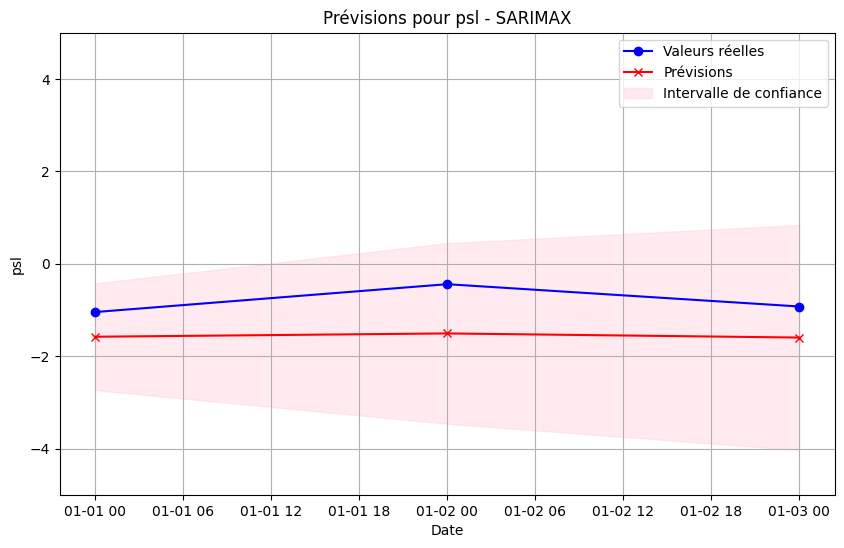

In [199]:
# Application de SARIMAX à tous les paramètres
sarima_results = {}  # Dictionnaire pour stocker les résultats

for params in weather_params:
    train_series = train_data[params]

    sarimax_model = SARIMAX(train_series,
                            order=(1, 1, 1),  # AR, I, MA
                            seasonal_order=(1, 1, 1, 12))  # Saison de 12 mois (annuelle)
    sarimax_result = sarimax_model.fit()

    forecast_3 = sarimax_result.get_forecast(steps=3)  # Prévisions sur 3 jours
    forecast_mean = forecast_3.predicted_mean
    forecast_ci = forecast_3.conf_int()

    sarima_results[params] = {'forecast_mean': forecast_mean, 'forecast_ci': forecast_ci}

    actual_values = test_data[params].iloc[:3] 

    # Calcul de la MSE (Mean Squared Error)
    mse = mean_squared_error(actual_values, forecast_mean) 

    # Affichage des résultats de prévision pour les 3 jours suivants pour les données de test
    print(f"Prévisions pour {params} pour les 3 jours suivants en 2018 :")
    print(f"Prévisions (moyennes) : {forecast_mean}")
    print(f"Intervalle de confiance : {forecast_ci}")
    print(f"MSE : {mse}")
    print("\n" + "="*80 + "\n")

    # Affichage d'un graphique avec les valeurs réelles et les valeurs prédites
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values.index, actual_values, label='Valeurs réelles', color='blue', marker='o')
    plt.plot(forecast_mean.index, forecast_mean, label='Prévisions', color='red', marker='x')

    # Ajouter l'intervalle de confiance
    plt.fill_between(forecast_mean.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], 
                     color='pink', alpha=0.3, label='Intervalle de confiance')

    plt.title(f"Prévisions pour {params} - SARIMAX")
    plt.xlabel('Date')
    plt.ylabel(f'{params}')
    plt.gca().set_ylim(-5, 5)
    plt.legend()
    plt.grid(True)
    plt.show()


<span style = "color:magenta"> On observe de bonnes de relativement bonne préditions à t+3, qui reste pour la majorité des paramètres dans l'intervalled e confiance à 95%.

##### III. C. 5. c. iii) Prévision à l'aide du modèle SARIMAX : prévisions à J+14

Prévisions pour td pour les 14 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01   -0.281571
2018-01-02   -0.248701
2018-01-03   -0.205334
2018-01-04   -0.214395
2018-01-05   -0.259687
2018-01-06   -0.181739
2018-01-07   -0.206539
2018-01-08   -0.190377
2018-01-09   -0.149591
2018-01-10   -0.169593
2018-01-11   -0.268077
2018-01-12   -0.284810
2018-01-13   -0.252931
2018-01-14   -0.236006
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower td  upper td
2018-01-01 -1.068468  0.505327
2018-01-02 -1.465482  0.968080
2018-01-03 -1.699114  1.288447
2018-01-04 -1.954936  1.526145
2018-01-05 -2.210785  1.691411
2018-01-06 -2.324896  1.961419
2018-01-07 -2.525055  2.111978
2018-01-08 -2.672237  2.291483
2018-01-09 -2.784547  2.485366
2018-01-10 -2.949248  2.610062
2018-01-11 -3.185238  2.649083
2018-01-12 -3.333290  2.763671
2018-01-13 -3.409438  2.903577
2018-01-14 -3.493996  3.021984
MSE : 0.2642268426659285




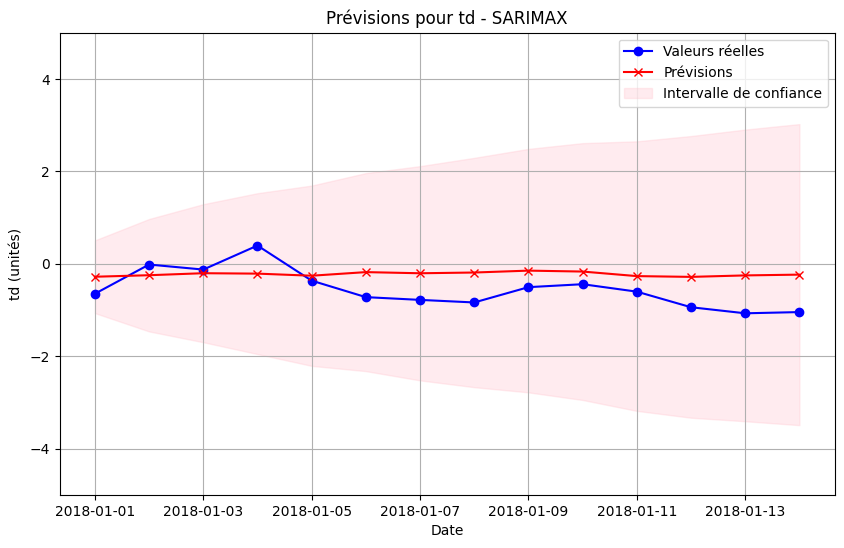

Prévisions pour t pour les 14 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01   -0.320875
2018-01-02   -0.309808
2018-01-03   -0.264828
2018-01-04   -0.252881
2018-01-05   -0.290211
2018-01-06   -0.270070
2018-01-07   -0.295915
2018-01-08   -0.300120
2018-01-09   -0.199924
2018-01-10   -0.201047
2018-01-11   -0.295485
2018-01-12   -0.338122
2018-01-13   -0.337743
2018-01-14   -0.330988
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :              lower t   upper t
2018-01-01 -0.900693  0.258943
2018-01-02 -1.240931  0.621315
2018-01-03 -1.412248  0.882591
2018-01-04 -1.593422  1.087660
2018-01-05 -1.795319  1.214896
2018-01-06 -1.924876  1.384735
2018-01-07 -2.087440  1.495611
2018-01-08 -2.218835  1.618594
2018-01-09 -2.237837  1.837990
2018-01-10 -2.351557  1.949464
2018-01-11 -2.552974  1.962004
2018-01-12 -2.697748  2.021505
2018-01-13 -2.784099  2.108613
2018-01-14 -2.858434  2.196458
MSE : 0.4215207870858144




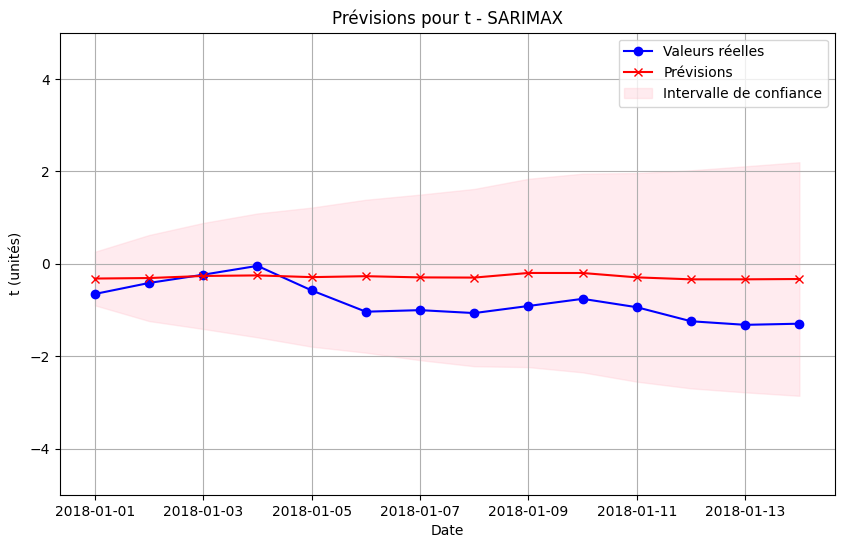

Prévisions pour dd pour les 14 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01    0.701407
2018-01-02    0.659551
2018-01-03    0.626083
2018-01-04    0.511441
2018-01-05    0.526077
2018-01-06    0.452167
2018-01-07    0.295840
2018-01-08    0.506598
2018-01-09    0.503178
2018-01-10    0.523872
2018-01-11    0.532053
2018-01-12    0.436266
2018-01-13    0.575119
2018-01-14    0.571766
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower dd  upper dd
2018-01-01 -0.734089  2.136903
2018-01-02 -1.081576  2.400679
2018-01-03 -1.244189  2.496355
2018-01-04 -1.419391  2.442273
2018-01-05 -1.435044  2.487198
2018-01-06 -1.525041  2.429375
2018-01-07 -1.690494  2.282175
2018-01-08 -1.485306  2.498503
2018-01-09 -1.492383  2.498738
2018-01-10 -1.474276  2.522019
2018-01-11 -1.468076  2.532181
2018-01-12 -1.565482  2.438014
2018-01-13 -1.429868  2.580106
2018-01-14 -1.435610  2.579142
MSE : 1.6875898956039677




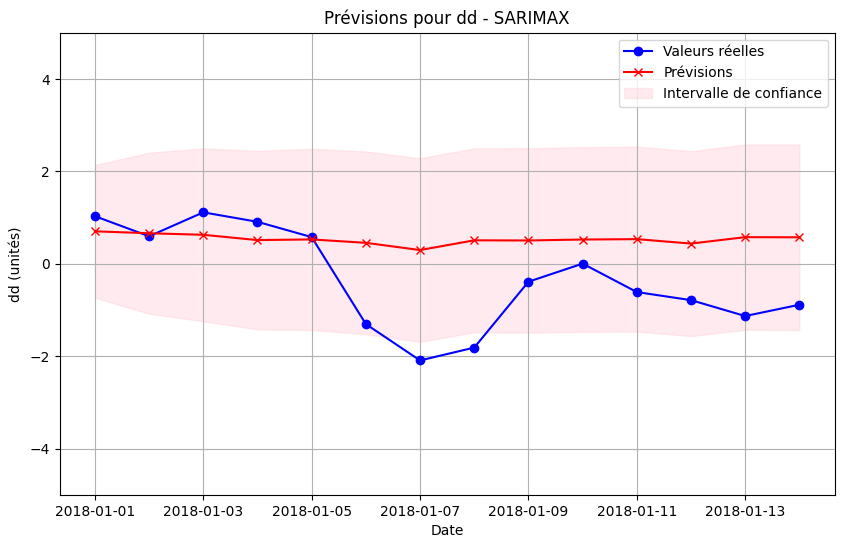

Prévisions pour ff pour les 14 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01    2.036672
2018-01-02    1.272536
2018-01-03    0.983123
2018-01-04    0.685287
2018-01-05    0.343809
2018-01-06    0.729011
2018-01-07    0.743324
2018-01-08    0.762505
2018-01-09    0.555420
2018-01-10    0.526845
2018-01-11    0.763185
2018-01-12    0.666957
2018-01-13    0.546277
2018-01-14    0.487956
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower ff  upper ff
2018-01-01  0.463315  3.610029
2018-01-02 -0.531357  3.076429
2018-01-03 -0.892328  2.858575
2018-01-04 -1.216567  2.587140
2018-01-05 -1.569641  2.257260
2018-01-06 -1.190627  2.648650
2018-01-07 -1.180308  2.666955
2018-01-08 -1.164145  2.689156
2018-01-09 -1.373783  2.484622
2018-01-10 -1.404675  2.458365
2018-01-11 -1.170531  2.696901
2018-01-12 -1.268892  2.602805
2018-01-13 -1.396914  2.489468
2018-01-14 -1.459840  2.435752
MSE : 2.2293368590624283




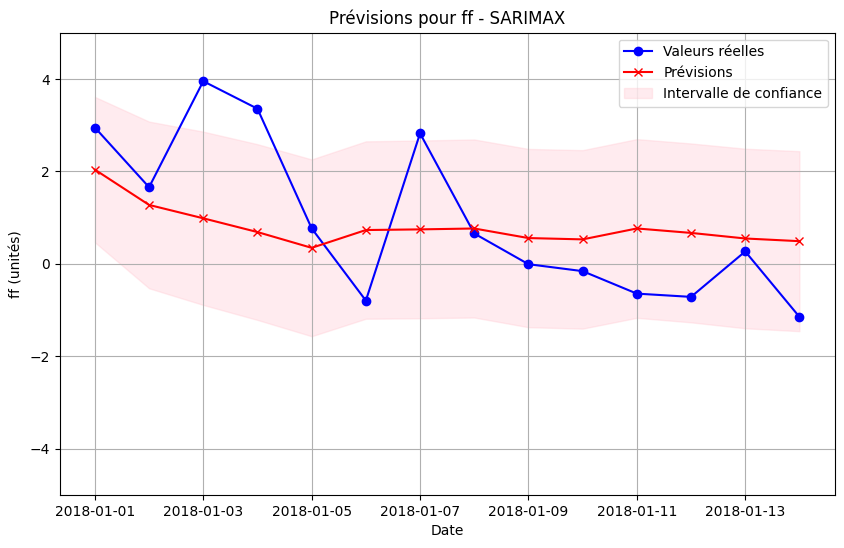

Prévisions pour precip pour les 14 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01    0.638225
2018-01-02    0.226024
2018-01-03    0.320468
2018-01-04    0.101454
2018-01-05    0.118812
2018-01-06    0.339180
2018-01-07    0.520143
2018-01-08    0.084015
2018-01-09   -0.034246
2018-01-10    0.179038
2018-01-11    0.366769
2018-01-12    0.226174
2018-01-13    0.154163
2018-01-14    0.032444
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower precip  upper precip
2018-01-01     -1.115602      2.392052
2018-01-02     -1.680021      2.132070
2018-01-03     -1.614199      2.255135
2018-01-04     -1.839876      2.042784
2018-01-05     -1.824618      2.062243
2018-01-06     -1.605218      2.283579
2018-01-07     -1.424885      2.465170
2018-01-08     -1.861525      2.029556
2018-01-09     -1.980238      1.911747
2018-01-10     -1.767397      2.125472
2018-01-11     -1.580101      2.313638
2018-01-12     -1.721128      2.173475
2018-01-13     

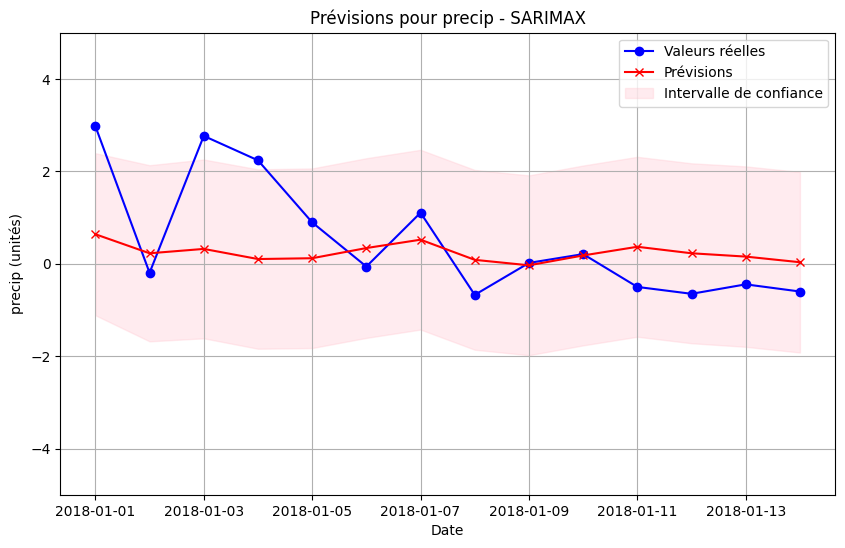

c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Prévisions pour hu pour les 14 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01    0.440629
2018-01-02    0.633850
2018-01-03    0.723166
2018-01-04    0.713364
2018-01-05    0.753790
2018-01-06    0.903098
2018-01-07    0.905766
2018-01-08    0.908279
2018-01-09    0.755928
2018-01-10    0.796274
2018-01-11    0.822480
2018-01-12    0.852109
2018-01-13    0.894003
2018-01-14    0.913240
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower hu  upper hu
2018-01-01 -0.762760  1.644017
2018-01-02 -0.801587  2.069286
2018-01-03 -0.810117  2.256450
2018-01-04 -0.870737  2.297465
2018-01-05 -0.861613  2.369192
2018-01-06 -0.734595  2.540792
2018-01-07 -0.749712  2.561244
2018-01-08 -0.762584  2.579141
2018-01-09 -0.928957  2.440812
2018-01-10 -0.901845  2.494393
2018-01-11 -0.888396  2.533356
2018-01-12 -0.871215  2.575434
2018-01-13 -0.839203  2.627208
2018-01-14 -0.830519  2.656998
MSE : 0.21911449213009251




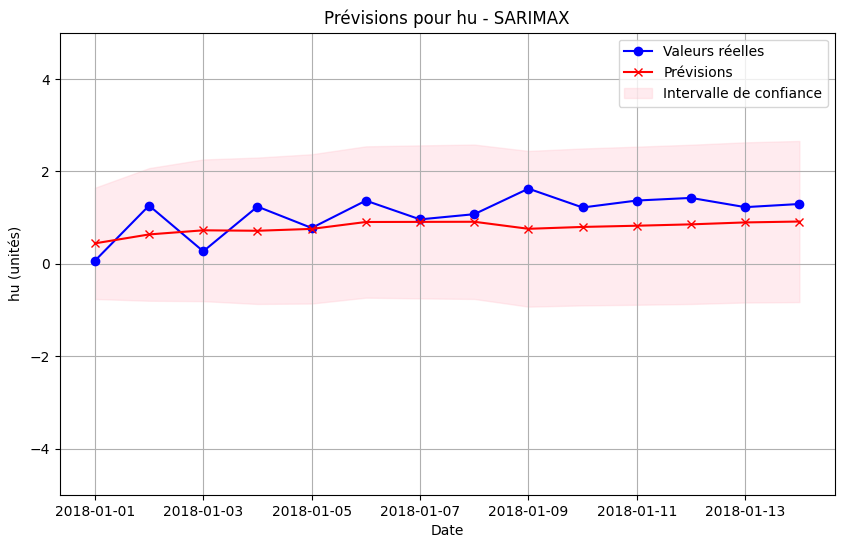

Prévisions pour psl pour les 14 jours suivants en 2018 :
Prévisions (moyennes) : 2018-01-01   -1.580366
2018-01-02   -1.508898
2018-01-03   -1.597880
2018-01-04   -1.511399
2018-01-05   -1.568858
2018-01-06   -1.664308
2018-01-07   -1.744611
2018-01-08   -1.702121
2018-01-09   -1.577924
2018-01-10   -1.661225
2018-01-11   -1.662853
2018-01-12   -1.598056
2018-01-13   -1.619310
2018-01-14   -1.631813
Freq: D, Name: predicted_mean, dtype: float64
Intervalle de confiance :             lower psl  upper psl
2018-01-01  -2.734615  -0.426117
2018-01-02  -3.463034   0.445238
2018-01-03  -4.034679   0.838919
2018-01-04  -4.367874   1.345076
2018-01-05  -4.786221   1.648504
2018-01-06  -5.207161   1.878546
2018-01-07  -5.585157   2.095935
2018-01-08  -5.818971   2.414730
2018-01-09  -5.953645   2.797798
2018-01-10  -6.281297   2.958847
2018-01-11  -6.514983   3.189278
2018-01-12  -6.671643   3.475531
2018-01-13  -6.919692   3.681072
2018-01-14  -7.154923   3.891297
MSE : 1.482904788146824




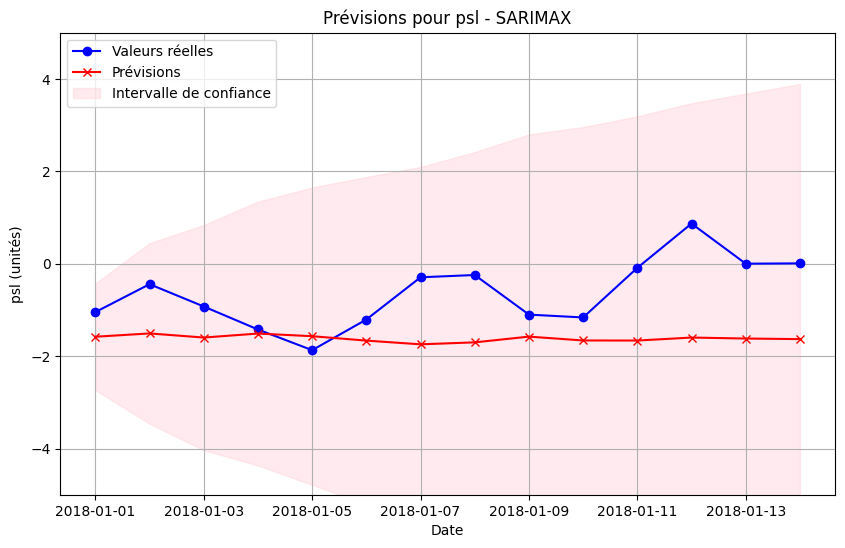

In [200]:
# Application de SARIMAX à tous les paramètres
sarima_results = {}  # Dictionnaire pour stocker les résultats

for params in weather_params:
    train_series = train_data[params]

    sarimax_model = SARIMAX(train_series,
                            order=(1, 1, 1),  # AR, I, MA
                            seasonal_order=(1, 1, 1, 12))  # Saison de 12 mois (annuelle)
    sarimax_result = sarimax_model.fit()

    forecast_14 = sarimax_result.get_forecast(steps=14)  # Prévisions sur 14 jours
    forecast_mean = forecast_14.predicted_mean
    forecast_ci = forecast_14.conf_int()

    sarima_results[params] = {'forecast_mean': forecast_mean, 'forecast_ci': forecast_ci}

    actual_values = test_data[params].iloc[:14]  # Valeurs réelles pour les 14 premiers jours de test

    mse = mean_squared_error(actual_values, forecast_mean)  # Erreur carrée moyenne

    # Affichage des résultats de prévision pour les 14 jours suivants pour les données de test
    print(f"Prévisions pour {params} pour les 14 jours suivants en 2018 :")
    print(f"Prévisions (moyennes) : {forecast_mean}")
    print(f"Intervalle de confiance : {forecast_ci}")
    print(f"MSE : {mse}")
    print("\n" + "="*80 + "\n")

    # Affichage d'un graphique avec les valeurs réelles et les valeurs prédites
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values.index, actual_values, label='Valeurs réelles', color='blue', marker='o')
    plt.plot(forecast_mean.index, forecast_mean, label='Prévisions', color='red', marker='x')

    # Ajouter l'intervalle de confiance
    plt.fill_between(forecast_mean.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], 
                     color='pink', alpha=0.3, label='Intervalle de confiance')

    plt.title(f"Prévisions pour {params} - SARIMAX")
    plt.xlabel('Date')
    plt.ylabel(f'{params} (unités)')
    plt.legend()
    plt.gca().set_ylim(-5, 5)
    plt.grid(True)
    plt.show()


<span style = "color:magenta"> Idem, bonne prévisions pour certaines variables, hors des intervalles de confiance. De plus inteervalle de confiances grandissent très rapidement.

#### III. C. 5. c. iv) Prévisions SARIMAX en intégrant les autres données météorologiques

###### Prévisions à J+1 :

In [197]:
# Dictionnaire pour stocker les résultats
sarima_results = {}

for params in weather_params:
    # Séries temporelles d'entraînement pour chaque paramètre
    train_series = train_data[params]
    
    # Variables exogènes (toutes les autres variables sauf la variable cible actuelle)
    exog_train = train_data[weather_params].drop(columns=[params])  # Variables explicatives pour l'entraînement
    exog_test = test_data[weather_params].drop(columns=[params])  # Variables explicatives pour le test

    # Ajuster le modèle SARIMAX sur les données d'entraînement avec exogènes
    sarimax_model = SARIMAX(train_series,
                            exog=exog_train,  # Variables exogènes
                            order=(1, 1, 1),  # AR, I, MA
                            seasonal_order=(1, 1, 1, 12))  # Saisonnalité de 12 mois
    sarimax_result = sarimax_model.fit()

    # Prévision pour 1 jour supérieur avec exogènes pour les données de test
    forecast_1 = sarimax_result.get_forecast(steps=1, exog=exog_test.iloc[:1])  # Prédiction avec les exogènes de test
    forecast_mean = forecast_1.predicted_mean  # Prédiction moyenne
    forecast_ci = forecast_1.conf_int()  # Intervalle de confiance

    # Stocker les résultats dans le dictionnaire
    sarima_results[params] = {'forecast_mean': forecast_mean, 'forecast_ci': forecast_ci}

    # Calcul de la MSE entre la valeur réelle et la prévision
    actual_value = test_data[params].iloc[0]  # Valeur réelle pour le premier jour
    mse = mean_squared_error([actual_value], [forecast_mean.iloc[0]])  # Calcul de la MSE

    # Affichage des résultats
    print(f"Prévisions pour {params} pour le jour suivant en 2018 :")
    print(f"Prévision (moyenne) : {forecast_mean.iloc[0]:.3f}")
    print(f"Intervalle de confiance : {forecast_ci.iloc[0].values}")
    print(f"MSE : {mse:.3f}")
    print("\n" + "="*80 + "\n")


c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prévisions pour td pour le jour suivant en 2018 :
Prévision (moyenne) : -0.686
Intervalle de confiance : [-0.75441281 -0.61694663]
MSE : 0.001




c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prévisions pour t pour le jour suivant en 2018 :
Prévision (moyenne) : -0.626
Intervalle de confiance : [-0.68886893 -0.56262466]
MSE : 0.001




c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prévisions pour dd pour le jour suivant en 2018 :
Prévision (moyenne) : 0.813
Intervalle de confiance : [-0.51085026  2.13621976]
MSE : 0.047




c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Prévisions pour ff pour le jour suivant en 2018 :
Prévision (moyenne) : 3.211
Intervalle de confiance : [2.01242068 4.40989909]
MSE : 0.069


Prévisions pour precip pour le jour suivant en 2018 :
Prévision (moyenne) : 1.237
Intervalle de confiance : [-0.01440953  2.48799275]
MSE : 3.028




c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prévisions pour hu pour le jour suivant en 2018 :
Prévision (moyenne) : 0.169
Intervalle de confiance : [-0.01441636  0.35337857]
MSE : 0.011


Prévisions pour psl pour le jour suivant en 2018 :
Prévision (moyenne) : -1.693
Intervalle de confiance : [-2.56158631 -0.82453323]
MSE : 0.418




c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prévisions pour td pour les 14 jours suivants en 2018 :
MSE sur 14 jours : 0.001




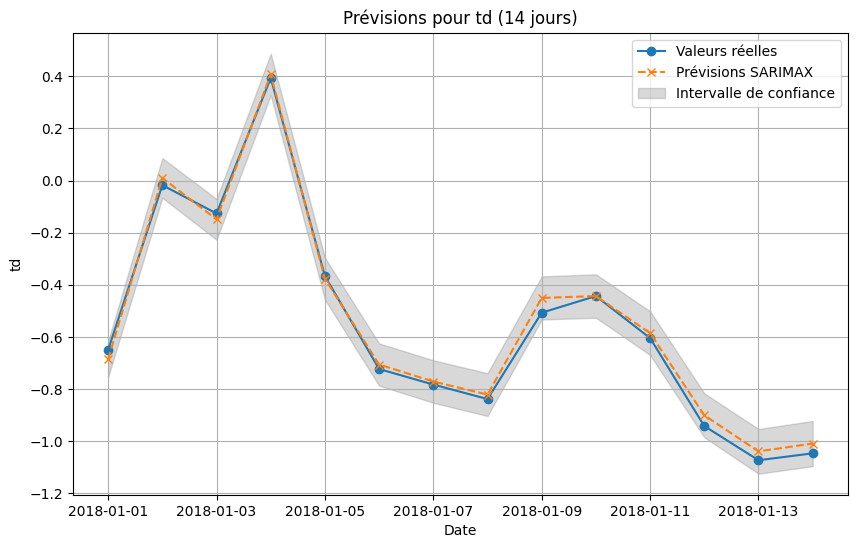

c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prévisions pour t pour les 14 jours suivants en 2018 :
MSE sur 14 jours : 0.001




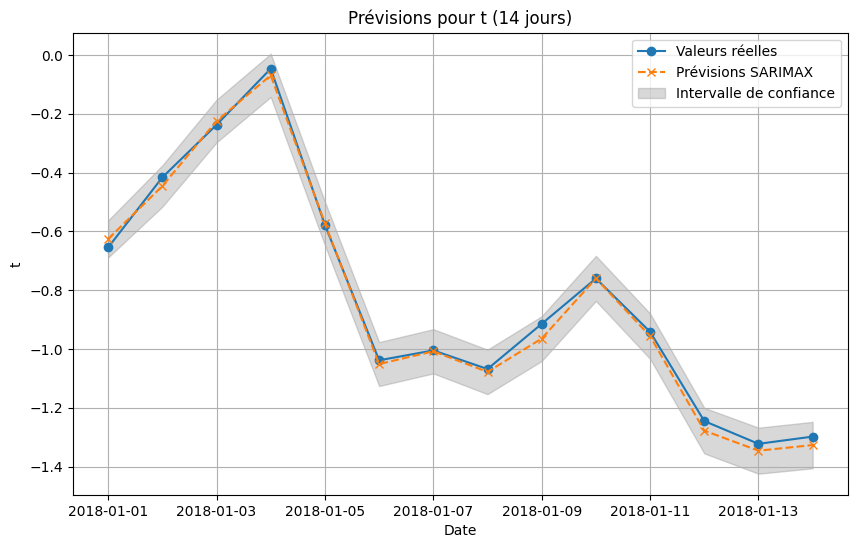

c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prévisions pour dd pour les 14 jours suivants en 2018 :
MSE sur 14 jours : 1.294




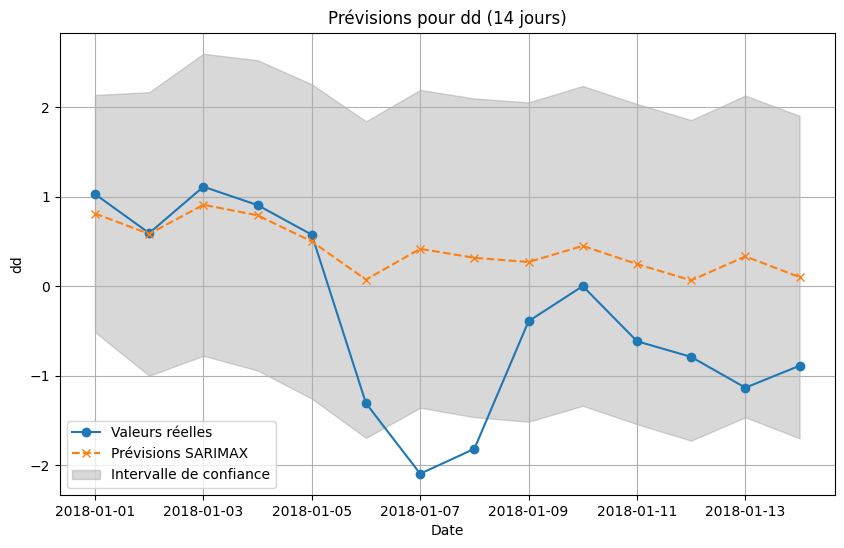

c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Prévisions pour ff pour les 14 jours suivants en 2018 :
MSE sur 14 jours : 1.017




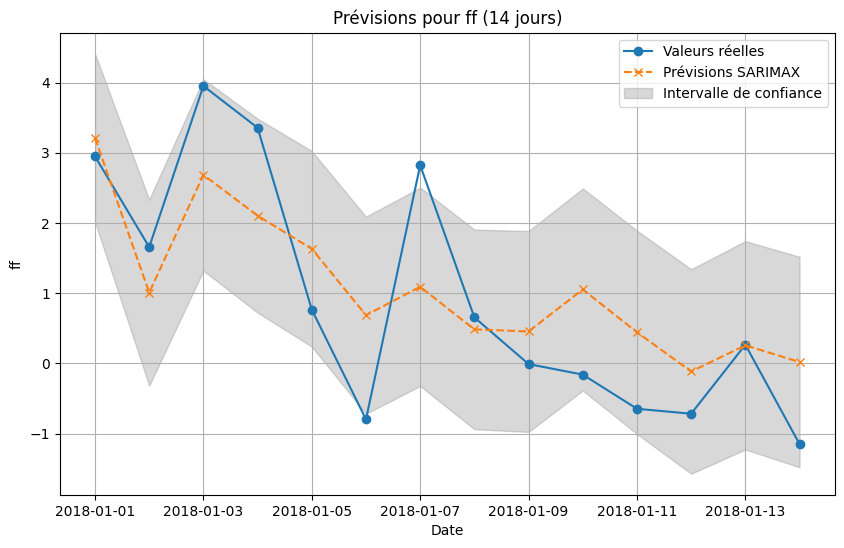

Prévisions pour precip pour les 14 jours suivants en 2018 :
MSE sur 14 jours : 0.778




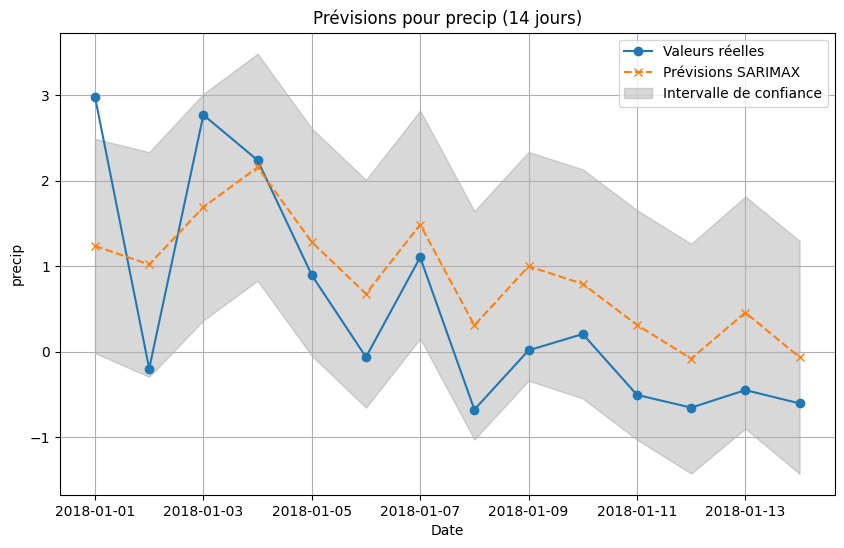

c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prévisions pour hu pour les 14 jours suivants en 2018 :
MSE sur 14 jours : 0.008




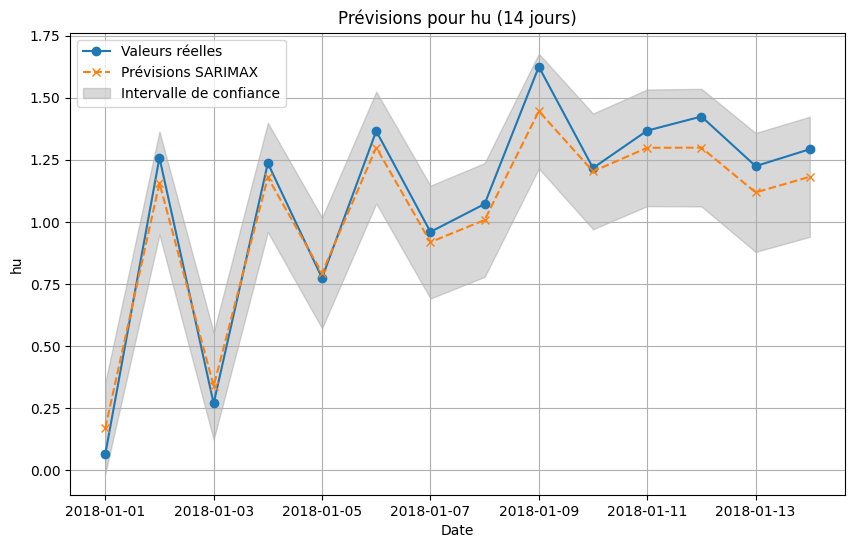

Prévisions pour psl pour les 14 jours suivants en 2018 :
MSE sur 14 jours : 0.492




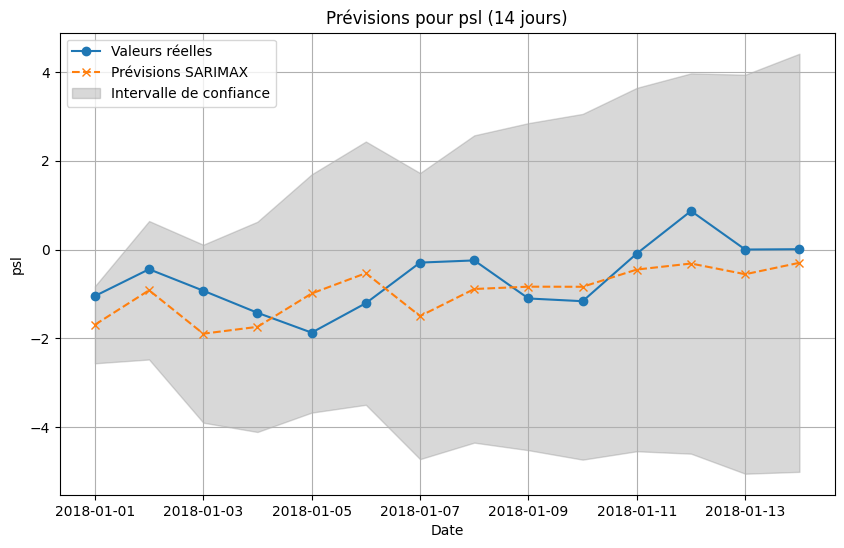

In [ ]:
# Dictionnaire pour stocker les résultats
sarima_results = {}

for params in weather_params:
    train_series = train_data[params]

    exog_train = train_data[weather_params].drop(columns=[params])  # Variables explicatives pour l'entraînement
    exog_test = test_data[weather_params].drop(columns=[params])  # Variables explicatives pour le test
    
    sarimax_model = SARIMAX(train_series,
                            exog=exog_train,  # Variables exogènes
                            order=(1, 1, 1),  # AR, I, MA
                            seasonal_order=(1, 1, 1, 12))  # Saisonnalité de 12 mois
    sarimax_result = sarimax_model.fit()

    forecast_14 = sarimax_result.get_forecast(steps=14, exog=exog_test.iloc[:14])  # Prédictions pour 14 jours
    forecast_mean = forecast_14.predicted_mean  # Prédictions moyennes
    forecast_ci = forecast_14.conf_int()  # Intervalles de confiance

    sarima_results[params] = {'forecast_mean': forecast_mean, 'forecast_ci': forecast_ci}

    actual_values = test_data[params].iloc[:14]

    mse = mean_squared_error(actual_values, forecast_mean)

    print(f"Prévisions pour {params} pour les 14 jours suivants en 2018 :")
    print(f"MSE sur 14 jours : {mse:.3f}")
    print("\n" + "="*80 + "\n")

    plt.figure(figsize=(10, 6))
    plt.plot(actual_values.index, actual_values, label="Valeurs réelles", marker='o')
    plt.plot(forecast_mean.index, forecast_mean, label="Prévisions SARIMAX", linestyle='--', marker='x')
    plt.fill_between(forecast_mean.index,
                     forecast_ci.iloc[:, 0],
                     forecast_ci.iloc[:, 1],
                     color='gray', alpha=0.3, label="Intervalle de confiance")
    plt.title(f"Prévisions pour {params} (14 jours)")
    plt.xlabel("Date")
    plt.ylabel(params)
    plt.legend()
    plt.grid()
    plt.show()

<span style = "color:magenta"> Prévisions excellente à 14 jours, surtout pour certaines variables dont est sur qu'elles varient linéairement.

# Perspective :

<span style = "color:magenta"> **Conclusion :**

Ainsi ce jeu de données nous a permis de nous familiariser et de fournir une première approche aux séries temporelles et aux enjeux principaux : gestion des valeurs manquantes et interpolation, décomposition des séries temporelles dans leurs composantes, séléction de variables, utilisation de modèles de machines learning non spécifiques, découverte et mise en application de modèles adaptés, évaluation de leurs performances.

On observe que les modèles spécifiques de ML adaptés aux données indexés sur le temps sont meilleurs que les modèles non spécifiques, ce à quoi on pouvait s'attendre. On s'est ici concentré sur la modélisation des séries temporelles par une approche ML, et nous n'avons pas plus investigués des étapes comme l'optimisation par OPTUNA, ou encore la régularisation. On propose donc, dans la perspective d'une étude approndie, les perspectives suivantes :
- binning avec la médiane
- utilisation de décomposition des séries temporelles de manière multiplicative
- hypothèse sur le type de valeurs manquantes (MCAR, MNAR)
- amélioration de la matrice de covariance
- utilisation de la régularisation
- utilisation de la régularisation dans un LSTM
- utilisation de Optuna pour l'optimisation
- dans la visualisation, revenir à une déstandardisation pour plus de lisibilité
- gérer la non stationnarité de td et hu
- voir si il vaut mieux considéré un problème de séries temporelles univariées, c'est à dire traité la météo seulement à partir des anciennes données de météos, ou multivariées en traitant comme on l'a fait, toutes les données en fonctions des autres

Raphaël GENIN